<a href="https://colab.research.google.com/github/eisbetterthanpi/JEPA/blob/main/procgen_JEPA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -qq procgen faiss-cpu vector-quantize-pytorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.4/36.4 MB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.0/27.0 MB 57.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.0/103.0 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.7/203.7 kB 340.1 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 46.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 283.2/283.2 kB 15.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.5/51.5 kB 2.8 MB/s eta 0:00:00


In [ ]:
# @title faiss
import faiss
import numpy as np

# d = 256 # dimension
# res = faiss.StandardGpuResources()  # use a single GPU
# nlist = 100
# m = 8
# index = faiss.IndexFlatL2(d) # no need train # 1-Flat.py
# index = faiss.IndexIVFFlat(index, d, nlist, faiss.METRIC_L2) # 2-IVFFlat.py
# # index = faiss.IndexIVFPQ(index, d, nlist, m, 8) # each sub-vector is encoded as 8 bits # 3-IVFPQ.py
# # index = faiss.index_cpu_to_gpu(res, 0, index) # 4-GPU.py
# # index = faiss.index_cpu_to_all_gpus(index) # 5-Multiple-GPUs.py


# import torch
# ltmk = torch.rand(1000,d)
# ltmv = torch.rand(1000,d)

def makefaissindex(vert_store):
    d = vert_store.shape[-1]
    nlist = 100
    index = faiss.IndexFlatL2(d) # no need train # 1-Flat.py
    index = faiss.IndexIVFFlat(index, d, nlist, faiss.METRIC_L2) # 2-IVFFlat.py
    if not index.is_trained: index.train(vert_store)
    index.add(vert_store)
    return index
# index = makefaissindex(ltmk)


def vecsearch(query, index, k=5, treshold=36): # k nearest neighbors
    # index.nprobe = 5 # 1
    D, I = index.search(query, k) # dist, idx
    D, I = D[0], I[0]
    mask = I[D<treshold]
    return mask

# import torch
# query = torch.rand(1,d)

# mask = vecsearch(query, index, k=5, treshold=37)
# print(mask)
# rag = ltmk[mask]
# print(rag)


# removing = torch.tensor([998, 769, 643])
# index.remove_ids(removing)



In [ ]:
# @title mem
import faiss
import pickle
import torch

class Stm():
    def __init__(self): # [batch_size, len_ltm, d_model]
        self.stmk, self.stmv = torch.tensor([], device=device), torch.tensor([], device=device)

    def __call__(self, query): # [batch_size, d_model]
        if len(self.stmk)==0: return torch.zeros((1), device=device)
        attn = query.unsqueeze(1) @ self.stmk.transpose(-1,-2) # [batch_size, 1, d_model] @ [batch_size, d_model, len_ltm] = [batch_size, 1, len_ltm]
        attention = torch.softmax(attn, dim=-1) # [batch_size, 1, len_ltm]
        x = attention @ self.stmv
        return x.squeeze(1) # [batch_size, d_model]

    def add(self, k, v): # [batch_size, 1, d_model]
        self.stmk = torch.cat([self.stmk, k], dim=1)
        self.stmv = torch.cat([self.stmv, v], dim=1)


class Mem():
    def __init__(self, batch_size=1):
        self.index = None
        self.ltmk, self.ltmv = torch.tensor([]), torch.tensor([])
        # self.stmk, self.stmv, self.meta = torch.tensor([]), torch.tensor([]), torch.tensor([])
        # self.ltmk, self.ltmv = torch.tensor([], device=device), torch.tensor([], device=device)
        self.stmk, self.stmv, self.meta = torch.tensor([], device=device), torch.tensor([], device=device), torch.tensor([], device=device)
        self.batch_size = batch_size

    def __call__(self, query, a=0.5):
        return a*self.Stm(query) + (1-a)*self.Ltm(query.cpu()).to(device)

    def Stm(self, query): # [1, d_model]
        if len(self.stmk)==0: return torch.zeros((1), device=device)
        attn = query @ self.stmk.T # [1, d_model] @ [d_model, len_ltm] = [1, len_ltm]
        attention = torch.softmax(attn, dim=-1) # [1, len_ltm]
        x = attention @ self.stmv # [1, len_ltm] @ [len_ltm, d_model] = [1, d_model]
        self.meta = self.meta + attn.squeeze(0) # attention # [len_ltm]
        return x # [1, d_model]

    def Ltm(self, query, k=5, treshold=36): # [batch_size, d_model] or [d_model]
        if self.index: rag = self.vecsearch(query, k, treshold)
        else: rag = self.ltmk
        if len(rag)==0: return torch.zeros(1)
        # print("ltm call", query.shape, rag.shape)
        attn = query @ rag.T # [1, d_model] @ [d_model, len_ltm] = [1, len_ltm]
        attention = torch.softmax(attn, dim=-1) # [1, len_ltm]
        x = attention @ rag
        return x # [1, d_model]

    def add(self, k, v): # [batch_size, d_model] or [d_model]
        # print("add", k.shape,self.stmk.shape)
        self.stmk = torch.cat([self.stmk, k], dim=0)
        self.stmv = torch.cat([self.stmv, v], dim=0)
        self.meta = torch.cat([self.meta, torch.ones((1), device=device)], dim=-1)
        if torch.rand(1)<0.1:
            self.pop()
            self.decay()

    def decay(self, g=0.9, k=256): # remove unimportant mem in stm
        self.meta = g*self.meta # decay
        mask = self.meta>0.001 # forget not retrieved
        self.stmk, self.stmv = self.stmk[mask], self.stmv[mask]
        self.meta = self.meta[mask]

        if len(self.meta)>k:
            topk = torch.topk(self.meta, k)#, dim=None, largest=True, sorted=True
            self.meta = topk.values # cap stm size
            self.stmk, self.stmv = self.stmk[topk.indices], self.stmv[topk.indices]

    def pop(self, t=5): # transfer from stm to ltm
        # if important long term, if
        mask = self.meta>t # to pop to ltm
        k, v = self.stmk[mask], self.stmv[mask]
        self.stmk, self.stmv = self.stmk[~mask], self.stmv[~mask] # remove from stm
        self.meta = self.meta[~mask]
        # print("pop", k.shape, self.ltmk.shape, k)
        k, v = k.cpu(), v.cpu()
        if k.ndim==1: k, v = k.unsqueeze(0), v.unsqueeze(0)
        self.ltmk = torch.cat([self.ltmk, k], dim=0) # add to ltm
        self.ltmv = torch.cat([self.ltmv, v], dim=0)
        if self.index:
            self.index.add(k)
            if torch.rand(1)<0.01:
                self.index.train(self.ltmk)
        else:
            if len(self.ltmk)>=100:
                self.index = makefaissindex(self.ltmk)

    def makefaissindex(self, vert_store):
        d = vert_store.shape[-1]
        nlist = 100
        index = faiss.IndexFlatL2(d) # no need train # 1-Flat.py
        index = faiss.IndexIVFFlat(index, d, nlist, faiss.METRIC_L2) # 2-IVFFlat.py
        if not index.is_trained: index.train(vert_store)
        index.add(vert_store)
        return index

    def vecsearch(self, query, k=5, treshold=36): # k nearest neighbors
        # index.nprobe = 5 # 1
        D, I = self.index.search(query, k) # dist, idx
        D, I = D[0], I[0]
        mask = I[D<treshold]
        rag = self.ltmk[mask] # [len_rag, d_model]
        return rag

    def remove_ids(self, removing): # torch.tensor indexes
        mask = torch.ones(len(self.ltmk), dtype=torch.bool)
        mask[removing] = False
        self.ltmk, self.ltmv = self.ltmk[mask], self.ltmv[mask]
        if self.index: self.index = makefaissindex(ltmk)

    def save(self, file='mem.pkl'):
        with open(file, 'wb') as f: pickle.dump((self.ltmk, self.ltmv, self.stmk, self.stmv, self.meta), f)

    def load(self, file='mem.pkl'):
        with open(file, 'rb') as f: self.ltmk, self.ltmv, self.stmk, self.stmv, self.meta = pickle.load(f)


In [ ]:
# @title resnet
import torch
import torch.nn as nn
from torchvision import models # https://pytorch.org/vision/0.12/models.html#id10

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def get_res(dim_embd):
    model = models.resnet18(weights='DEFAULT') # 18 34 50 101 152
    num_ftrs = model.fc.in_features # 1000
    # model.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=2, padding=1, bias=False)
    model.layer4 = nn.Sequential()
    model.fc = nn.Sequential( # og
        # nn.Linear(num_ftrs, dim_embd, bias=None),
        # nn.Linear(512, dim_embd, bias=None),
        # nn.Softmax(dim=1),
        )
    return model

# print(get_res(256).to(device))
# model = get_res(256).to(device)
# input = torch.rand(16,3,64,64)
# input = torch.rand(16,1,256,256)
# out = model(input)
# print(out.shape)


In [ ]:
# @title conv deconv
import torch
import torch.nn as nn

class Conv(torch.nn.Module):
    def __init__(self, d_model = 256):
        super().__init__()
        # d_list=[32, 64, 128, 256, 512, 1024] #
        d_list=[32, 64, 128, 256, 256, 256] #
        # d_list = [min(d, d_model) for d in d_list]
        self.cnn = nn.Sequential( # nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0), # SiLU ReLU
            nn.Conv2d(3, d_list[0], 7, 2, 3), nn.BatchNorm2d(d_list[0]), nn.ReLU(),
            nn.Conv2d(d_list[0], d_list[1], 5, 2, 2), nn.BatchNorm2d(d_list[1]), nn.ReLU(),
            nn.Conv2d(d_list[1], d_list[2], 3, 2, 1), nn.BatchNorm2d(d_list[2]), nn.ReLU(),
            nn.Conv2d(d_list[2], d_list[3], 3, 2, 1), nn.BatchNorm2d(d_list[3]), nn.ReLU(),
            nn.Conv2d(d_list[3], d_list[4], 3, 2, 1), nn.BatchNorm2d(d_list[4]), nn.ReLU(),
            # nn.Conv2d(d_list[4], d_list[5], 3, 2, 1), nn.ReLU(),
            nn.Flatten(start_dim=1),
            # nn.Linear(4*d_list[4],d_list[5]), nn.ReLU(),
            nn.Linear(4*d_list[4],d_model), nn.ReLU(),
        )
    def forward(self, x): return self.cnn(x)

class Deconv(torch.nn.Module):
    def __init__(self, d_model = 1024):
        super().__init__()
        # d_list=[32, 64, 128, 256, 512, 1024] #
        d_list=[32, 64, 128, 256, 256, 256] #
        # d_list = [min(d, d_model) for d in d_list]
        self.decoder = nn.Sequential(
            nn.Linear(d_model,4*d_list[4]), nn.ReLU(),
            # nn.Linear(d_list[5],4*d_list[4]), nn.ReLU(),
            nn.Unflatten(-1, (d_list[4],2,2)),
            # nn.Unflatten(-1, (d_list[5],1,1)),
            # nn.ConvTranspose2d(d_list[5], d_list[4], 3, 2, 1, output_padding=1), nn.BatchNorm2d(d_list[4]), nn.ReLU(),
            nn.ConvTranspose2d(d_list[4], d_list[3], 3, 2, 1, output_padding=1), nn.BatchNorm2d(d_list[3]), nn.ReLU(),
            nn.ConvTranspose2d(d_list[3], d_list[2], 3, 2, 1, output_padding=1), nn.BatchNorm2d(d_list[2]), nn.ReLU(),
            nn.ConvTranspose2d(d_list[2], d_list[1], 3, 2, 1, output_padding=1), nn.BatchNorm2d(d_list[1]), nn.ReLU(),
            nn.ConvTranspose2d(d_list[1], d_list[0], 5, 2, 2, output_padding=1), nn.BatchNorm2d(d_list[0]), nn.ReLU(),
            nn.ConvTranspose2d(d_list[0], 3, 7, 2, 3, output_padding=1),
        )
    def forward(self, x): return self.decoder(x)

# device = "cuda" if torch.cuda.is_available() else "cpu"
# conv = Conv().to(device)
# # print(sum(p.numel() for p in model.parameters() if p.requires_grad)) # 19683
# # input = torch.rand((4,1,256,256), device=device)
# out = conv(input)
# print(out.shape)

# conv = Deconv(256).to(device)
# # print(sum(p.numel() for p in model.parameters() if p.requires_grad)) # 19683
# input = torch.rand((4,256), device=device)
# out = conv(input)
# print(out.shape)


In [ ]:
# @title vector quantize
# https://github.com/lucidrains/vector-quantize-pytorch?tab=readme-ov-file#finite-scalar-quantization
import torch
from vector_quantize_pytorch import FSQ
device = 'cuda' if torch.cuda.is_available() else 'cpu'
quantizer = FSQ(levels = [3,3,2]).to(device) # https://github.com/lucidrains/vector-quantize-pytorch/blob/master/vector_quantize_pytorch/finite_scalar_quantization.py

# # x = torch.randn(1, 1024, 3) # last dim is num levels
# x = torch.randn(4, 256, 3)*3 -1.5 # [batch_size, T, num_levels]
# xhat, indices = quantizer(x) # [batch_size, T, num_levels], [batch_size, T]
# # print(xhat[0])
# # print(indices[0])

# # assert torch.all(xhat == quantizer.indices_to_codes(indices))


In [ ]:
# @title intrinsic cost
import faiss
import torch

class ICost():
    def __init__(self, d_model, n=100):
        self.recent=[]
        # self.linmul = torch.linspace(0,1/n,n).unsqueeze(-1) # 1/n so that sum to 1
        self.linsx = torch.zeros((n, d_model), device=device)
        self.n = n
        self.p=(n-1)/n

    def boredom(self, lsx, linsx=None): # lsx: [len_seq, d_model]; for simulate only
        if linsx==None: linsx = self.linsx.clone()
        lsx, linsx = F.normalize(lsx, dim=-1), F.normalize(linsx, dim=-1)
        len_seq = lsx.shape[0]
        linsx = torch.cat([linsx, lsx], dim=0)
        weights = 1-self.p**torch.cat([torch.ones(self.n)*len_seq, torch.linspace(len_seq-1, 0, len_seq)], dim=0).float()
        idx = torch.multinomial(weights, len_seq)
        mask = torch.ones(self.n+len_seq, dtype=bool)
        mask[idx] = False
        linsx = linsx[mask]
        bore = (linsx[:-1]@lsx[-1].T).sum()/(self.n-1)
        return bore#.squeeze()

    def update(self, lsx): # lsx: []
        # self.linsx = torch.cat([lsx, self.linsx[:-lsx.shape[0]]], dim=0)
        lsx = F.normalize(lsx, dim=-1)
        len_seq = lsx.shape[0]
        linsx = torch.cat([self.linsx, lsx], dim=0)
        weights = 1-self.p**torch.cat([torch.ones(self.n)*len_seq, torch.linspace(len_seq-1, 0, len_seq)], dim=0).float()
        idx = torch.multinomial(weights, len_seq)
        mask = torch.ones(self.n+len_seq, dtype=bool)
        mask[idx] = False
        self.linsx = linsx[mask]


    # def curiousity(self, sx):
    #     lin= nn.Linear(d_model, 100)#, bias=False)
    #     with torch.no_grad():
    #         data=lin(data) # random projection
    #         data = F.normalize(data, dim=-1)

    #         n,d=10,2
    #         data=torch.rand(n,d)

    #         index = faiss.IndexFlatIP(d) # IndexFlatL2, IndexFlatIP
    #         index = faiss.IndexIDMap(index)
    #         ids=torch.arange(n)
    #         index.add_with_ids(data,ids)
    #         a=torch.rand(1,2)
    #         id=torch.tensor([0])
    #         index.remove_ids(id) # https://github.com/facebookresearch/faiss/wiki/Faiss-indexes#supported-operations
    #         index.add_with_ids(a,id)

    #         D, I = index.search(a, 20)
    #         D, I = index.search(sample, k) # estimate clusteredness using k nearest neighbors # dist, idx
    #         priority = (2**-D).sum(-1) # L2
    #         curious = 1-torch.clamp(priority, 0, 1)
    #         D.sum(-1)
    #         curious = 1-torch.clamp(, max=1) # IP


    # def __call__(self, st, a): # [batch_size, d_model]
    def __call__(self, x): # [batch_size, d_model**2]
        return 0

# pain, death, boredom, empathy


In [ ]:
# @title procgen
# https://github.com/openai/procgen
import gym
# env = gym.make("procgen:procgen-coinrun-v0")
# env = gym.make("procgen:procgen-coinrun-v0", start_level=0, num_levels=1)

# from procgen import ProcgenGym3Env
# env = ProcgenGym3Env(num=1, env_name="coinrun")

env_name="procgen:procgen-{}-v0".format("bigfish") # https://github.com/openai/procgen/blob/master/procgen/gym_registration.py#L29
# env = gym.make(env_name, use_sequential_levels=True, render_mode="rgb_array")
env = gym.make(env_name, use_sequential_levels=True, render_mode="rgb_array", use_backgrounds=False, restrict_themes=True, use_monochrome_assets=True)


ENV_NAMES = ["bigfish", "bossfight", "caveflyer", "chaser", "climber", "coinrun", "dodgeball", "fruitbot", "heist", "jumper", "leaper", "maze", "miner", "ninja", "plunder", "starpilot",]


/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


In [ ]:
# @title jepa
# https://openreview.net/pdf?id=BZ5a1r-kVsf
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim
device = "cuda" if torch.cuda.is_available() else "cpu"
# from torch.optim.swa_utils import AveragedModel, get_ema_multi_avg_fn, update_bn # https://pytorch.org/docs/stable/optim.html#putting-it-all-together-ema

def off_diagonal(x):
    n, m = x.shape
    assert n == m
    return x.flatten()[:-1].view(n - 1, n + 1)[:, 1:].flatten()

class JEPA(nn.Module):
    def __init__(self, in_dim, d_model, dim_a, dim_z, dim_v):
        super(JEPA, self).__init__()
        # self.enc = nn.Sequential(nn.Linear(in_dim, d_model), nn.ReLU(),)
        # self.enc = get_res(d_model)
        # # self.enc.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=2, padding=1, bias=False)
        # self.enc.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1, bias=False)
        self.enc = Conv(d_model)

        self.pred = nn.Sequential(
            nn.Linear(d_model+dim_a+dim_z, d_model), nn.ReLU(),
            nn.Linear(d_model, d_model), nn.ReLU(),
            nn.Linear(d_model, d_model), nn.ReLU(),
            nn.Linear(d_model, d_model),
            )
        # self.pred = gru(emb_dim, rnn_units, num_layers)
        self.exp = nn.Sequential(
            nn.Linear(d_model, dim_v), nn.ReLU(),
            nn.Linear(dim_v, dim_v), nn.ReLU(),
            nn.Linear(dim_v, dim_v),# nn.ReLU(),
            )
        self.d_model = d_model
        self.dim_z = dim_z
        self.sim_coeff=25. # 10.0 # 25.0 # λ
        self.std_coeff=25. # 1.0 # 25.0 # µ
        self.cov_coeff=1. # 25.0 # 1.0 # ν
        self.z=torch.zeros((1,dim_z),device=device)
        # self.enc_ema = AveragedModel(self.enc, multi_avg_fn=get_ema_multi_avg_fn(0.999))
        # self.exp_ema = AveragedModel(self.exp, multi_avg_fn=get_ema_multi_avg_fn(0.999))

    def v_creg(self, x): # vx [batch_size, d_model]
        x = x - x.mean(dim=0)
        std_x = torch.sqrt(x.var(dim=0) + 0.0001) #ϵ=0.0001
        std_loss = torch.mean(F.relu(1 - std_x)) / 2
        batch_size, num_features = x.shape
        cov_x = (x.T @ x) / (batch_size - 1) #C(Z)
        cov_loss = off_diagonal(cov_x).pow_(2).sum().div(num_features)
        # return self.std_coeff * std_loss, self.cov_coeff * cov_loss
        return std_loss, cov_loss

    def argm(self, sx, a, sy, lr=1e5): # 3e3
        batch=sx.size(dim=0)
        z = nn.Parameter(torch.zeros((batch,self.dim_z),device=device))
        optim = torch.optim.SGD([z], lr=lr)
        lossfn = torch.nn.MSELoss()
        sx, a, sy = sx.detach(), a.detach(), sy.detach()
        num_steps = 5 # 10
        for i in range(num_steps):
            sxaz = torch.cat([sx, a, z], dim=-1)
            sy_ = self.pred(sxaz)
            # print("y_, y",y_.shape, y.shape)
            loss = lossfn(sy_, sy)
            loss.backward()
            optim.step()
            optim.zero_grad()
            # print("argm in",loss.item())
        # print(z.squeeze())
        if loss.item()>0.9: print("argm",loss.item(), torch.mean(abs(z.detach())).item())
        return z#.detach()

    def loss(self, x, y, a, z=None):
        sx, sy = self.enc(x), self.enc(y)
        z = self.argm(sx, a, sy)
        sxaz = torch.cat([sx, a, z], dim=-1)
        sy_ = self.pred(sxaz)
        repr_loss = self.sim_coeff * F.mse_loss(sy, sy_) # s(sy, sy~) # invariance loss
        # v_c_loss = self.v_creg(self.exp(sx))
        vx, vy = self.exp(sx), self.exp(sy)
        v_c_loss = self.v_creg(vx) + self.v_creg(vy)
        return repr_loss + v_c_loss

    def forward(self, sx, a): # state, ctrl
        batch=sx.size(dim=0)
        z=torch.zeros((batch,self.dim_z),device=device)
        sxaz = torch.cat([sx, a, z], dim=-1)
        sy_ = self.pred(sxaz)
        return sy_ # state1


# d_model=16
# dim_z= 1#-5
# dim_v=32
# dim_a=4
# model = JEPA(in_dim, d_model, dim_a, dim_z, dim_v).to(device)
# x=torch.rand(1, in_dimx)
# y=torch.rand(1, in_dimy)
# loss = model.loss(x,y)
# distance = torch.norm(embeddings.weight.data - my_sample, dim=-1)
# nearest = torch.argmin(distance)


In [ ]:
# @title agent
import torch
import torch.nn as nn
import torch.nn.functional as F
device = "cuda" if torch.cuda.is_available() else "cpu"
import torchvision.transforms as transforms
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True
scaler = torch.cuda.amp.GradScaler()


class Agent(nn.Module):
    def __init__(self, d_model=256, dim_a=3, dim_z=1, dim_v=512):
        super().__init__()
        self.d_model = d_model
        self.dim_a, self.dim_z, self.dim_v = dim_a, dim_z, dim_v
        self.sense = get_res(d_model)
        self.sense.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1, bias=False)
        self.mem = Mem()
        self.world_state = torch.zeros((d_model, d_model), device=device) # Sum i] vi kiT
        self.jepa = JEPA(d_model**2, d_model, dim_a, dim_z, dim_v)
        # self.critic = GRU(
        # self.critic = nn.Sequential(
            # nn.Linear(d_model+dim_a, d_model), nn.ReLU(),
            # nn.Linear(d_model, d_model),
            # )
        # self.actor = nn.Sequential( # -> goal sx/ssx/sssx/...
        #     nn.Linear(d_model+dim_a, d_model), nn.ReLU(),
        #     nn.Linear(d_model, d_model),
        #     )
        self.icost = ICost(d_model) # intrinsic cost
        self.tcost = nn.Sequential( # trained cost
            # nn.Linear(d_model+dim_a, d_model), nn.ReLU(),
            nn.Linear(d_model, d_model), nn.ReLU(),
            nn.Linear(d_model, d_model), nn.ReLU(),
            nn.Linear(d_model, d_model), nn.ReLU(),
            nn.Linear(d_model, 1),
            )
        self.q = nn.Linear(d_model, d_model, bias=False)
        self.k = nn.Linear(d_model, d_model, bias=False)
        self.v = nn.Linear(d_model, d_model, bias=False)
        self.quantizer = FSQ(levels = [3,3,2])
        self.conv = Conv()

    def forward(self, state): # live run in env # np (64, 64, 3)
        self.eval()
        with torch.no_grad():
            self.mem, self.world_state = self.get(state, self.mem, self.world_state)
            sx = self.jepa.enc(self.world_state.flatten()).unsqueeze(0)
            self.icost.update(sx)
        la, lact = self.search(sx, T=2) # 20
        # a, act = la[0][0], lact[0][0]
        # return act
        return lact[0]

    # def search(self, sx, T=256, bptt=32):
    def search(self, sx, T=None, bptt=None):
        if T==None: T = 256
        if bptt==None: bptt = min(T,32)
        batch=sx.size(dim=0)
        x = nn.Parameter(torch.rand((batch, T, 3),device=device)*2 -1) # FSQ 3 levels
        optim = torch.optim.SGD([x], lr=1e5)
        xx = torch.split(x, bptt, dim=1)
        for _ in range(5): # num epochs
            sx_ = sx.detach()
            for xxx in xx: # https://discuss.pytorch.org/t/how-to-train-a-many-to-many-lstm-with-bptt/13005/10
                la, lact = quantizer(x) # xhat, indices [batch_size, T, num_levels], [batch_size, T]
                loss, sx_ = self.rnn_pred(sx_, la)
                loss.backward()
                optim.step()
                optim.zero_grad()
                sx_ = sx_.detach()
        print("search",loss.item())
        return la, lact # [batch_size, T]

    def rnn_pred(self, sx, la, z=None, gamma=0.95): # [1, d_model], [seq_len, dim_a/z]
        batch, seq_len, dim_a = la.shape
        if z is None: z=torch.zeros((batch,self.dim_z),device=device) # average case?
        # z = self.jepa.argm(sx, a, sx_) # worst case
        # out=[]
        cost = 0
        lsx=sx
        # print("rnn pred",lsx[0][:5])
        for t in range(seq_len): # simple single layer
            a = la[:,t] # [1, dim_a]
            sxaz = torch.cat([sx, a, z], dim=-1)
            # sx = self.jepa.pred(sxaz)
            sx = sx + self.jepa.pred(sxaz)
            lsx = torch.cat([lsx, sx], dim=0)
            # print(lsx.requires_grad, sx.requires_grad)
            icost = 0.1*self.icost.boredom(lsx, linsx=None) # + self.icost(sx)
            # print(icost.requires_grad)
            tcost = self.tcost(sx)
            # cost += tcost + icost
            cost += (tcost + icost)*gamma**t
            # print("tcost icost", tcost.item(), icost.item())
            # out.append(sx)
        # out=torch.cat(out)
        # out = out[:, -1, :] # out: (n, 128)
        return cost, sx#, z

    def get(self, state, _mem=None, world_state=None): # update world_state and mem from state
        if _mem==None: _mem = self.mem
        if world_state==None: world_state = self.world_state
        # print("get", state.shape)
        current = self.sense(state) # [batch_size, d_model] or [1, d_model]
        # current = self.sense(state.unsqueeze(-1)) # [batch_size, d_model] or [1, d_model]
        Q = self.q(current) # [batch_size, d_model]
        # mem = _mem(Q) # _mem(current)
        obs = current# + mem # [batch_size, d_model]
        K, V = self.k(obs), self.v(obs) # [batch_size, d_model]
        # self.scale = torch.sqrt(torch.tensor((self.head_dim,), dtype=torch.float, device=device))
        # K, V = F.normalize(K, dim=-1), F.normalize(V, dim=-1)
        K = F.normalize(K, dim=-1)
        if V.shape[0]>1 and V.ndim==2: K, V = K.unsqueeze(1), V.unsqueeze(1) # [batch_size, 1, d_model]
        V_ = world_state @ K.transpose(-1,-2) # [batch_size, d_model, d_model] @ [batch_size, d_model, 1] = [batch_size, d_model, 1]
        world_state = world_state + (V.transpose(-1,-2) - V_) @ K#.T # -V_.K^T, + V.K^T # update world state
        # _mem.add(K, V) # [batch_size, 1, d_model] or [1, d_model]
        return _mem, world_state#, cost

    def train_jepa(self, dataloader, optim, bptt=32):
        self.train()
        for batch, Sar in enumerate(dataloader):
            _mem = Stm()
            world_state = torch.zeros((batch_size, self.d_model, self.d_model), device=device) # Sum i] vi kiT
            # sx_ = self.jepa.enc(world_state.flatten(start_dim=1))
            sx_ = self.jepa.enc(world_state.unsqueeze(1)) # [batch_size, 1, d_model, d_model]
            lst=list(range(0,len(Sar[0]),bptt))[1:]+[len(Sar[0])] # https://discuss.pytorch.org/t/how-to-train-a-many-to-many-lstm-with-bptt/13005/10
            loss=0
            c,c_= torch.tensor([], device=device), torch.tensor([], device=device)
            # print(lst,len(Sar[0]))
            for i, (state, action, reward) in enumerate(zip(*Sar)):
                state, action, reward = state.to(device), action.to(device), reward.to(device)
                with torch.cuda.amp.autocast(): # automatic mixed percision
                    _mem, world_state_ = self.get(state, _mem, world_state)
                    # sy = self.jepa.enc(world_state_.flatten(start_dim=1)) # [batch_size, d_model]
                    # print("train jepa world_state_", world_state_) # 8.2697 # 2.0750e-11
                    sy = self.jepa.enc(world_state_.unsqueeze(1)) # [batch_size, d_model]
                    # sy = self.jepa.enc_ema(world_state_.flatten(start_dim=1)) # [batch_size, d_model]
                    a = self.quantizer.indices_to_codes(action)
                    z = self.jepa.argm(sx_, a, sy)
                    sxaz = torch.cat([sx_, a, z], dim=-1)
                    # sy_ = self.jepa.pred(sxaz)
                    sy_ = sx_ + self.jepa.pred(sxaz)
                    # print("train jepa sy_", sy_) # 11.7910 # 1.3963e-06
                    # repr_loss = self.jepa.sim_coeff * F.mse_loss(sy, sy_) # s(sy, sy~) # invariance loss
                    repr_loss = self.jepa.sim_coeff * F.mse_loss(sy.detach(), sy_) # s(sy, sy~) # invariance loss
                    std_loss, cov_loss = self.jepa.v_creg(self.jepa.exp(sy))
                    jloss = repr_loss + std_loss + cov_loss
                    # c_ = torch.cat([c_, self.tcost(sy_).squeeze(-1)]) # [batch_size, 1] -> [batch_size]
                    # c = torch.cat([c, self.icost(sy) + reward.to(torch.float32)])
                    # with torch.no_grad(): c = torch.cat([c, self.icost(sy.detach()) + reward.to(torch.float32)])

                    state_ = self.conv(world_state_.detach())
                    conv_loss = F.mse_loss(state_, state)
                    loss = loss + jloss + conv_loss

                if i+1 in lst:
                    # print(c_)
                    # print(c)
                    # closs=F.l1_loss(c_, c) # mse_loss, l1_loss
                    # print("repr, std, cov, closs", repr_loss.item(), std_loss.item(), cov_loss.item(), closs.item())
                    print("repr, std, cov", repr_loss.item(), std_loss.item(), cov_loss.item())
                    # loss = loss + 100*closs
                    # loss.backward()
                    # optim.step()
                    scaler.scale(loss).backward()
                    scaler.step(optim)
                    scaler.update()
                    optim.zero_grad()
                    world_state = world_state_.detach()
                    sx_ = sx_.detach()
                    loss=0
                    c,c_= torch.tensor([], device=device), torch.tensor([], device=device)
                else:
                    scaler.scale(jloss).backward(retain_graph=True)

                try: wandb.log({"repr": repr_loss.item(), "std": std_loss.item(), "cov": cov_loss.item(), "closs": closs.item()})
                except: pass
                # if batch % 100 == 0:
                #     loss, current = loss.item(), batch * len(X)
                #     print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
        # model.conv_ema.update_parameters(model.conv)


    # def save(self, folder, name='agent.pth'):
    #     torch.save(self.state_dict(), folder+name)
    #     self.mem.save(file=folder+name)
    # def load(self, folder, name='agent.pth'):
    #     self.load_state_dict(torch.load(folder+name), strict=False)
    #     # self.mem.load(file=folder+name)


# lsx, lc
# self.tcost(sx).squeeze(-1)
# self.icost(sx_) + reward.to(torch.float32)
#                     closs=F.l1_loss(c_, c) # mse_loss, l1_loss


agent = Agent().to(device)
optim = torch.optim.AdamW(agent.parameters(), 1e-3, (0.9, 0.95)) # lr = 1e-4 #3e-4

tcost_params = [p for name, p in agent.named_parameters() if 'tcost' in name]
others = [p for name, p in agent.named_parameters() if 'tcost' not in name]
optim = torch.optim.AdamW([{'params': others, 'lr': 1e-3},
    {'params': tcost_params, 'lr': 1e-2}], betas=(0.9, 0.95))



# print(sum(p.numel() for p in agent.parameters() if p.requires_grad)) # 28488545
# dreamer v3 https://arxiv.org/pdf/2301.04104 https://vitalab.github.io/article/2023/01/19/DreamerV3.html


In [ ]:
# @title agent pixel
import torch
import torch.nn as nn
import torch.nn.functional as F
device = "cuda" if torch.cuda.is_available() else "cpu"
import torchvision.transforms as transforms
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True
scaler = torch.cuda.amp.GradScaler()


sim_coeff, std_coeff, cov_coeff = 0.1,0.487,1e-5 # 0.08, 0.48, 0.004 # 0.005 0.42 0.024
class Agent(nn.Module):
    def __init__(self, d_model=256, dim_a=3, dim_z=1, dim_v=512):
        super().__init__()
        self.d_model = d_model
        self.dim_a, self.dim_z, self.dim_v = dim_a, dim_z, dim_v
        self.jepa = JEPA(d_model**2, d_model, dim_a, dim_z, dim_v)
        # self.icost = ICost(d_model) # intrinsic cost
        self.tcost = nn.Sequential( # trained cost
            # nn.Linear(d_model+dim_a, d_model), nn.ReLU(),
            nn.Linear(d_model, d_model), nn.ReLU(),
            nn.Linear(d_model, d_model), nn.ReLU(),
            nn.Linear(d_model, d_model), nn.ReLU(),
            nn.Linear(d_model, 1),
            )
        self.quantizer = FSQ(levels = [3,3,2])
        self.deconv = Deconv(d_model)
        self.jepa.sim_coeff=10.0 # 25.0 # λ repr Invariance reconstruction, ->0 slowly
        self.jepa.std_coeff=1.0 # 25.0 # µ std Variance
        self.jepa.cov_coeff=10.0 # 1.0 # ν cov Covariance

    def forward(self, state): # live run in env # np (64, 64, 3)
        self.eval()
        with torch.no_grad():
            sx = self.jepa.enc(state).unsqueeze(0)
            self.icost.update(sx)
        la, lact = self.search(sx, T=2) # 20
        return lact[0]

    # def search(self, sx, T=256, bptt=32):
    def search(self, sx, T=None, bptt=None):
        if T==None: T = 256
        if bptt==None: bptt = min(T,32)
        batch=sx.size(dim=0)
        x = nn.Parameter(torch.rand((batch, T, 3),device=device)*2 -1) # FSQ 3 levels
        optim = torch.optim.SGD([x], lr=1e5)
        xx = torch.split(x, bptt, dim=1)
        for _ in range(5): # num epochs
            sx_ = sx.detach()
            for xxx in xx: # https://discuss.pytorch.org/t/how-to-train-a-many-to-many-lstm-with-bptt/13005/10
                la, lact = quantizer(x) # xhat, indices [batch_size, T, num_levels], [batch_size, T]
                loss, sx_ = self.rnn_pred(sx_, la)
                loss.backward()
                optim.step()
                optim.zero_grad()
                sx_ = sx_.detach()
        print("search",loss.item())
        return la, lact # [batch_size, T]

    def rnn_pred(self, sx, la, z=None, gamma=0.95): # [1, d_model], [seq_len, dim_a/z]
        batch, seq_len, dim_a = la.shape
        if z is None: z=torch.zeros((batch,self.dim_z),device=device) # average case?
        # z = self.jepa.argm(sx, a, sx_) # worst case
        # out=[]
        cost = 0
        lsx=sx
        # print("rnn pred",lsx[0][:5])
        for t in range(seq_len): # simple single layer
            a = la[:,t] # [1, dim_a]
            sxaz = torch.cat([sx, a, z], dim=-1)
            # sx = self.jepa.pred(sxaz)
            sx = sx + self.jepa.pred(sxaz)
            lsx = torch.cat([lsx, sx], dim=0)
            # print(lsx.requires_grad, sx.requires_grad)
            icost = 0.1*self.icost.boredom(lsx, linsx=None) # + self.icost(sx)
            # print(icost.requires_grad)
            tcost = self.tcost(sx)
            # cost += tcost + icost
            cost += (tcost + icost)*gamma**t
            # print("tcost icost", tcost.item(), icost.item())
            # out.append(sx)
        # out=torch.cat(out)
        # out = out[:, -1, :] # out: (n, 128)
        return cost, sx#, z

    def train_jepa(self, dataloader, optim, bptt=32):
        self.train()
        global sim_coeff, std_coeff, cov_coeff
        for batch, Sar in enumerate(dataloader):
            lst=list(range(0,len(Sar[0]),bptt))[1:]+[len(Sar[0])] # https://discuss.pytorch.org/t/how-to-train-a-many-to-many-lstm-with-bptt/13005/10
            loss=0
            c,c_= torch.tensor([], device=device), torch.tensor([], device=device)
            # print(lst,len(Sar[0]))
            state = torch.rand((batch_size, 3,64,64), device=device)
            sx_ = self.jepa.enc(state) # [batch_size, d_model]
            for i, (state, action, reward) in enumerate(zip(*Sar)):
                state, action, reward = state.to(device), action.to(device), reward.to(device)
                with torch.cuda.amp.autocast(): # automatic mixed percision
                    # print("train jepa world_state_", world_state_) # 8.2697 # 2.0750e-11
                    sy = self.jepa.enc(state) # [batch_size, d_model]
                    # sy = self.jepa.enc_ema(world_state_.flatten(start_dim=1)) # [batch_size, d_model]
                    a = self.quantizer.indices_to_codes(action)
                    z = self.jepa.argm(sx_, a, sy)
                    sxaz = torch.cat([sx_, a, z], dim=-1)
                    sy_ = self.jepa.pred(sxaz)
                    # sy_ = sx_ + self.jepa.pred(sxaz)
                    # print("train jepa sy_", sy_) # 11.7910 # 1.3963e-06
                    # repr_loss = self.jepa.sim_coeff * F.mse_loss(sy, sy_) # s(sy, sy~) # invariance loss
                    repr_loss = self.jepa.sim_coeff * F.mse_loss(sy.detach(), sy_) # s(sy, sy~) # invariance loss
                    # repr_loss = F.mse_loss(sy.detach(), sy_) # s(sy, sy~) # invariance loss
                    std_loss, cov_loss = self.jepa.v_creg(self.jepa.exp(sy))
                    jloss = repr_loss + std_loss + cov_loss

                    decay=0.999
                    sim_coeff, std_coeff, cov_coeff = sim_coeff*decay + (1-decay)*repr_loss.detach(), std_coeff*decay + (1-decay)*std_loss.detach(), cov_coeff*decay + (1-decay)*cov_loss.detach()

                    step=0.01
                    if repr_loss.detach()>sim_coeff: self.jepa.sim_coeff=self.jepa.sim_coeff*(1+step)
                    if std_loss.detach()>std_coeff: self.jepa.std_coeff=self.jepa.std_coeff*(1+step)
                    if cov_loss.detach()>cov_coeff: self.jepa.cov_coeff=self.jepa.cov_coeff*(1+step)
                    self.jepa.sim_coeff, self.jepa.std_coeff = self.jepa.sim_coeff/self.jepa.cov_coeff, self.jepa.std_coeff/self.jepa.cov_coeff
                    self.jepa.cov_coeff = 1.

                    c_ = torch.cat([c_, self.tcost(sy_).squeeze(-1)]) # [batch_size, 1] -> [batch_size]
                    # c = torch.cat([c, self.icost(sy) + reward.to(torch.float32)])
                    with torch.no_grad(): c = torch.cat([c, self.icost(sy.detach()) + reward.to(torch.float32)])

                    state_ = self.deconv(sy.detach())
                    # state_ = self.deconv(sy)
                    tsmall = torch.nn.Sequential(transforms.Resize((32,32)), transforms.Grayscale(1))
                    # conv_loss = F.mse_loss(state_, state)
                    conv_loss = F.mse_loss(state_, tsmall(state))
                    # loss = jloss + conv_loss


                    loss = loss + jloss + conv_loss

                if i+1 in lst:
                    # print(c_)
                    # print(c)
                    closs=F.l1_loss(c_, c) # mse_loss, l1_loss
                    # print("repr, std, cov, closs", repr_loss.item(), std_loss.item(), cov_loss.item(), closs.item())
                    # print("repr, std, cov", repr_loss.item(), std_loss.item(), cov_loss.item())
                    # print("repr, std, cov, conv", repr_loss.item(), std_loss.item(), cov_loss.item(), conv_loss.item())
                    print("repr, std, cov, conv, closs", repr_loss.item(), std_loss.item(), cov_loss.item(), conv_loss.item(), closs.item())
                    loss = loss + 100*closs
                    # loss.backward()
                    # optim.step()
                    print(self.jepa.sim_coeff, self.jepa.std_coeff, self.jepa.cov_coeff)
                    scaler.scale(loss).backward()
                    scaler.step(optim)
                    scaler.update()
                    optim.zero_grad()
                    sx_ = sx_.detach()
                    loss=0
                    c,c_= torch.tensor([], device=device), torch.tensor([], device=device)
                else:
                    scaler.scale(jloss).backward(retain_graph=True)

                # try: wandb.log({"repr": repr_loss.item(), "std": std_loss.item(), "cov": cov_loss.item(), "closs": closs.item()})
                try: wandb.log({"repr": repr_loss.item(), "std": std_loss.item(), "cov": cov_loss.item(), "conv": conv_loss.item()})
                except: pass
                # if batch % 100 == 0:
                #     loss, current = loss.item(), batch * len(X)
                #     print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
        # model.conv_ema.update_parameters(model.conv)



    def train_ae(self, dataloader, optim, bptt=32):
        self.train()
        for batch, Sar in enumerate(dataloader):
            # state = torch.rand((batch_size, 3,64,64), device=device)
            # sx_ = self.jepa.enc(state) # [batch_size, d_model]
            for i, (state, action, reward) in enumerate(zip(*Sar)):
                state, action, reward = state.to(device), action.to(device), reward.to(device)
                with torch.cuda.amp.autocast(): # automatic mixed percision
                    # print("train jepa world_state_", world_state_) # 8.2697 # 2.0750e-11
                    sy = self.jepa.enc(state) # [batch_size, d_model]
                    # sy = self.jepa.enc_ema(world_state_.flatten(start_dim=1)) # [batch_size, d_model]

                    # std_loss, cov_loss = self.jepa.v_creg(self.jepa.exp(sy))
                    # jloss = std_loss + cov_loss

                    # state_ = self.deconv(sy.detach()) # pure jepa
                    state_ = self.deconv(sy) # ae
                    # tsmall = torch.nn.Sequential(transforms.Resize((32,32)), transforms.Grayscale(1))

                    conv_loss = F.mse_loss(state_, state)
                    # conv_loss = F.mse_loss(state_, tsmall(state))
                    # loss = jloss + conv_loss
                    loss = conv_loss

                    # print("std, cov, conv", std_loss.item(), cov_loss.item(), conv_loss.item())
                    print("loss", loss.item())
                    scaler.scale(loss).backward()
                    scaler.step(optim)
                    scaler.update()
                    optim.zero_grad()
                    # sx_ = sx_.detach()

                # try: wandb.log({"repr": repr_loss.item(), "std": std_loss.item(), "cov": cov_loss.item(), "closs": closs.item()})
                try: wandb.log({"std": std_loss.item(), "cov": cov_loss.item(), "conv": conv_loss.item()})
                except: pass


    def train_jepa(self, dataloader, c_loader, optim, bptt=32):
        self.train()
        global sim_coeff, std_coeff, cov_coeff
        trainiter = iter(c_loader)
        for batch, Sar in enumerate(dataloader):
            lst=list(range(0,len(Sar[0]),bptt))[1:]+[len(Sar[0])] # https://discuss.pytorch.org/t/how-to-train-a-many-to-many-lstm-with-bptt/13005/10
            loss=0
            c,c_= torch.tensor([], device=device), torch.tensor([], device=device)
            state = torch.rand((batch_size, 3,64,64), device=device)
            sx_ = self.jepa.enc(state) # [batch_size, d_model]
            for i, (state, action, reward) in enumerate(zip(*Sar)):
                state, action, reward = state.to(device), action.to(device), reward.to(device)
                with torch.cuda.amp.autocast(): # automatic mixed percision
                    # print("train jepa world_state_", world_state_) # 8.2697 # 2.0750e-11
                    sy = self.jepa.enc(state) # [batch_size, d_model]
                    # sy = self.jepa.enc_ema(world_state_.flatten(start_dim=1)) # [batch_size, d_model]
                    a = self.quantizer.indices_to_codes(action)
                    z = self.jepa.argm(sx_, a, sy)
                    sxaz = torch.cat([sx_, a, z], dim=-1)
                    sy_ = self.jepa.pred(sxaz)
                    # sy_ = sx_ + self.jepa.pred(sxaz)
                    # print("train jepa sy_", sy_) # 11.7910 # 1.3963e-06
                    # repr_loss = self.jepa.sim_coeff * F.mse_loss(sy, sy_) # s(sy, sy~) # invariance loss
                    # repr_loss = self.jepa.sim_coeff * F.mse_loss(sy.detach(), sy_) # s(sy, sy~) # invariance loss
                    repr_loss = F.mse_loss(sy.detach(), sy_) # s(sy, sy~) # invariance loss
                    std_loss, cov_loss = self.jepa.v_creg(self.jepa.exp(sy))
                    # std_loss, cov_loss = self.jepa.v_creg(self.jepa.exp(sy_))

                    jloss = self.jepa.sim_coeff * repr_loss + self.jepa.std_coeff * std_loss + self.jepa.cov_coeff * cov_loss
                    # jloss = repr_loss + std_loss + cov_loss

                    decay=0.7
                    sim_coeff, std_coeff, cov_coeff = sim_coeff*decay + (1-decay)*repr_loss.detach(), std_coeff*decay + (1-decay)*std_loss.detach(), cov_coeff*decay + (1-decay)*cov_loss.detach()
                    step=0.001
                    if repr_loss.detach()>sim_coeff: self.jepa.sim_coeff=self.jepa.sim_coeff*(1+step)
                    if std_loss.detach()>std_coeff: self.jepa.std_coeff=self.jepa.std_coeff*(1+step)
                    if cov_loss.detach()>cov_coeff: self.jepa.cov_coeff=self.jepa.cov_coeff*(1+step)
                    self.jepa.sim_coeff, self.jepa.std_coeff = self.jepa.sim_coeff/self.jepa.cov_coeff, self.jepa.std_coeff/self.jepa.cov_coeff
                    self.jepa.cov_coeff = 1.


                    # # c_ = torch.cat([c_, self.tcost(sy_).squeeze(-1)]) # [batch_size, 1] -> [batch_size]
                    # c_ = torch.cat([c_, self.tcost(sy).squeeze(-1)]) # [batch_size, 1] -> [batch_size]
                    # # c = torch.cat([c, self.icost(sy) + reward.to(torch.float32)])
                    # with torch.no_grad(): c = torch.cat([c, self.icost(sy.detach()) + reward.to(torch.float32)])

                    # # ae loss
                    state_ = self.deconv(sy)
                    # state_ = self.deconv(sy.detach())
                    conv_loss = F.mse_loss(state_, state)
                    # # tsmall = torch.nn.Sequential(transforms.Resize((32,32)), transforms.Grayscale(1))
                    # # conv_loss = F.mse_loss(state_, tsmall(state))
                    # # loss = jloss + conv_loss


                    loss = loss + jloss + conv_loss

                if i+1 in lst:

                    try:
                        st, r = next(trainiter)
                    except StopIteration:
                        st, r = next(trainiter)
                        trainiter = iter(c_loader)
                    # st, r = st.to(device), r.to(device).squeeze(-1)
                    st, r = st.to(device), torch.tensor(r, device=device, dtype=torch.float).squeeze(-1)
                    closs = F.mse_loss(self.tcost(self.jepa.enc(st)), r)

                    # closs=F.l1_loss(c_, c) # mse_loss, l1_loss
                    # print("repr, std, cov, closs", repr_loss.item(), std_loss.item(), cov_loss.item(), closs.item())
                    # print("repr, std, cov", repr_loss.item(), std_loss.item(), cov_loss.item())
                    # print("repr, std, cov, conv", repr_loss.item(), std_loss.item(), cov_loss.item(), conv_loss.item())
                    print("repr, std, cov, conv, closs", repr_loss.item(), std_loss.item(), cov_loss.item(), conv_loss.item(), closs.item())
                    loss = loss + closs
                    # loss.backward()
                    # optim.step()
                    print(self.jepa.sim_coeff, self.jepa.std_coeff, self.jepa.cov_coeff)
                    scaler.scale(loss).backward()
                    scaler.step(optim)
                    scaler.update()
                    optim.zero_grad()
                    sx_ = sx_.detach()
                    loss=0
                    # c,c_= torch.tensor([], device=device), torch.tensor([], device=device)
                # else:
                #     scaler.scale(jloss).backward(retain_graph=True)

                # try: wandb.log({"repr": repr_loss.item(), "std": std_loss.item(), "cov": cov_loss.item(), "closs": closs.item()})
                # try: wandb.log({"repr": repr_loss.item(), "std": std_loss.item(), "cov": cov_loss.item(), "conv": conv_loss.item()})
                try: wandb.log({"repr": repr_loss.item(), "std": std_loss.item(), "cov": cov_loss.item(), "conv": conv_loss.item(), "closs": closs.item()})
                except: pass


    # def save(self, folder, name='agent.pth'):
    #     torch.save(self.state_dict(), folder+name)
    #     self.mem.save(file=folder+name)
    # def load(self, folder, name='agent.pth'):
    #     self.load_state_dict(torch.load(folder+name), strict=False)
    #     # self.mem.load(file=folder+name)


# lsx, lc
# self.tcost(sx).squeeze(-1)
# self.icost(sx_) + reward.to(torch.float32)
#



# agent = Agent().to(device)
agent = Agent(d_model=256).to(device)
# agent = Agent(d_model=1024,dim_v=4096).to(device)
optim = torch.optim.AdamW(agent.parameters(), 1e-3, (0.9, 0.95)) # lr = 1e-4 #3e-4
# optim = torch.optim.AdamW(agent.parameters(), 1e-4, (0.9, 0.95)) # lr = 1e-4 #3e-4

# tcost_params = [p for name, p in agent.named_parameters() if 'tcost' in name]
# others = [p for name, p in agent.named_parameters() if 'tcost' not in name]
# optim = torch.optim.AdamW([{'params': others, 'lr': 1e-4},
#     {'params': tcost_params, 'lr': 1e-2}], betas=(0.9, 0.95))



# print(sum(p.numel() for p in agent.parameters() if p.requires_grad)) # 28488545
# dreamer v3 https://arxiv.org/pdf/2301.04104 https://vitalab.github.io/article/2023/01/19/DreamerV3.html


In [ ]:
# @title save/load
from google.colab import drive
drive.mount('/content/drive')
folder='/content/drive/MyDrive/jepa/'
import pickle

def save(folder, name='agent.pth'):
    torch.save(agent.state_dict(), folder+name)
    # agent.mem.save(file=folder+name)
    # with open(folder+'buffer.pkl', 'wb') as f: pickle.dump((buffer), f)

def load(folder, name='agent.pth'):
    # agent.load_state_dict(torch.load(folder+name, map_location=torch.device(device)), strict=False)
    # agent.load_state_dict(torch.load(folder+name, map_location=device), strict=False)
    # torch.load(folder+name, map_location=torch.device('cpu'))
    # agent.mem.load(file=folder+name)
    with open(folder+'buffer512.pkl', 'rb') as f: return pickle.load(f)

# save(folder)
# save(folder, name='agent_jepa753333256.pth')
# buffer = load(folder)
# save('/content/')
# buffer = load('/content/')

# name='agent.pth'
# print(folder+name)
# torch.load(folder+name, map_location='o')
# with open(folder+'buffer512down.pkl', 'wb') as f: pickle.dump((buffer), f)
with open(folder+'buffer512down.pkl', 'rb') as f: buffer = pickle.load(f)


# checkpoint = {'model': agent.state_dict(), 'optimizer': optim.state_dict(),}
# torch.save(checkpoint, folder+'agentoptim.pkl')

modelsd, optimsd = torch.load(folder+'agentoptim.pkl').values()
agent.load_state_dict(modelsd)
optim.load_state_dict(optimsd)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
checkpoint = {'model': agent.state_dict(), 'optimizer': optim.state_dict(),}
torch.save(checkpoint, folder+'agentoptim.pkl')

In [ ]:
# @title buffer dataloader
# RNNs https://colab.research.google.com/drive/16DZRFsBEPMTHnjDED1xlxBDZpCmp5XGR#scrollTo=IV5HmCFv_ITo
import torch
import torch.nn as nn
from torch.utils.data import Dataset
import torchvision.transforms as transforms
# import faiss
import random
import torchvision
import torch.nn.functional as F
import numpy as np

class BufferDataset(Dataset): # https://github.com/karpathy/minGPT
    def __init__(self, buffer, seq_len):
        # self.data = self.data_process(buffer)
        # self.data = buffer
        self.data = [step for episode in buffer for step in episode] # 0.00053
        self.seq_len = seq_len
        self.transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

    # def data_process(self, data): # str 10780437
    #     return torch.tensor([self.stoi.get(c) for c in data]) # list of int 4570571 # stoi.get(c,UNK_IDX)

    def __len__(self):
        return len(self.data)//self.seq_len
        # return len(self.data)

    def __getitem__(self, idx):
        sar = self.data[idx*self.seq_len : (idx+1)*self.seq_len]
        state, action, reward = zip(*sar)
        state = [self.transform(s) for s in state]
        return state, action, reward
        # state, action, reward = self.data[idx]
        # # print("__getitem__",state)
        # state = self.transform(state)
        # # print("__getitem__",type(state))
        # return state

    def add(self, episode):
        self.data.append(episode)

    # def pop(self, data, p=1, k=5, n=3): # p: num eps to pop; k: knn clustered; n: ave frames
    #     lin= nn.Linear(3*64*64, 100)#, bias=False)
    #     with torch.no_grad():
    #         imgs = [[sample[0] for sample in random.sample(episode,n)] for episode in buffer] # [num_episodes, num_samples, 64, 64, 3]
    #         data=torch.from_numpy(np.stack(imgs)).float().mean(1) # sum mean
    #         # imshow(torchvision.utils.make_grid(data.int().permute(0,3,1,2),nrow=4))
    #         data=data.flatten(start_dim=-3)
    #         data=lin(data) # random projection
    #         data = F.normalize(data, dim=-1)
    #         idx = torch.randperm(len(data))[:100] # sample some episodes
    #         sample = data[idx]
    #         index = faiss.IndexFlatL2(data.shape[-1]) # 6.53 ms ± 1.23 ms
    #         # index = faiss.IndexFlatIP(data.shape[-1]) #
    #         index.add(data)
    #         D, I = index.search(sample, k) # estimate clusteredness using k nearest neighbors # dist, idx
    #         priority = (2**-D).sum(-1) # L2
    #         # priority = -D.sum(-1) # IP
    #         topk = torch.topk(priority, p)#, dim=None, largest=True, sorted=True
    #         index_list = idx[topk.values] # most clustered
    #         for i in reversed(index_list): data.pop(i)
    #     return data

from matplotlib import pyplot as plt
def imshow(img):
    # img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(30, 14))
    print(npimg.shape)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


seq_len = 50 # 50
train_data = BufferDataset(buffer, seq_len) # one line of poem is roughly 50 characters
from torch.utils.data.dataloader import DataLoader
batch_size = 64 #512
train_loader = DataLoader(train_data, shuffle = True, pin_memory = True, batch_size = batch_size, num_workers = 2, drop_last=True) # num_workers = 4

# train_data.data = train_data.data + episode


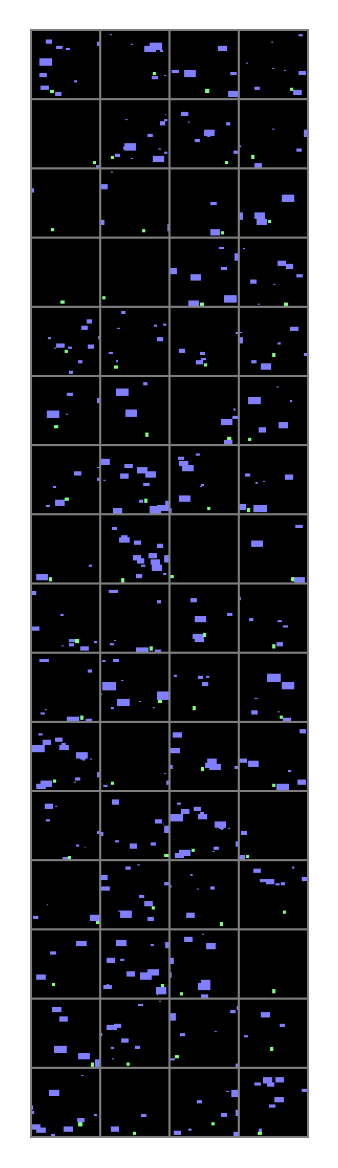

tensor([-1., -1.,  0., -1., -1., -1.,  0.,  0.,  0.,  0., -1., -1.,  0.,  0.,
        -1.,  0., -1.,  0., -1.,  0.,  0.,  0., -1.,  0., -1., -1.,  0., -1.,
        -1.,  0., -1., -1., -1., -1., -1., -1., -1., -1.,  0., -1., -1.,  0.,
        -1., -1., -1.,  0., -1., -1., -1., -1.,  0.,  0.,  0., -1.,  0.,  0.,
        -1.,  0., -1.,  0.,  0.,  0.,  0., -1.])


In [ ]:
# @title data weighted
import torch
import torch.nn as nn

torch.manual_seed(0)
torch.cuda.manual_seed_all(0)

data = [step for episode in buffer for step in episode]
state, action, reward = zip(*data)
# print("reward",type(reward))
data_targets=(torch.tensor(reward)==0).int()
train_data=list(zip(state,reward))


from torch.utils.data import Dataset
import torchvision.transforms as transforms
class Datasetme(Dataset):
    def __init__(self, dataset, transform=None):
        super().__init__()
        self.dataset = dataset
        self.transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        x, y = self.dataset[index]
        if self.transform:
            x = self.transform(x)
        return x, torch.tensor(y, dtype=torch.float)
train_data = Datasetme(train_data)


from collections import Counter
class_count = torch.tensor(list(Counter(data_targets.tolist()).values()))
class_count = sorted(Counter(data_targets.tolist()).items())
class_count=torch.tensor([x[1] for x in class_count])
weight=1./class_count
weights = weight[data_targets]

# batch_size = 64 #

train_sampler = torch.utils.data.WeightedRandomSampler(weights, len(weights))
# train_loader = torch.utils.data.DataLoader(train_data, sampler=train_sampler, batch_size=batch_size, num_workers=4, pin_memory=True)
c_loader = torch.utils.data.DataLoader(train_data, sampler=train_sampler, batch_size=batch_size, pin_memory=True)



import matplotlib
import numpy as np
matplotlib.rcParams['figure.dpi'] = 300
def imshow(img): # display img from torch tensor
    img = img / 2 + 0.5  # unnormalize
    plt.axis('off')
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

trainiter = iter(c_loader)
images, labels = next(trainiter)
imshow(torchvision.utils.make_grid(images,nrow=4))
print(labels)

# with torch.no_grad(): print(agent.tcost(agent.jepa.enc(images.to(device))).squeeze(-1))



In [ ]:

# def train(model, train_loader, loss_function, optimizer):
#     model.train()
#     for image, _ in train_loader:
#         image = image.to(device)#.reshape(-1, 28*28)
#         reconstructed = model(image)
#         loss = loss_function(reconstructed, image)
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()


class Agent(torch.nn.Module):
    def __init__(self, d_model = 256):
        super().__init__()
        # d_list=[32, 64, 128, 256, 512, 1024] #
        d_list=[32, 64, 128, 256, 256, 256] #
        # d_list = [min(d, d_model) for d in d_list]
        self.cnn = nn.Sequential( # nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0), # SiLU ReLU
            nn.Conv2d(3, d_list[0], 7, 2, 3), nn.BatchNorm2d(d_list[0]), nn.ReLU(),
            nn.Conv2d(d_list[0], d_list[1], 5, 2, 2), nn.BatchNorm2d(d_list[1]), nn.ReLU(),
            nn.Conv2d(d_list[1], d_list[2], 3, 2, 1), nn.BatchNorm2d(d_list[2]), nn.ReLU(),
            nn.Conv2d(d_list[2], d_list[3], 3, 2, 1), nn.BatchNorm2d(d_list[3]), nn.ReLU(),
            nn.Conv2d(d_list[3], d_list[4], 3, 2, 1), nn.BatchNorm2d(d_list[4]), nn.ReLU(),
            # nn.Conv2d(d_list[4], d_list[5], 3, 2, 1), nn.ReLU(),
            nn.Flatten(start_dim=1),
            # nn.Linear(4*d_list[4],d_list[5]), nn.ReLU(),
            nn.Linear(4*d_list[4],d_model), nn.ReLU(),
            nn.Linear(d_model,1),
        )
    def forward(self, x): return self.cnn(x)

# agent = Agent(d_model=256).to(device)
# optim = torch.optim.AdamW(agent.parameters(), 1e-2, (0.9, 0.95))
optim.param_groups[0]["lr"] = 1e-1

loss_function = torch.nn.MSELoss()
def train_cost(model, dataloader, optim, loss_function=loss_function):
    model.train()
    for batch, (st, r) in enumerate(dataloader):
        st, r = st.to(device), r.to(device)#.squeeze(-1)
        # st.requires_grad=True; r.requires_grad=True
        # print(st.requires_grad, r.requires_grad)
        # loss = F.mse_loss(model.tcost(model.jepa.enc(st)), r)
        # print(model.jepa.enc(st))
        # loss = loss_function(model.tcost(model.jepa.enc(st)), r)
        loss = loss_function(model(st), r)
        # print(next(model.tcost[0].parameters()).grad)
        # print(next(model.jepa.enc.parameters()).grad)
        # print(model.tcost.parameters()[0].grad)
        # print(loss)
        loss.backward()
        optim.step()
        optim.zero_grad()
        print(loss.item())
        try: wandb.log({"closs": loss.item()})
        except: pass


for i in range(1):
    train_cost(agent, c_loader, optim)


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


0.24990487098693848
0.2503257393836975
0.24954870343208313
0.25000569224357605
0.2493157982826233
0.24975788593292236
0.24667567014694214
0.2512463927268982
0.2545332610607147
0.26391732692718506
0.2518472671508789
0.25843799114227295
0.2465539425611496
0.24917486310005188
0.2478078007698059
0.24778664112091064
0.25149020552635193
0.2519086003303528
0.25039926171302795
0.25046512484550476
0.25009074807167053
0.24980758130550385
0.25152313709259033
0.24729923903942108
0.2518409490585327
0.2566208243370056
0.24763235449790955
0.2493126392364502
0.25335219502449036
0.25023263692855835
0.24978306889533997
0.24768319725990295
0.25134748220443726
0.24338887631893158
0.2554859220981598
0.25440385937690735
0.24611514806747437
0.25877559185028076
0.2630069851875305
0.2585007846355438
0.24700972437858582
0.24992938339710236
0.2484132945537567
0.24819201231002808
0.24781253933906555
0.25536733865737915
0.2481987029314041
0.25964778661727905
0.2586623728275299
0.24951651692390442
0.255162268877029

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([44])) that is different to the input size (torch.Size([44, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


In [ ]:
for i in range(100):
    train_cost(agent, c_loader, optim)


Streaming output truncated to the last 5000 lines.
0.26151242852211
0.25037074089050293
0.25027528405189514
0.25019770860671997
0.25013601779937744
0.24539172649383545
0.2500703036785126
0.25376129150390625
0.2500292658805847
0.25001248717308044
0.2500031888484955
0.2500000298023224
0.25068068504333496
0.2492522895336151
0.2514137625694275
0.2514066994190216
0.2483869045972824
0.25000759959220886
0.2481103539466858
0.25003379583358765
0.25005844235420227
0.2547377347946167
0.2500925660133362
0.2500975728034973
0.25513550639152527
0.25008153915405273
0.25006455183029175
0.24651175737380981
0.2500549554824829
0.2500590980052948
0.24610987305641174
0.24542328715324402
0.2501392066478729
0.2572084069252014
0.2575485110282898
0.250194251537323
0.2567729353904724
0.2501264214515686
0.259477436542511
0.2528526782989502
0.24941983819007874
0.25000301003456116
0.25222209095954895
0.2500317394733429
0.25004541873931885
0.2461974024772644
0.25983211398124695
0.24548408389091492
0.2549602091312408

KeyboardInterrupt: 

In [ ]:
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np
# https://www.geeksforgeeks.org/implementing-an-autoencoder-in-pytorch/

train_data = torchvision.datasets.MNIST(root="data", train=True, download=True,transform=transforms.ToTensor(),)
# test_data = torchvision.datasets.MNIST(root="data", train=False, download=True, transform=transforms.ToTensor(),) #opt no download
batch_size = 4 # 512
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
# test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)
for batch, (st, r) in enumerate(train_loader):
    st, r = st.to(device), r.to(device).squeeze(-1)
    print(st.requires_grad, r.requires_grad)



Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:02<00:00, 4511434.51it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 54926.86it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:01<00:00, 1259133.26it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 9989789.60it/s]


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw

False False
False False
False False
False False
False False
False False
False False
False False
False False
False False
False False
False False
False False
False False
False False
False False
False False
False False
False False
False False
False False
False False
False False
False False
False False
False False
False False
False False
False False
False False
False False
False False
False False
False False
False False
False False
False False
False False
False False
False False
False False
False False
False False
False False
False False
False False
False False
False False
False False
False False
False False
False False
False False
False False
False False
False False
False False
False False
False False
False False
False False
False False
False False
False False
False False
False False
False False
False False
False False
False False
False False
False False
False False
False False
False False
False False
False False
False

KeyboardInterrupt: 

In [ ]:
print(agent)
# for x in agent.parameters():
#     print(x)

Agent(
  (jepa): JEPA(
    (enc): Conv(
      (cnn): Sequential(
        (0): Conv2d(3, 32, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Conv2d(32, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU()
        (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (8): ReLU()
        (9): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (10): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (11): ReLU()
        (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (13): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_runn

In [ ]:
print(next(agent.tcost[0].parameters()).grad)

None


0


<ipython-input-75-7e24103f59f2>:275: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  st, r = st.to(device), torch.tensor(r, device=device, dtype=torch.float).squeeze(-1)
<ipython-input-75-7e24103f59f2>:276: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  closs = F.mse_loss(self.tcost(self.jepa.enc(st)), r)


repr, std, cov, conv, closs 0.5615471601486206 0.4755859375 5.877390503883362e-05 0.009204329922795296 0.24997490644454956
0.14145714394580114 0.01 1.0
repr, std, cov, conv, closs 0.5657975077629089 0.47509765625 6.558769382536411e-05 0.007288734428584576 0.24981319904327393
0.14402513134295195 0.01 1.0
repr, std, cov, conv, closs 0.5776116251945496 0.4755859375 5.821906961500645e-05 0.00783985760062933 0.24962523579597473
0.14870609158400133 0.01 1.0
repr, std, cov, conv, closs 0.5982287526130676 0.4755859375 5.800323560833931e-05 0.008462255820631981 0.25054001808166504
0.15140567506501365 0.01 1.0
repr, std, cov, conv, closs 0.5769054293632507 0.47607421875 5.053100176155567e-05 0.010017989203333855 0.24855411052703857
0.15632651032924932 0.01 1.0
repr, std, cov, conv, closs 0.5881494283676147 0.47509765625 5.767121911048889e-05 0.009553316049277782 0.25313979387283325
0.15916443351338974 0.01 1.0
repr, std, cov, conv, closs 0.5747824311256409 0.47412109375 7.575890049338341e-05 0.0

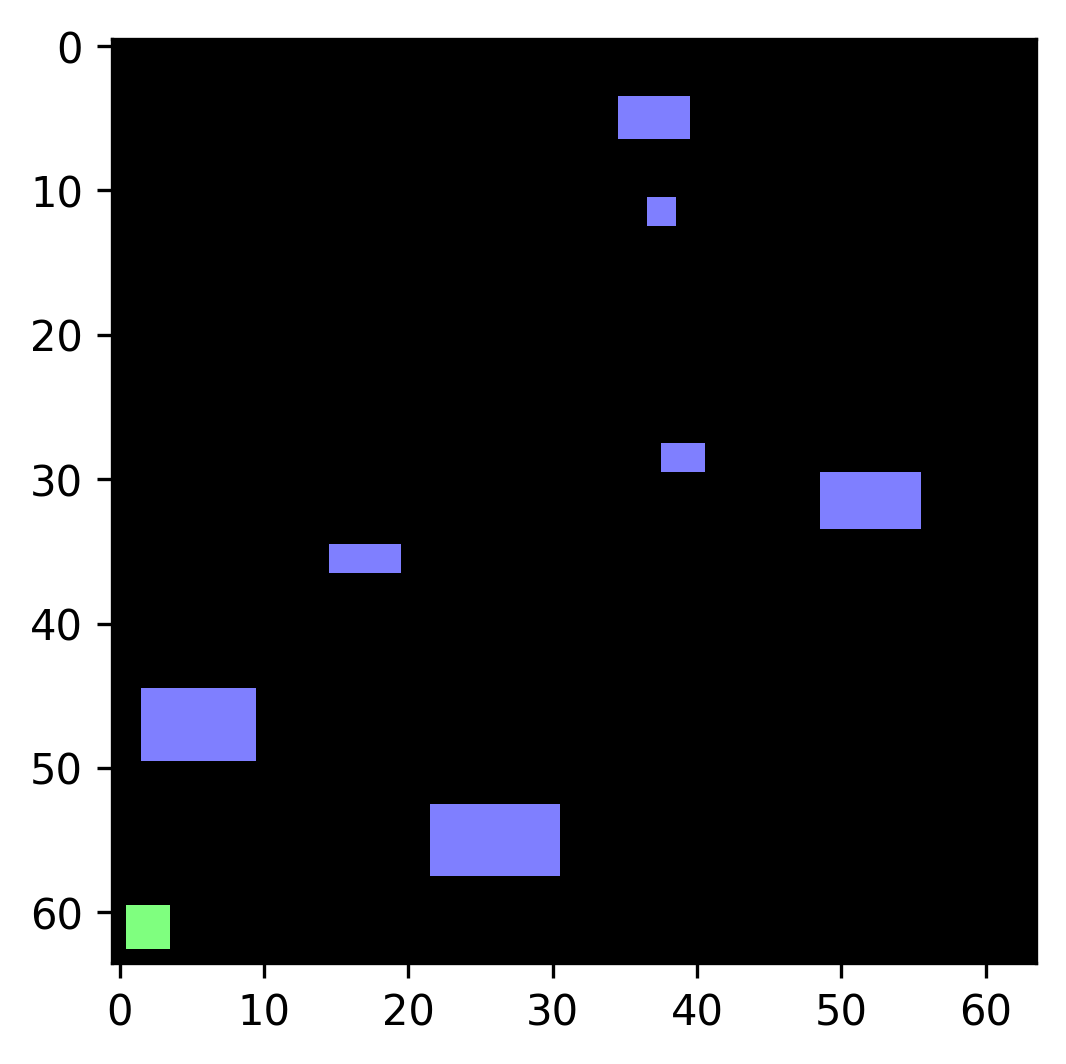

(3, 64, 64)


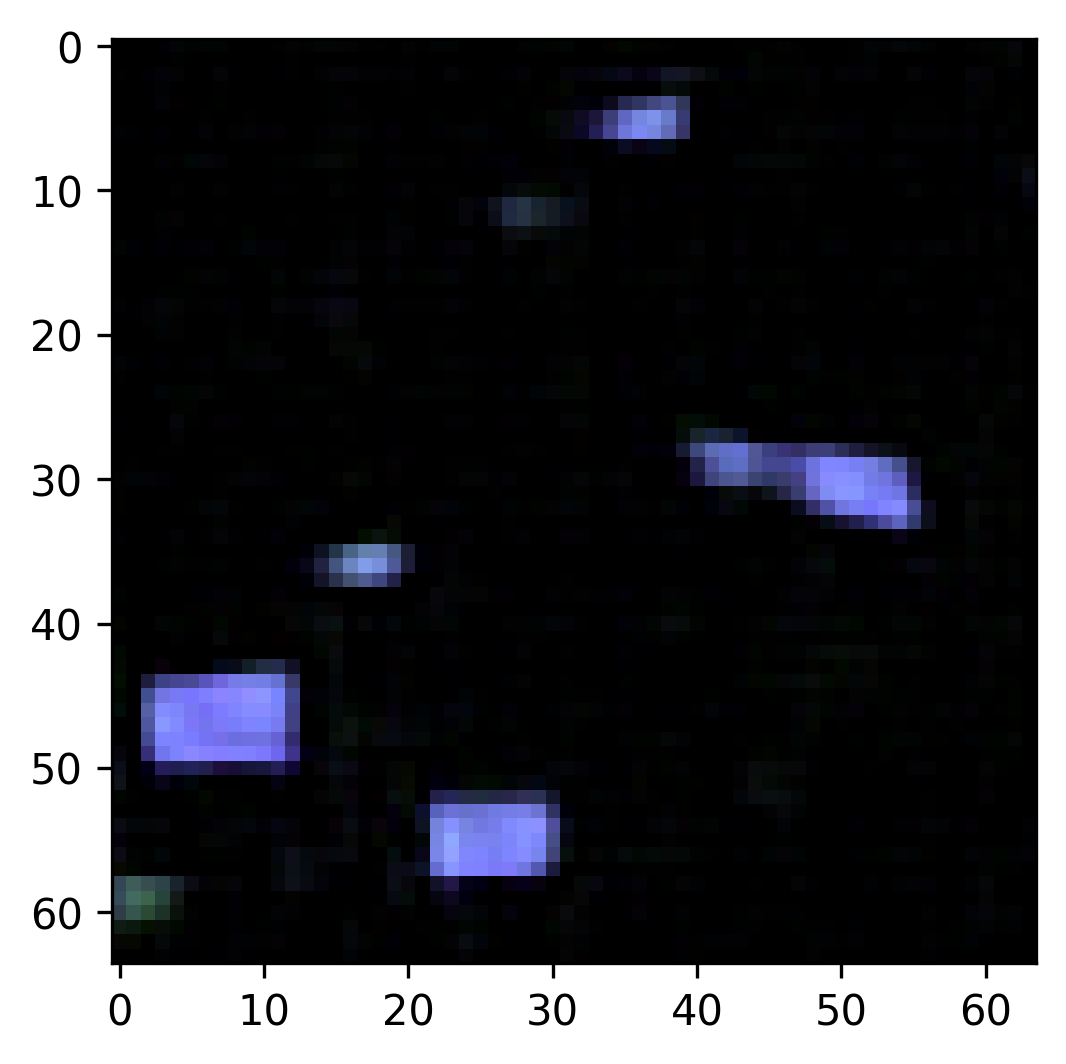

1
repr, std, cov, conv, closs 0.5882740020751953 0.474609375 5.423557013273239e-05 0.007954108528792858 0.2503625452518463
0.33081922716398887 0.01 1.0
repr, std, cov, conv, closs 0.6185262799263 0.474853515625 5.220761522650719e-05 0.008925891481339931 0.2500922977924347
0.33682485955833286 0.01 1.0
repr, std, cov, conv, closs 0.5831621885299683 0.474365234375 5.668727681040764e-05 0.007671722676604986 0.2499188780784607
0.34777200302619926 0.01 1.0
repr, std, cov, conv, closs 0.5961040258407593 0.47412109375 5.894922651350498e-05 0.007139944937080145 0.249410018324852
0.35408539304625614 0.01 1.0
repr, std, cov, conv, closs 0.5932449698448181 0.472900390625 7.840734906494617e-05 0.007977984845638275 0.25266367197036743
0.3655935210467728 0.01 1.0
repr, std, cov, conv, closs 0.584794282913208 0.47412109375 5.9785088524222374e-05 0.007035218179225922 0.24862763285636902
0.3722304396805027 0.01 1.0
repr, std, cov, conv, closs 0.5961453914642334 0.474365234375 5.94619195908308e-05 0.0092

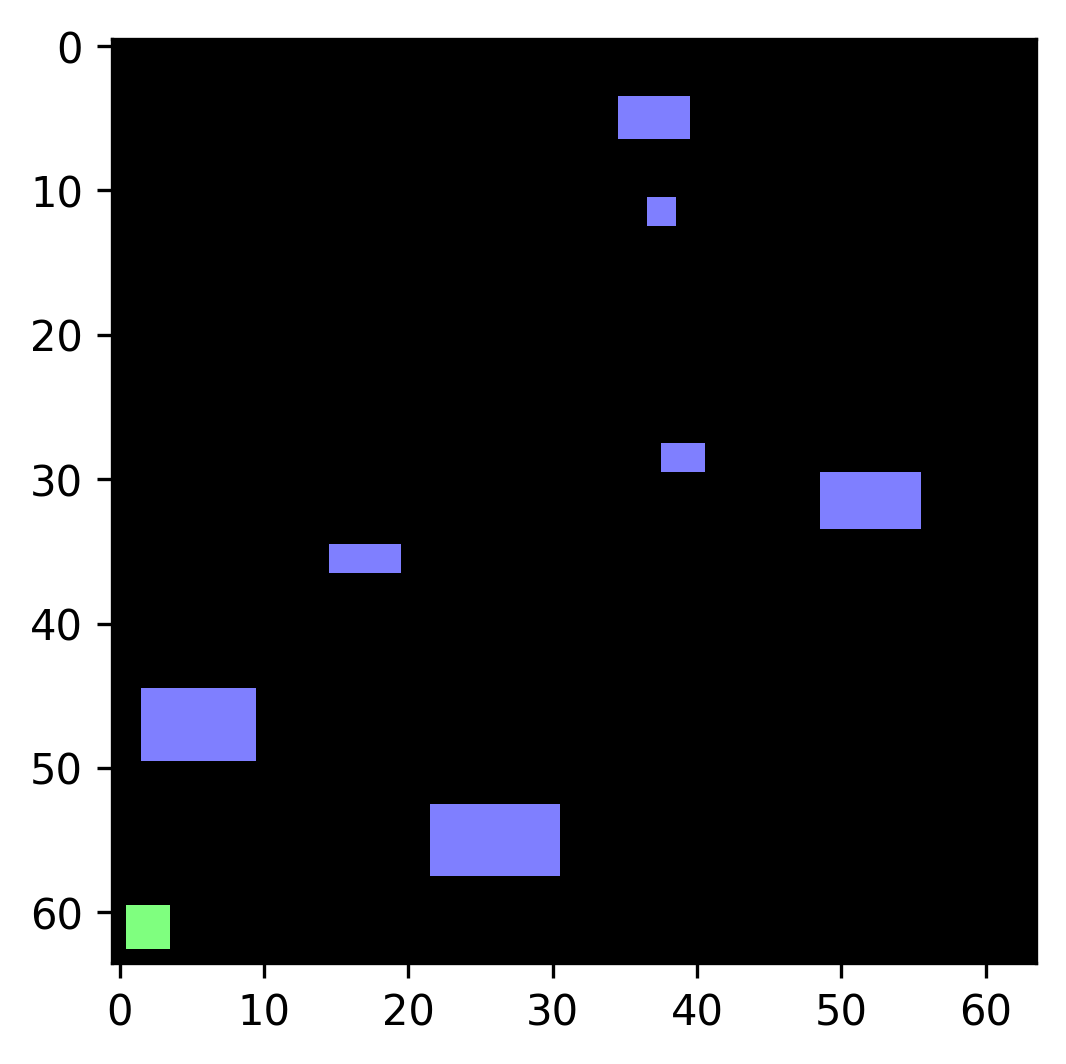

(3, 64, 64)


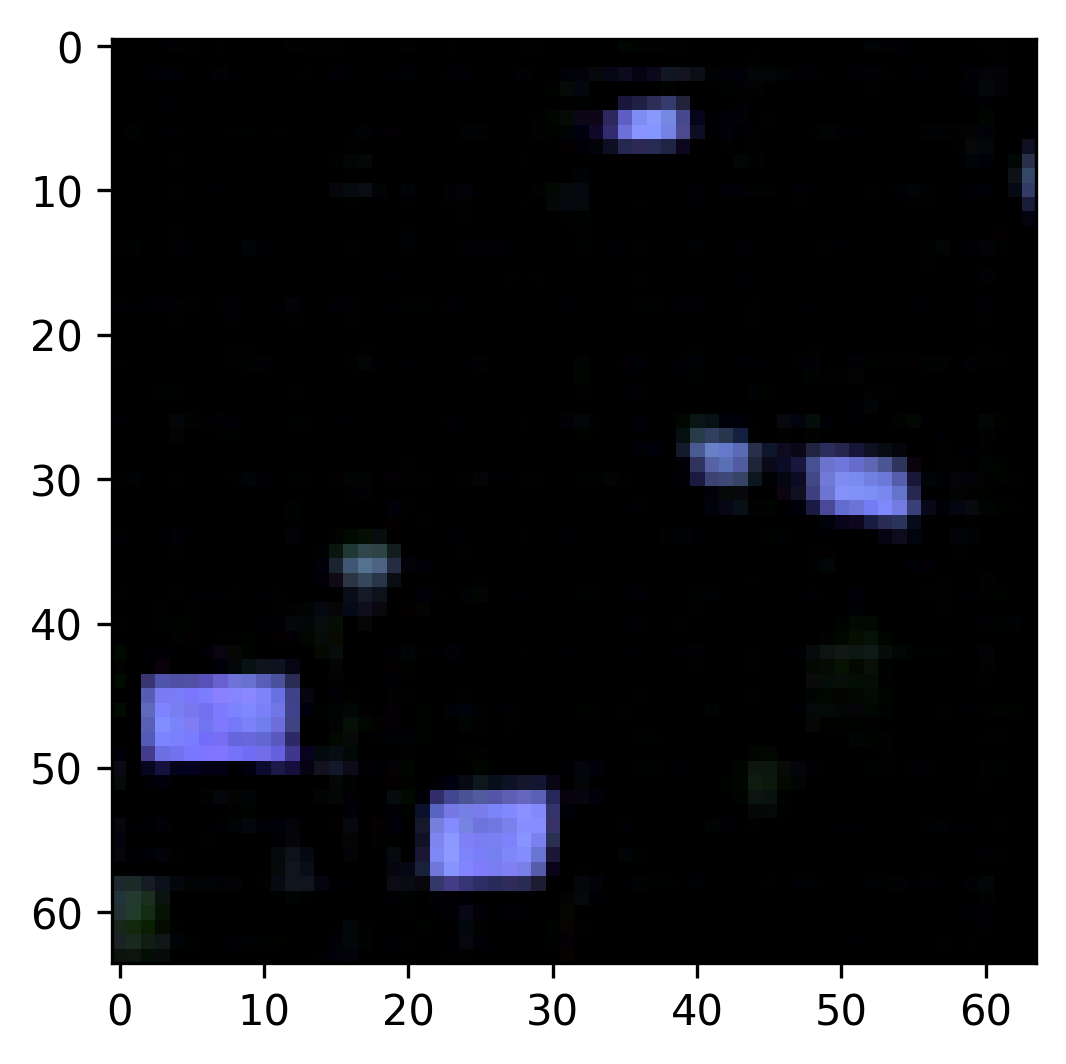

2
repr, std, cov, conv, closs 0.5904590487480164 0.473876953125 6.0126883909106255e-05 0.009221423417329788 0.24852848052978516
0.773671502255909 0.01 1.0
repr, std, cov, conv, closs 0.5909682512283325 0.474365234375 5.7531287893652916e-05 0.008512292057275772 0.25289690494537354
0.7877165947263827 0.01 1.0
repr, std, cov, conv, closs 0.5781852602958679 0.474365234375 5.959300324320793e-05 0.008858933113515377 0.25204336643218994
0.8133181687485506 0.01 1.0
repr, std, cov, conv, closs 0.5818089842796326 0.474609375 5.640345625579357e-05 0.007630174979567528 0.24784725904464722
0.8280829996292042 0.01 1.0
repr, std, cov, conv, closs 0.577896773815155 0.474853515625 5.547003820538521e-05 0.00853193923830986 0.2515033483505249
0.8549965220222037 0.01 1.0
repr, std, cov, conv, closs 0.6041667461395264 0.47412109375 5.824631080031395e-05 0.00921550951898098 0.25084546208381653
0.8705179741872642 0.01 1.0
repr, std, cov, conv, closs 0.5693269371986389 0.4736328125 6.463145837187767e-05 0.007

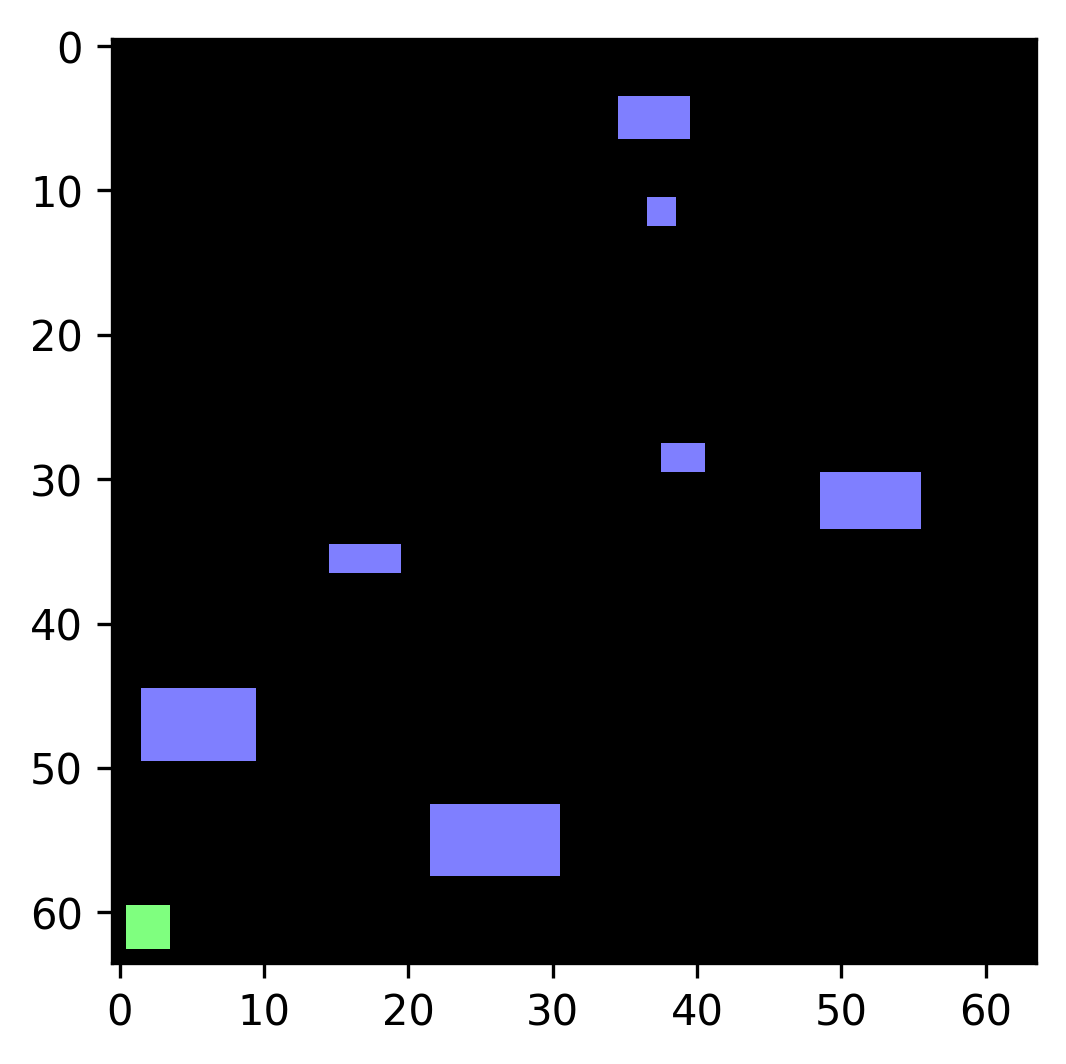

(3, 64, 64)


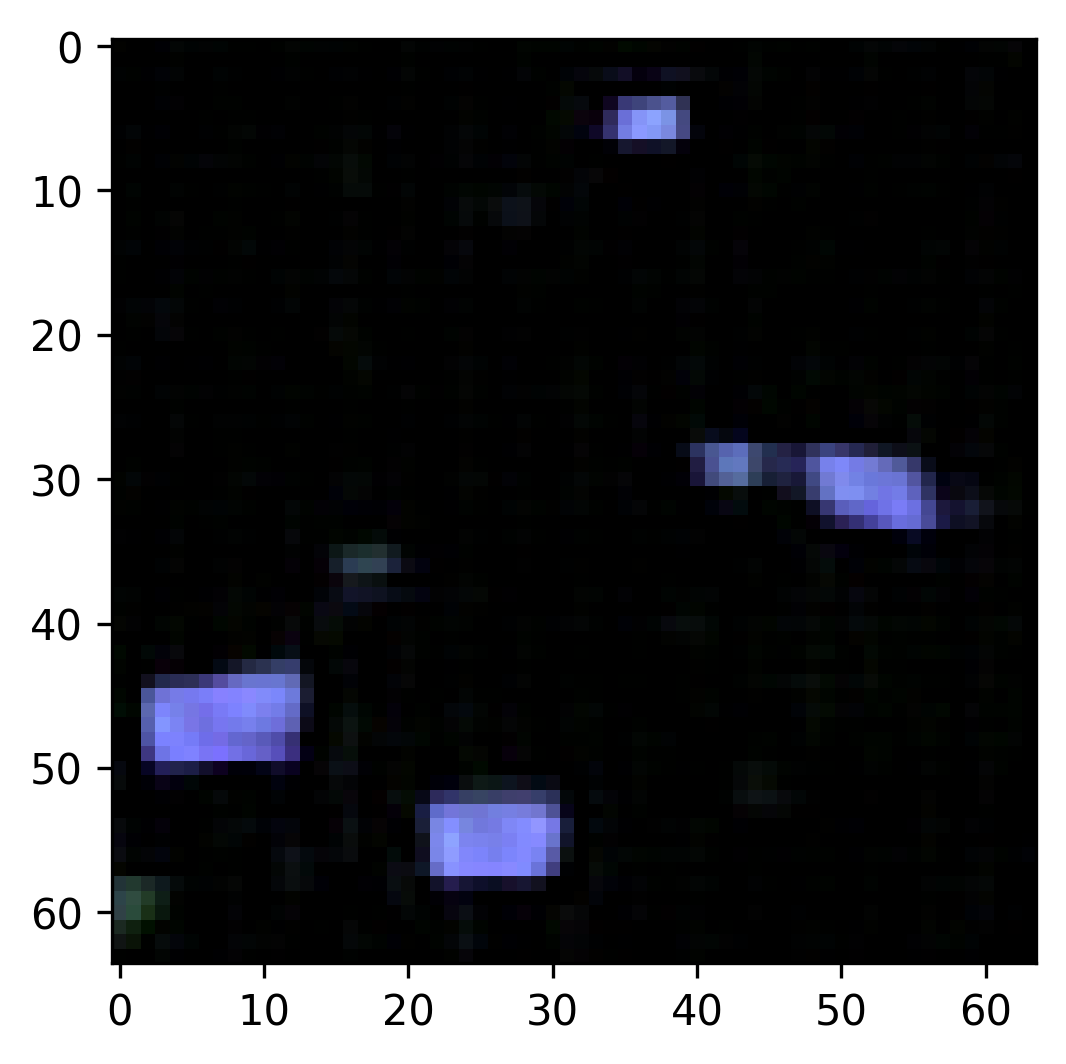

3
repr, std, cov, conv, closs 0.5963541865348816 0.473876953125 6.166170351207256e-05 0.008937884122133255 0.2514956295490265
1.8093494702053836 0.01 1.0
repr, std, cov, conv, closs 0.5934041738510132 0.473388671875 6.680889055132866e-05 0.007988618686795235 0.24924246966838837
1.8421960731193316 0.01 1.0
repr, std, cov, conv, closs 0.5931870937347412 0.47314453125 6.805825978517532e-05 0.00797975156456232 0.2533658742904663
1.9020692806219537 0.01 1.0
repr, std, cov, conv, closs 0.5916429758071899 0.4736328125 6.262585520744324e-05 0.007957905530929565 0.25216829776763916
1.9365991021982774 0.01 1.0
repr, std, cov, conv, closs 0.5879102945327759 0.473388671875 6.429548375308514e-05 0.008076521568000317 0.24920903146266937
1.9995405021867019 0.01 1.0
repr, std, cov, conv, closs 0.5888068675994873 0.4736328125 6.325286813080311e-05 0.007566527463495731 0.2523367404937744
2.035839798683706 0.01 1.0
repr, std, cov, conv, closs 0.5894213914871216 0.473876953125 6.264331750571728e-05 0.0080

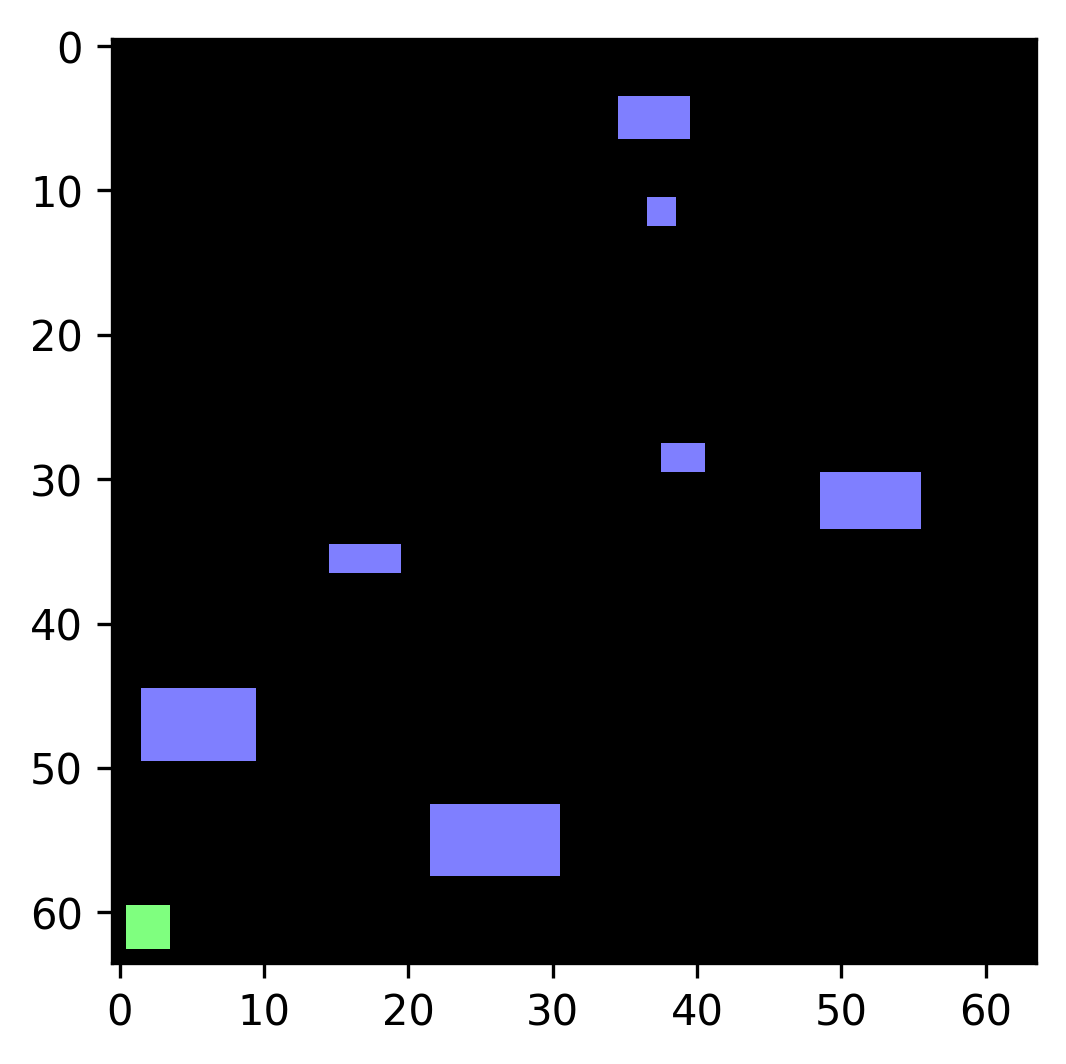

(3, 64, 64)


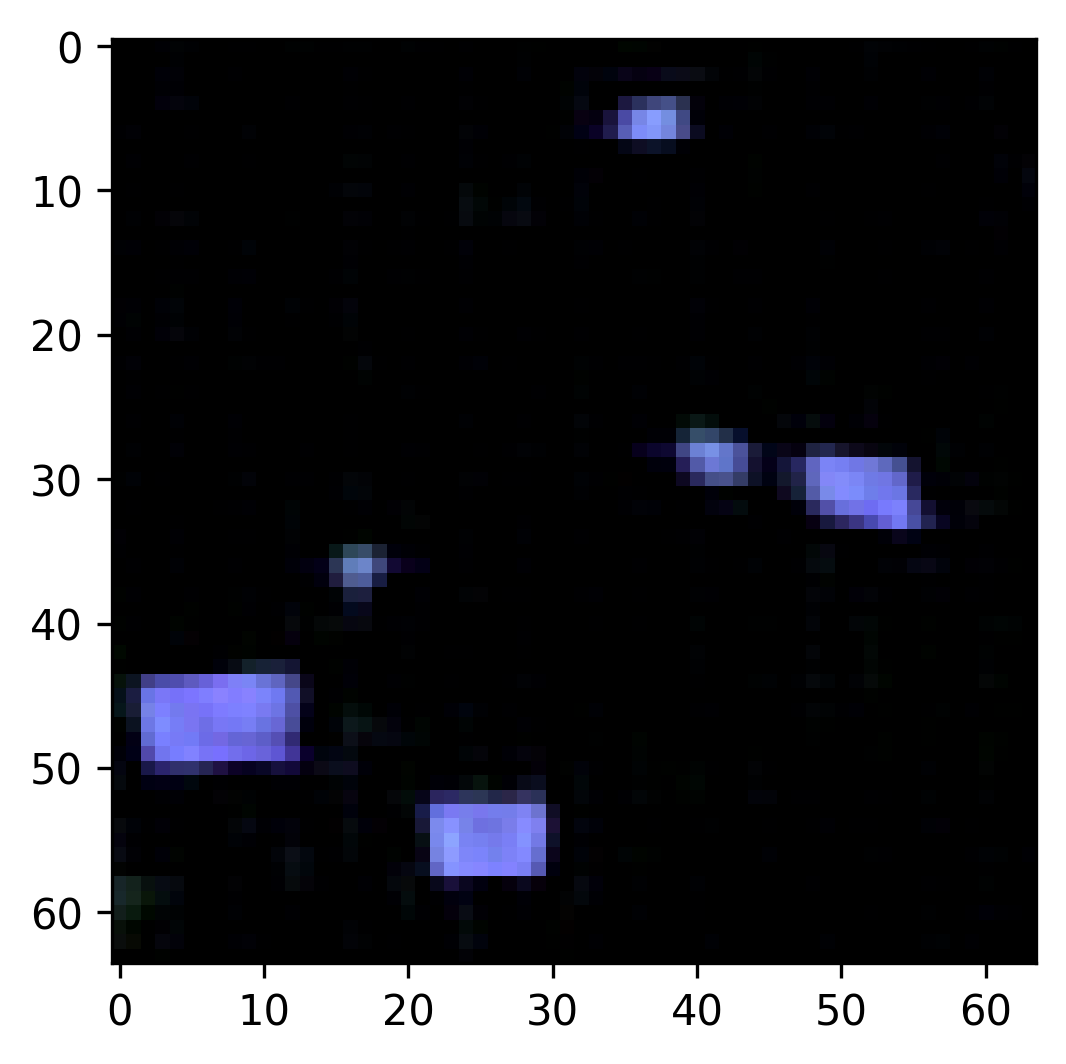

4
repr, std, cov, conv, closs 0.5946475267410278 0.474365234375 5.696481093764305e-05 0.008496580645442009 0.24978820979595184
3.9971081457123345 0.01 1.0
repr, std, cov, conv, closs 0.5953487157821655 0.474365234375 5.471613258123398e-05 0.008528050035238266 0.24977552890777588
4.069670923787162 0.01 1.0
repr, std, cov, conv, closs 0.5786923766136169 0.47314453125 6.654602475464344e-05 0.007715586572885513 0.25015515089035034
4.201939282862922 0.01 1.0
repr, std, cov, conv, closs 0.5835652351379395 0.472900390625 6.860354915261269e-05 0.007409020327031612 0.25100797414779663
4.278220528341195 0.01 1.0
repr, std, cov, conv, closs 0.5692178010940552 0.473388671875 6.651016883552074e-05 0.00790341105312109 0.25177842378616333
4.3820873146483335 0.01 1.0
repr, std, cov, conv, closs 0.5738951563835144 0.473388671875 6.807572208344936e-05 0.00756608322262764 0.2501128315925598
4.408445657553445 0.01 1.0
repr, std, cov, conv, closs 0.5916578769683838 0.474365234375 5.3862109780311584e-05 0.0

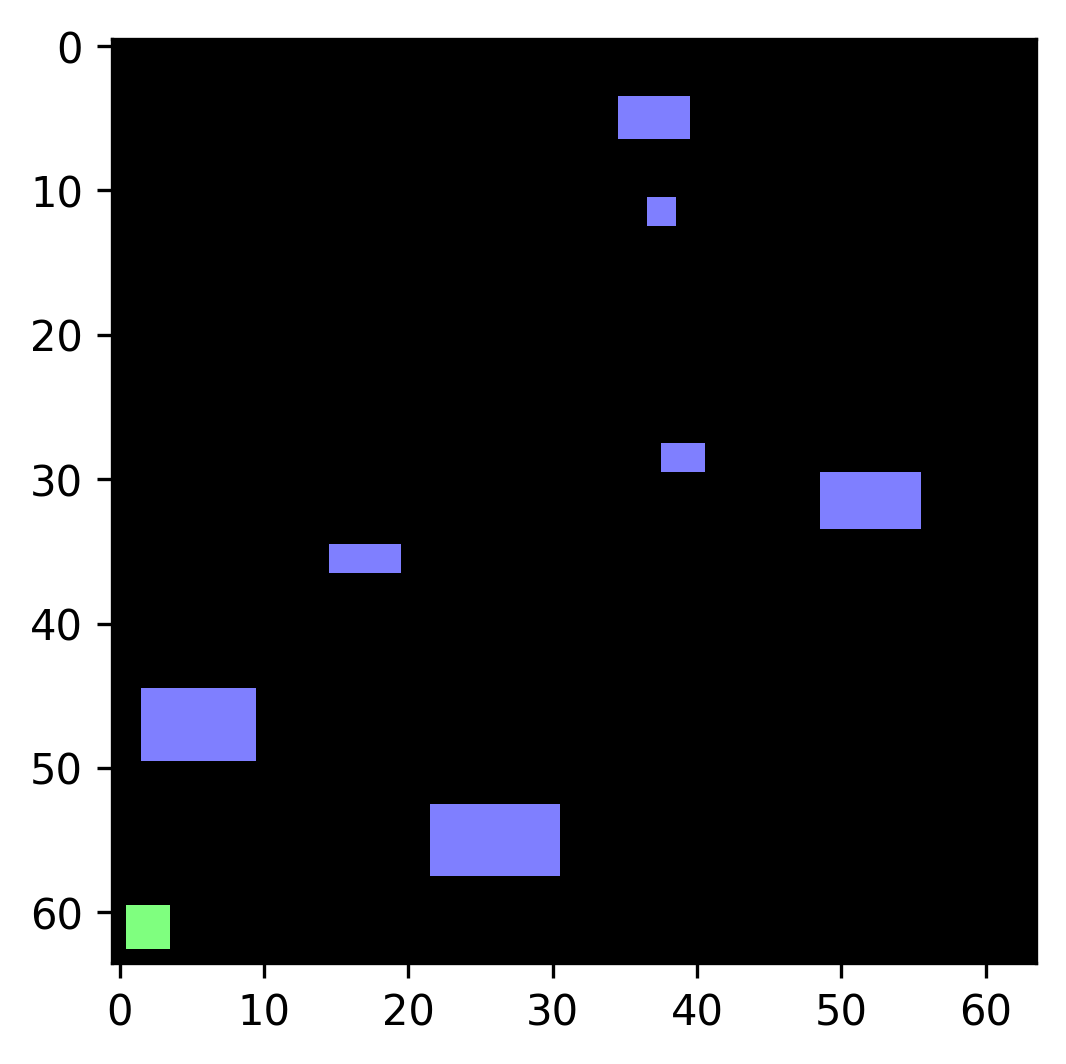

(3, 64, 64)


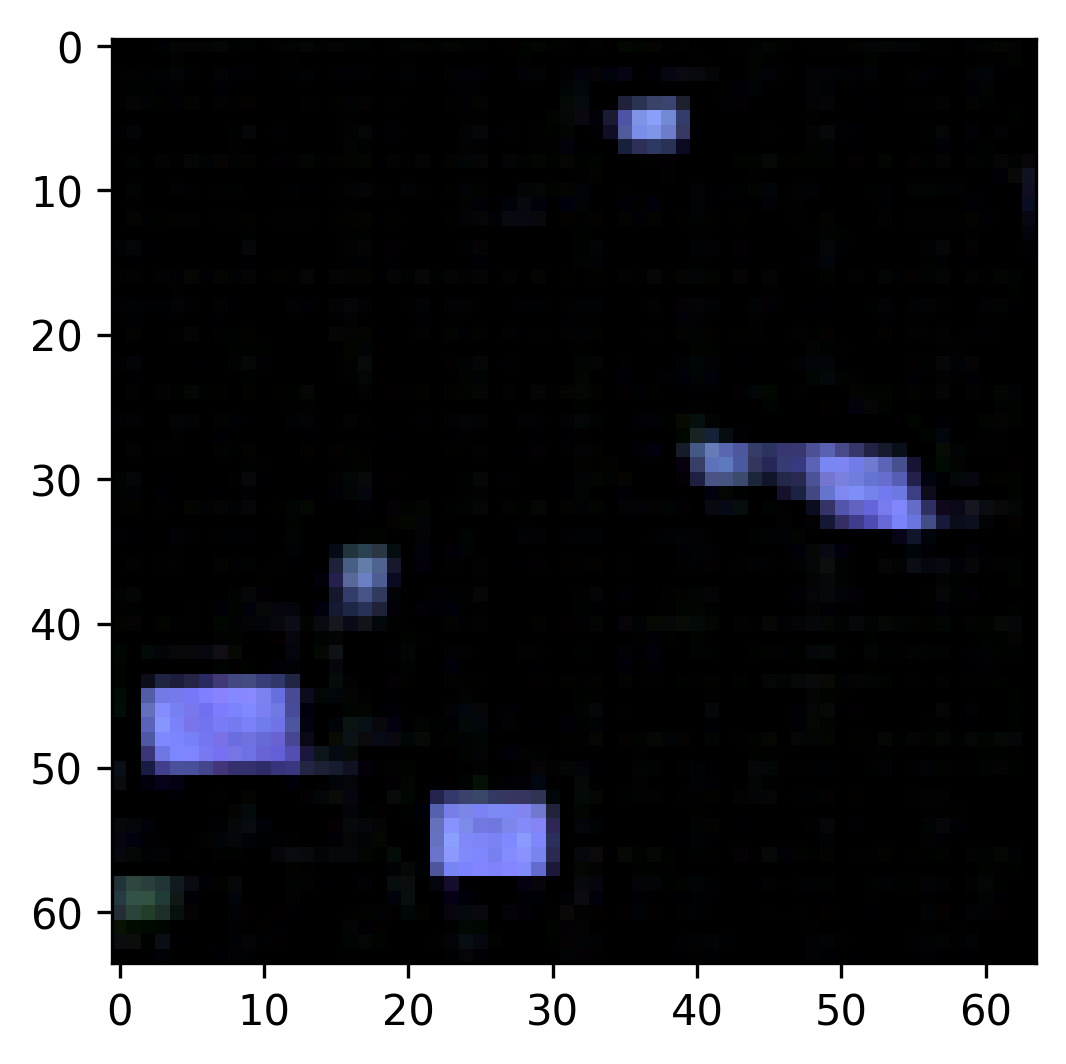

5
repr, std, cov, conv, closs 0.5684428811073303 0.473388671875 6.484403274953365e-05 0.008020727895200253 0.24704256653785706
7.510153058989901 0.01 1.0
repr, std, cov, conv, closs 0.5931069850921631 0.473388671875 6.492924876511097e-05 0.008646003901958466 0.25489065051078796
7.61598136697255 0.01 1.0
repr, std, cov, conv, closs 0.5963462591171265 0.47314453125 6.846734322607517e-05 0.008961972780525684 0.25086236000061035
7.863508348152533 0.01 1.0
repr, std, cov, conv, closs 0.6124488115310669 0.47314453125 6.663985550403595e-05 0.008968657813966274 0.24312268197536469
8.006261055949201 0.01 1.0
repr, std, cov, conv, closs 0.578498363494873 0.472900390625 7.024477235972881e-05 0.007985345087945461 0.2498849630355835
8.12719928300071 0.01 1.0
repr, std, cov, conv, closs 0.5878345370292664 0.474365234375 5.667516961693764e-05 0.007501415908336639 0.25154656171798706
8.217046814747889 0.01 1.0
repr, std, cov, conv, closs 0.5733668804168701 0.4736328125 6.104889325797558e-05 0.00758925

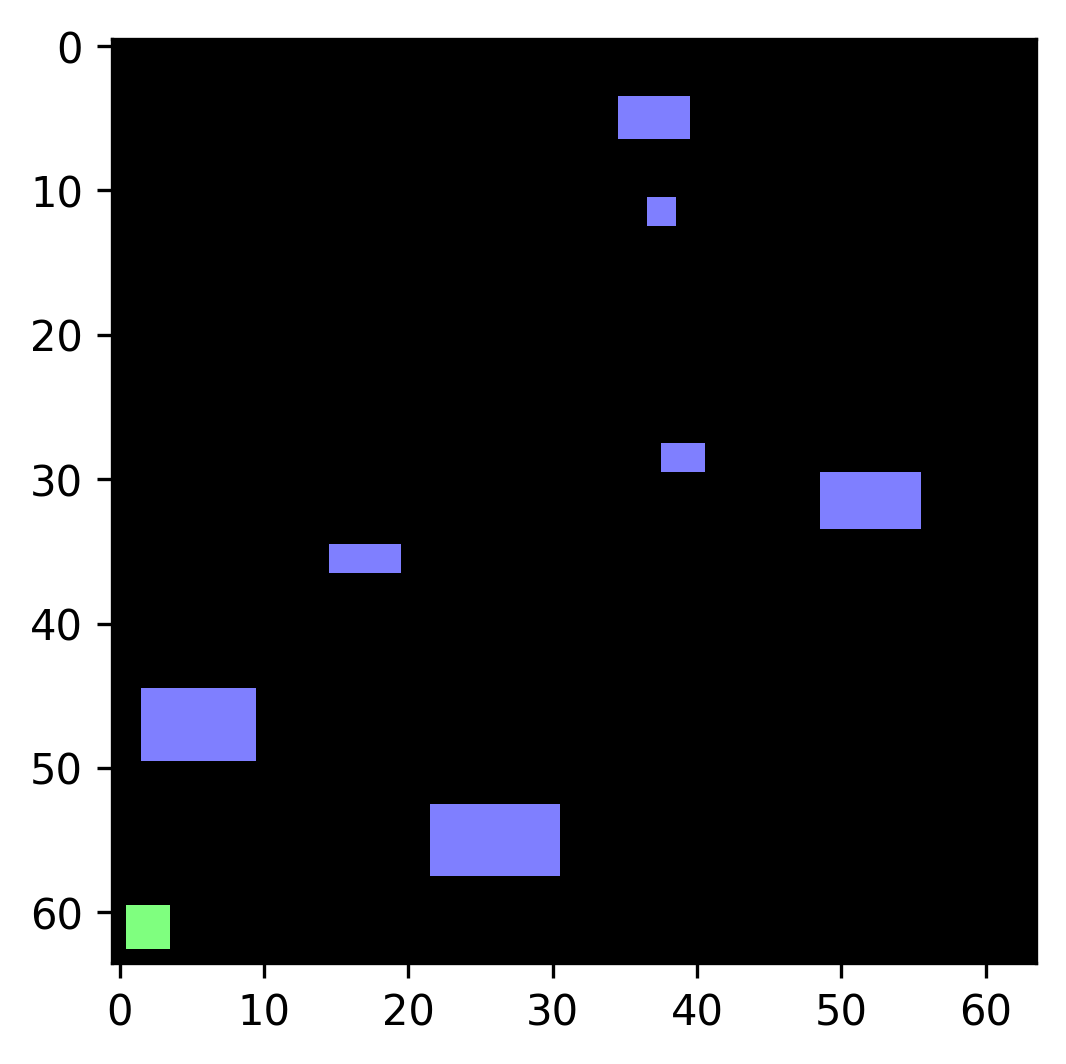

(3, 64, 64)


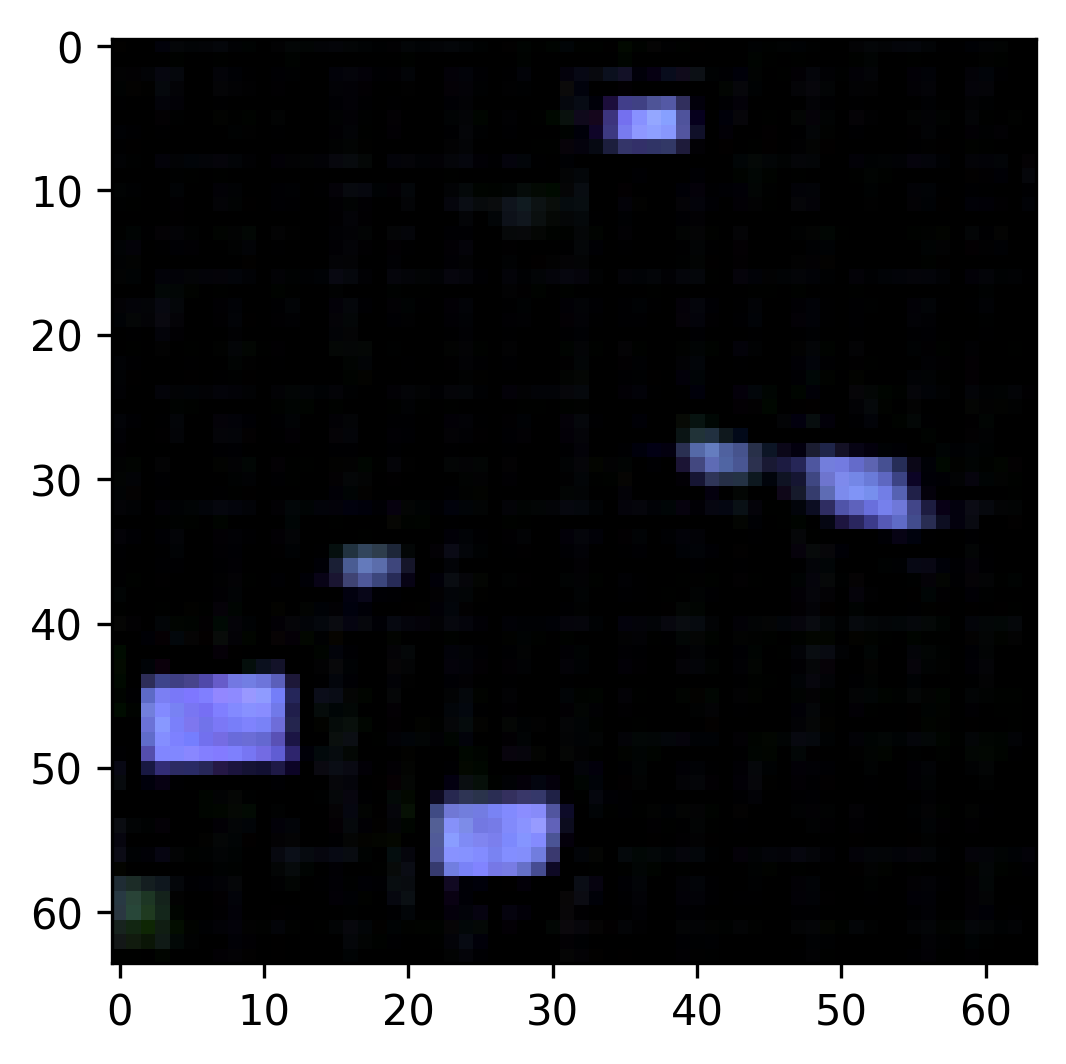

6
repr, std, cov, conv, closs 0.5849355459213257 0.472900390625 7.268856279551983e-05 0.007336466573178768 0.2525637149810791
12.89688135169636 0.01 1.0
repr, std, cov, conv, closs 0.6085473299026489 0.473388671875 6.419094279408455e-05 0.008271208964288235 0.24979811906814575
13.065550463759783 0.01 1.0
repr, std, cov, conv, closs 0.581633985042572 0.4736328125 6.362097337841988e-05 0.007816238328814507 0.24985283613204956
13.422944781588217 0.01 1.0
repr, std, cov, conv, closs 0.6031649708747864 0.47314453125 6.48109707981348e-05 0.007608832325786352 0.2472611665725708
13.639330192804975 0.01 1.0
repr, std, cov, conv, closs 0.6027531027793884 0.474365234375 5.51717821508646e-05 0.008891144767403603 0.25199294090270996
14.082622011057424 0.01 1.0
repr, std, cov, conv, closs 0.605671763420105 0.474609375 5.339737981557846e-05 0.007466359995305538 0.2500813603401184
14.338275383057427 0.01 1.0
repr, std, cov, conv, closs 0.607884407043457 0.47509765625 4.917476326227188e-05 0.0103643499

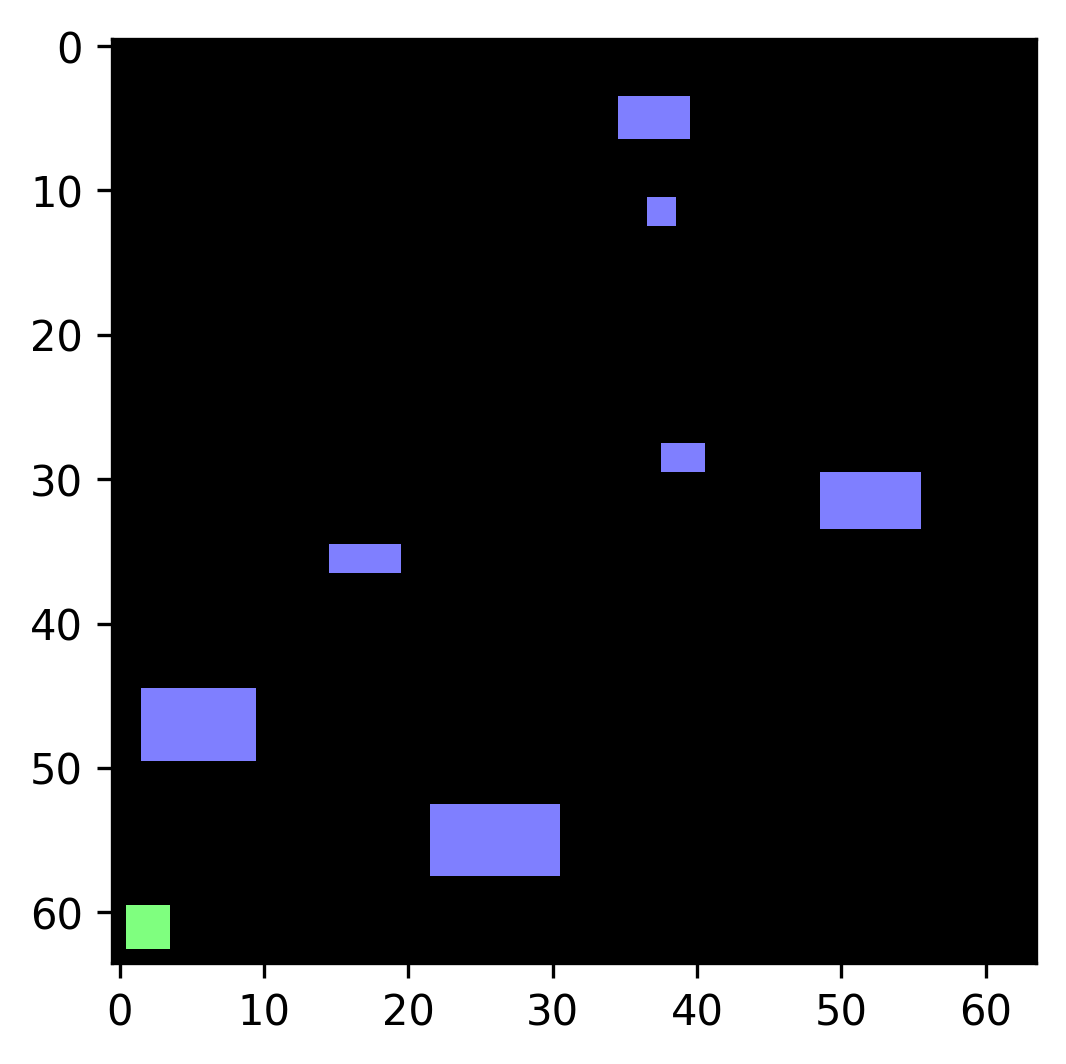

(3, 64, 64)


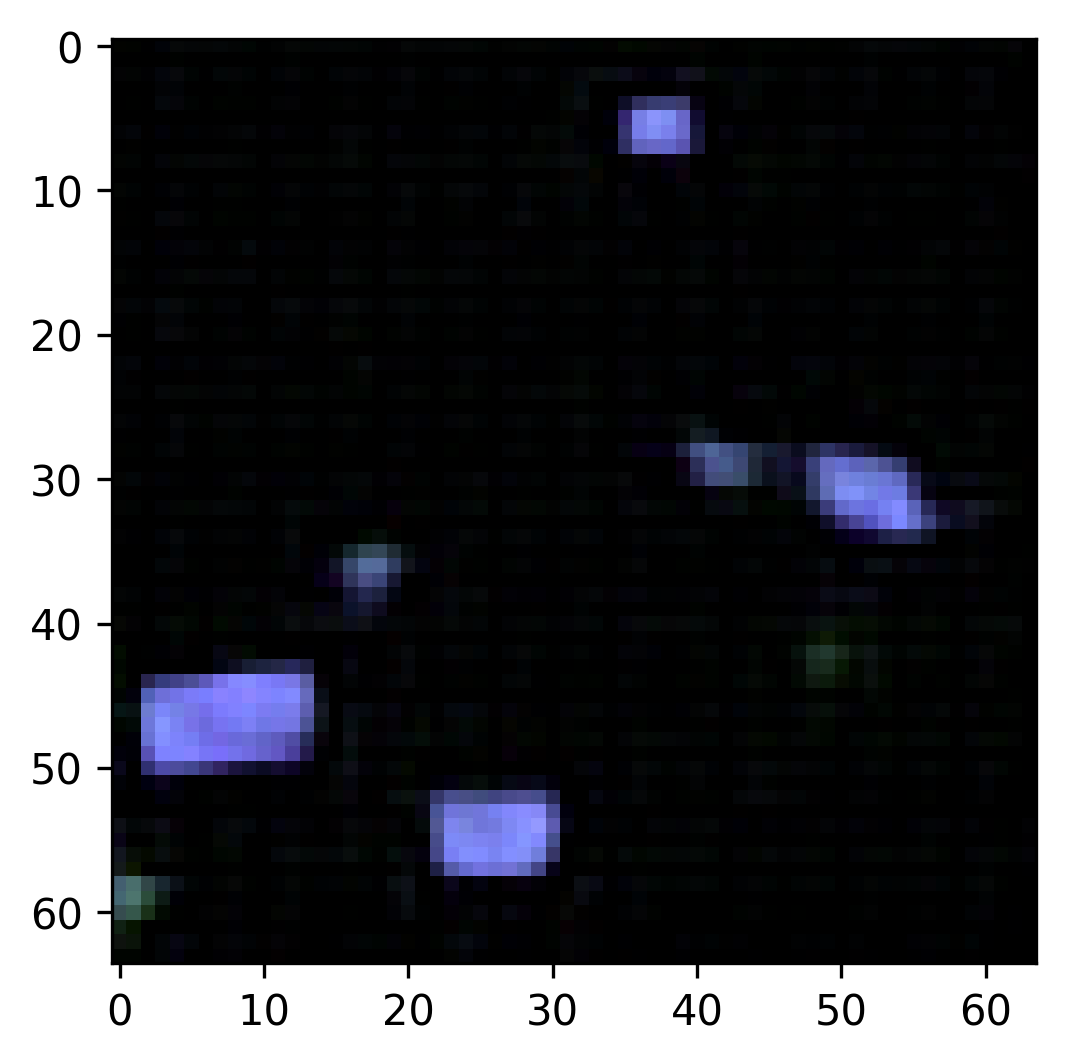

7
repr, std, cov, conv, closs 0.6099997758865356 0.47265625 7.16065987944603e-05 0.009092949330806732 0.24990910291671753
24.426442128010507 0.01 1.0
repr, std, cov, conv, closs 0.6143897771835327 0.47314453125 6.69737346470356e-05 0.007759471889585257 0.24902476370334625
24.869875338891664 0.01 1.0
repr, std, cov, conv, closs 0.5819156169891357 0.473388671875 6.495066918432713e-05 0.007945215329527855 0.258044958114624
25.044487604962605 0.01 1.0
repr, std, cov, conv, closs 0.5866185426712036 0.4736328125 5.996064282953739e-05 0.007547976449131966 0.25656312704086304
25.169960738433577 0.01 1.0
repr, std, cov, conv, closs 0.6090787649154663 0.47509765625 4.88809309899807e-05 0.010432517156004906 0.24985919892787933
25.98800953579819 0.01 1.0
repr, std, cov, conv, closs 0.618665337562561 0.474365234375 5.499483086168766e-05 0.0075523024424910545 0.25046518445014954
26.45979115886372 0.01 1.0
repr, std, cov, conv, closs 0.5972226858139038 0.472900390625 7.152208127081394e-05 0.008987588

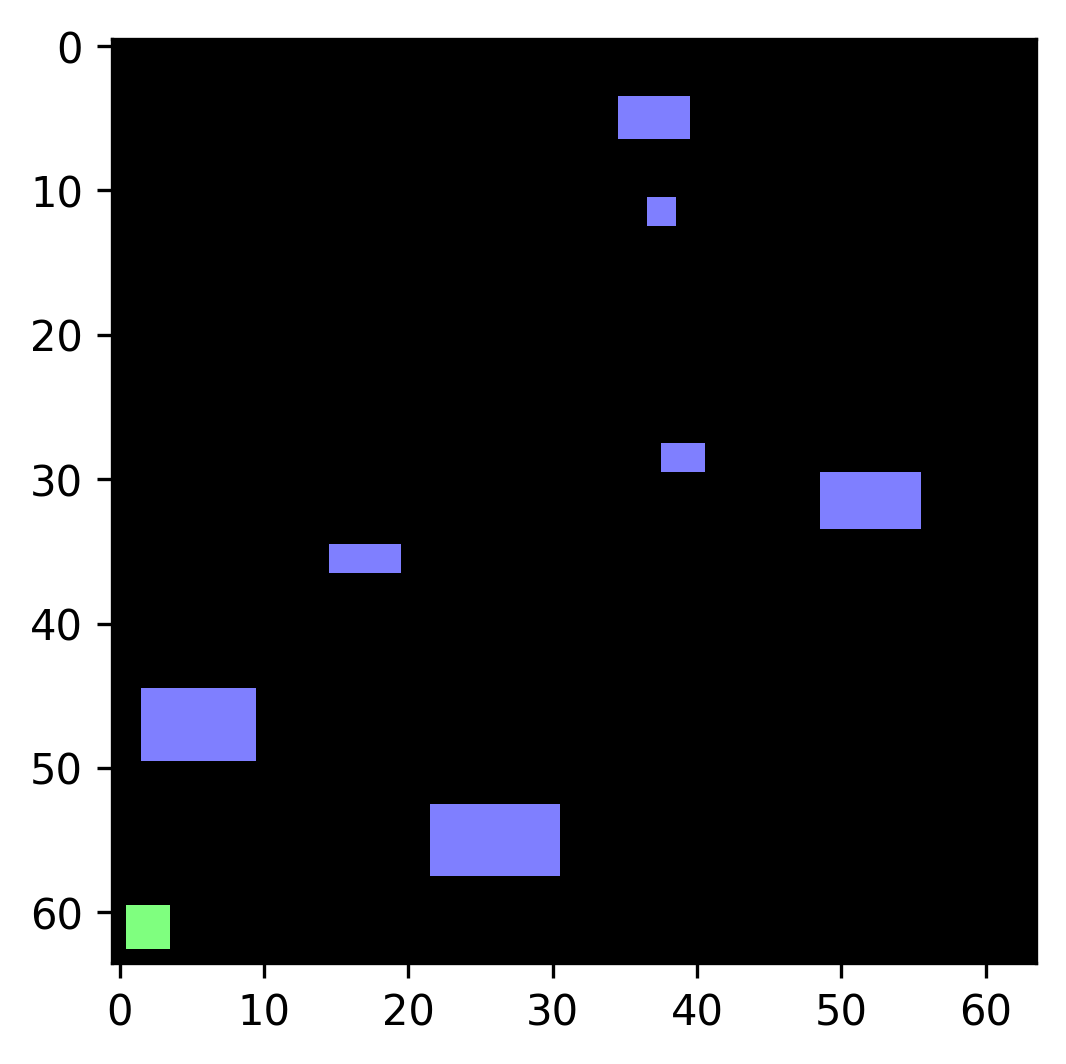

(3, 64, 64)


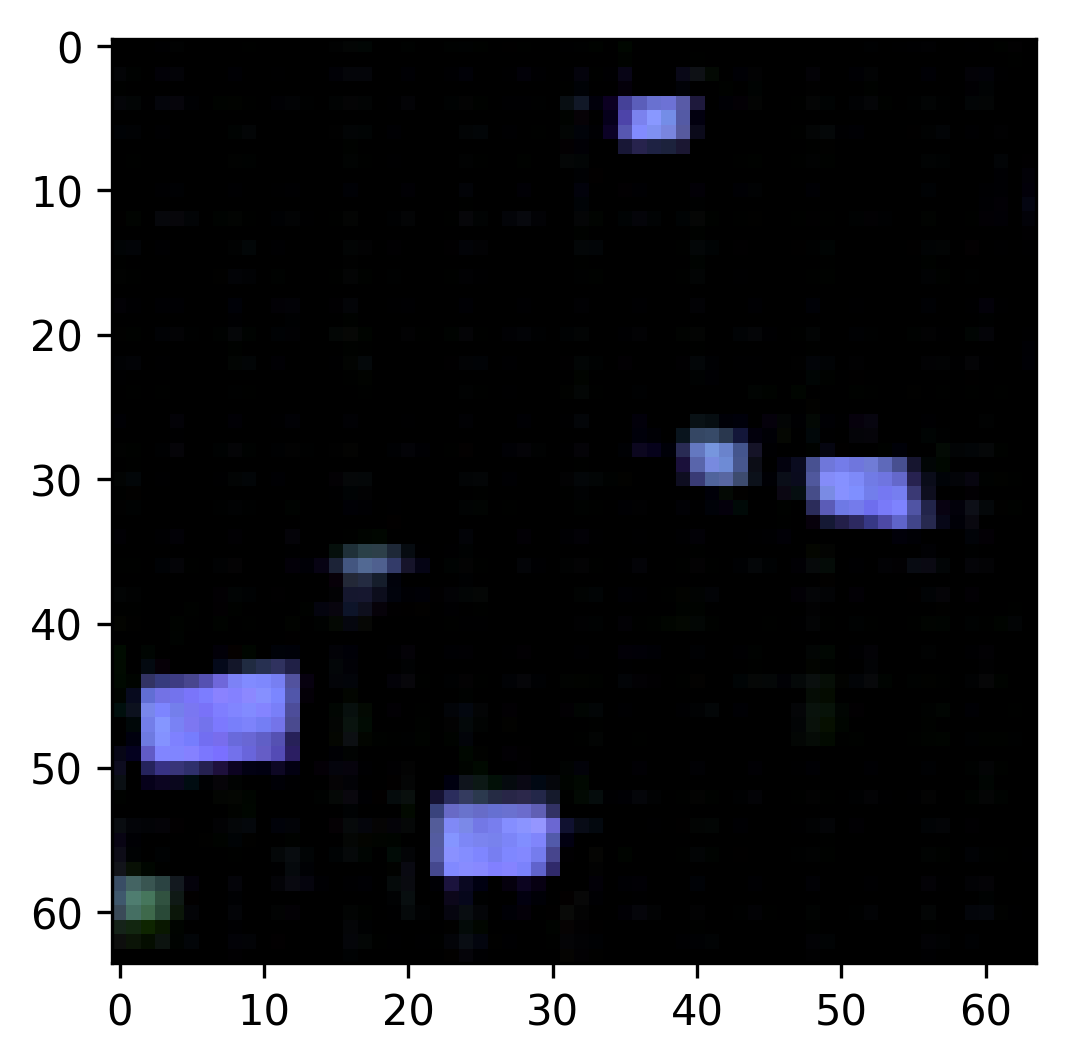

8
repr, std, cov, conv, closs 0.6033005118370056 0.473388671875 6.315717473626137e-05 0.009861971251666546 0.25183671712875366
43.30984299842192 0.01 1.0
repr, std, cov, conv, closs 0.5933855772018433 0.47314453125 6.681936793029308e-05 0.007601376622915268 0.2497563660144806
43.832429113679 0.01 1.0
repr, std, cov, conv, closs 0.6111478805541992 0.472900390625 6.89472071826458e-05 0.0084005668759346 0.2482524812221527
45.076450283898005 0.01 1.0
repr, std, cov, conv, closs 0.6278657913208008 0.473388671875 6.236066110432148e-05 0.00917322002351284 0.2523897886276245
45.89476000660595 0.01 1.0
repr, std, cov, conv, closs 0.587459921836853 0.47314453125 6.548361852765083e-05 0.00750490790233016 0.250740110874176
46.216988724536186 0.01 1.0
repr, std, cov, conv, closs 0.608299195766449 0.4736328125 6.240326911211014e-05 0.007741858717054129 0.24756890535354614
46.58802130140587 0.01 1.0
repr, std, cov, conv, closs 0.5802774429321289 0.473876953125 5.886005237698555e-05 0.0074212355539202

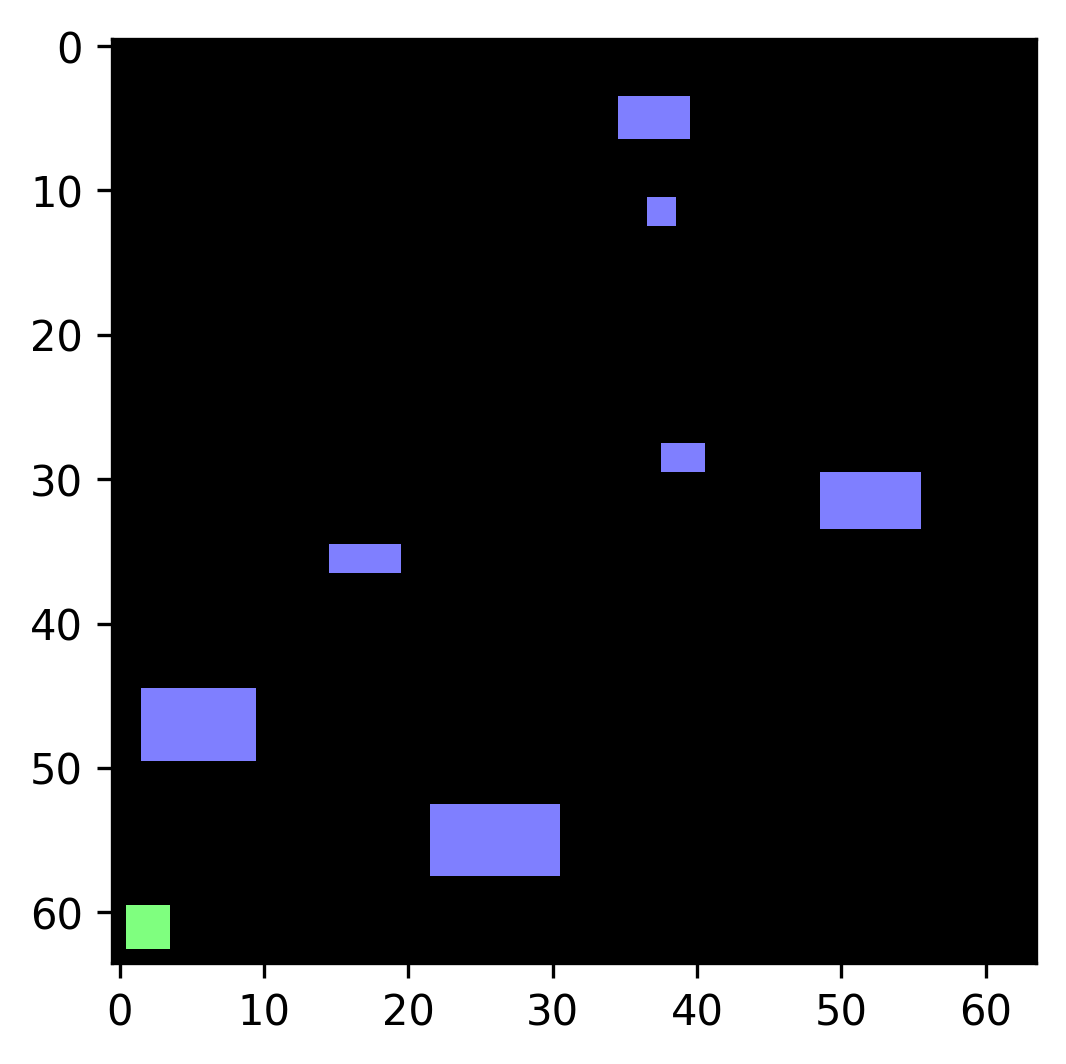

(3, 64, 64)


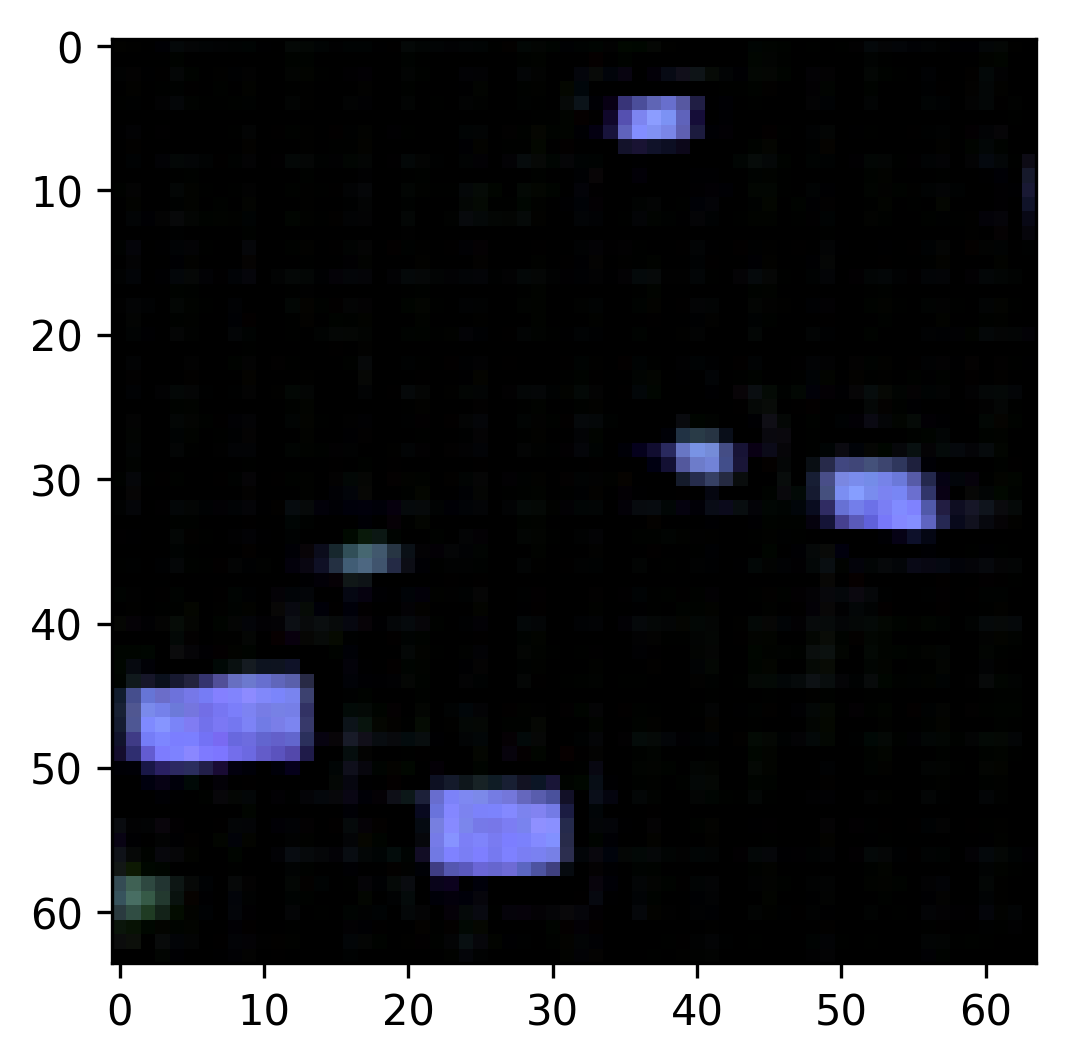

9
repr, std, cov, conv, closs 0.6350895166397095 0.47265625 7.169810123741627e-05 0.00880497507750988 0.2479727417230606
76.17989771290397 0.01 1.0
repr, std, cov, conv, closs 0.6293965578079224 0.472412109375 7.59749673306942e-05 0.00871795043349266 0.2564318776130676
77.5628537926473 0.01 1.0
repr, std, cov, conv, closs 0.620398998260498 0.472412109375 7.693166844546795e-05 0.008373431861400604 0.24494263529777527
79.92379628972203 0.01 1.0
repr, std, cov, conv, closs 0.6422574520111084 0.472900390625 6.871623918414116e-05 0.00900815986096859 0.256170392036438
81.37471842684008 0.01 1.0
repr, std, cov, conv, closs 0.6075250506401062 0.472412109375 7.416051812469959e-05 0.007603725418448448 0.24995706975460052
83.26706959236505 0.01 1.0
repr, std, cov, conv, closs 0.6107754111289978 0.473388671875 6.510643288493156e-05 0.008130373433232307 0.24146920442581177
84.44041626272156 0.01 1.0
repr, std, cov, conv, closs 0.5804675817489624 0.473388671875 6.419047713279724e-05 0.00672843074426

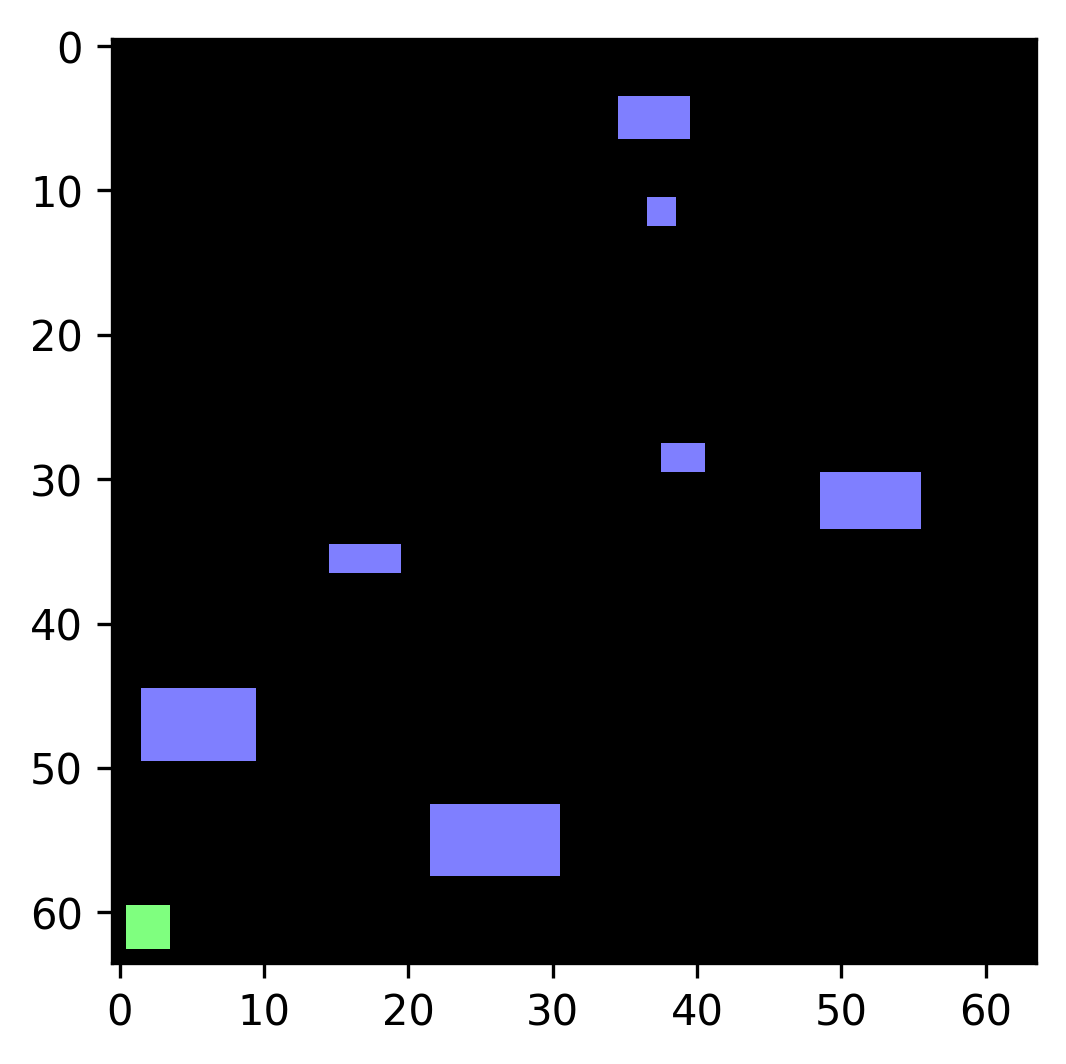

(3, 64, 64)


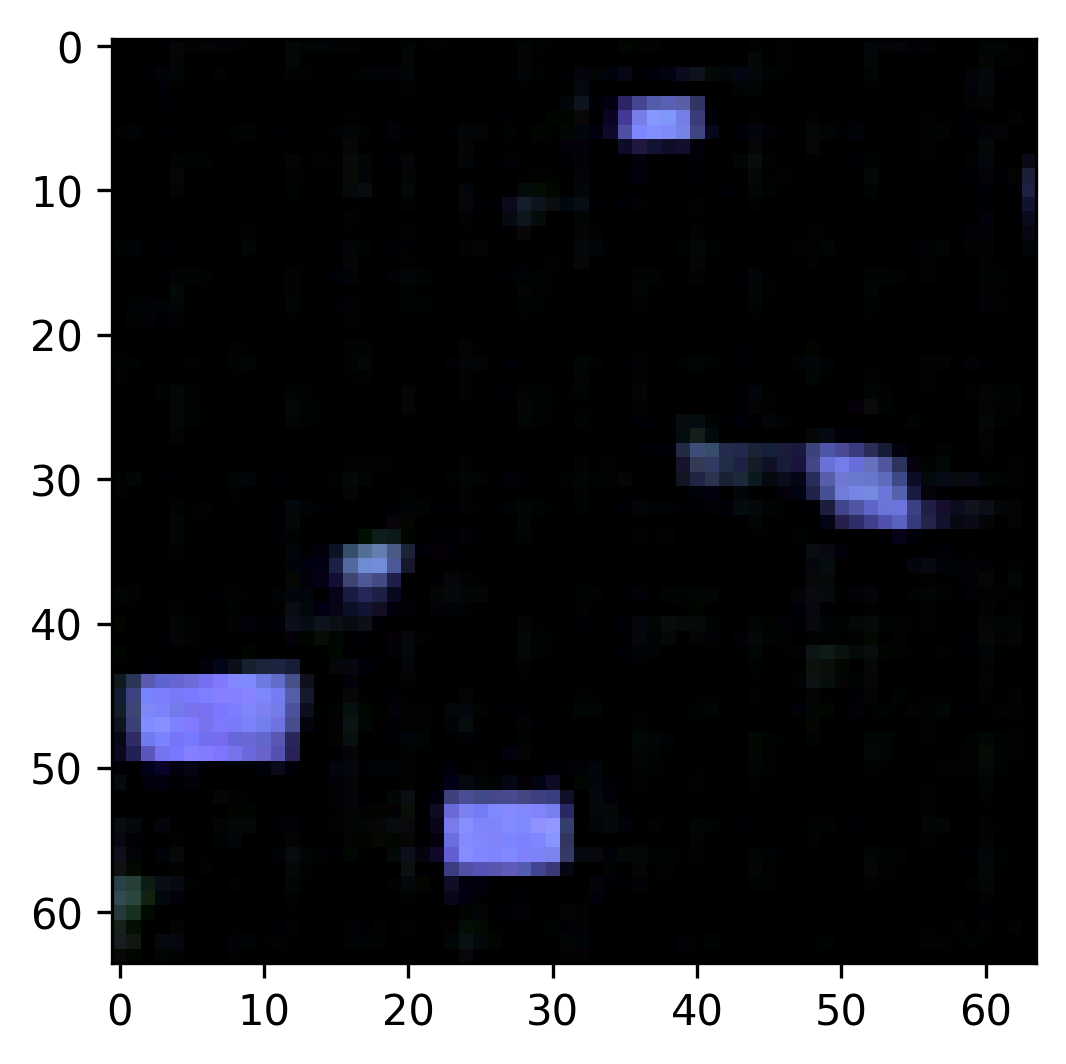

10
repr, std, cov, conv, closs 0.6003279089927673 0.4736328125 6.151595152914524e-05 0.007029994390904903 0.2496025711297989
132.53155961988796 0.009990009990009992 1.0
repr, std, cov, conv, closs 0.6014643311500549 0.47412109375 5.631544627249241e-05 0.007493268232792616 0.25020116567611694
132.79675527068733 0.009990009990009992 1.0
repr, std, cov, conv, closs 0.5903726816177368 0.473388671875 6.310315802693367e-05 0.007933994755148888 0.2509734630584717
134.53350931111004 0.009990009990009992 1.0
repr, std, cov, conv, closs 0.6032720804214478 0.473388671875 6.25276006758213e-05 0.00835803896188736 0.25017303228378296
134.53350931111004 0.009990009990009992 1.0
repr, std, cov, conv, closs 0.6199018955230713 0.474609375 5.2024610340595245e-05 0.009057966992259026 0.2497028410434723
138.90598238092875 0.009990009990009992 1.0
repr, std, cov, conv, closs 0.6202191114425659 0.4736328125 5.929078906774521e-05 0.008808428421616554 0.2495717704296112
140.16114852334482 0.009990009990009992 

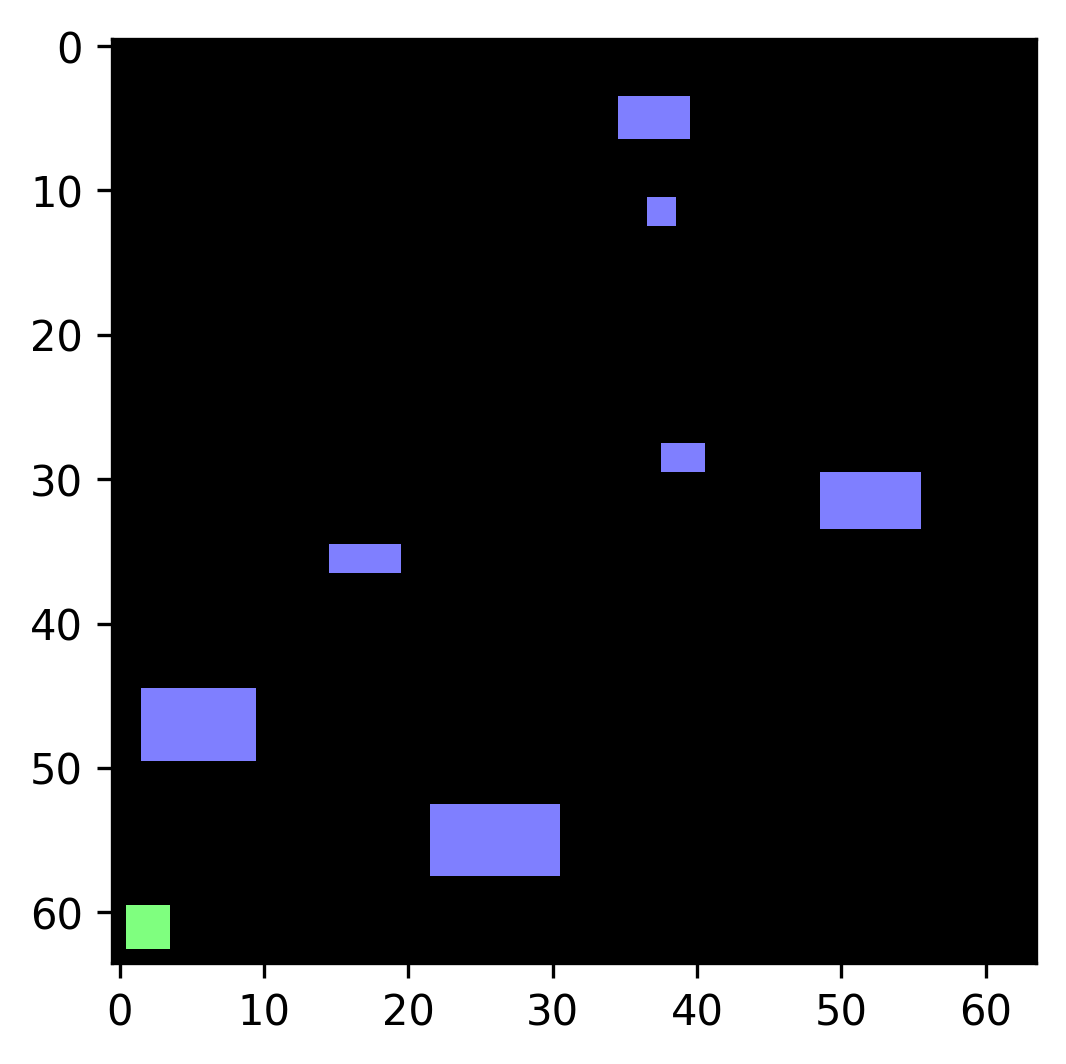

(3, 64, 64)


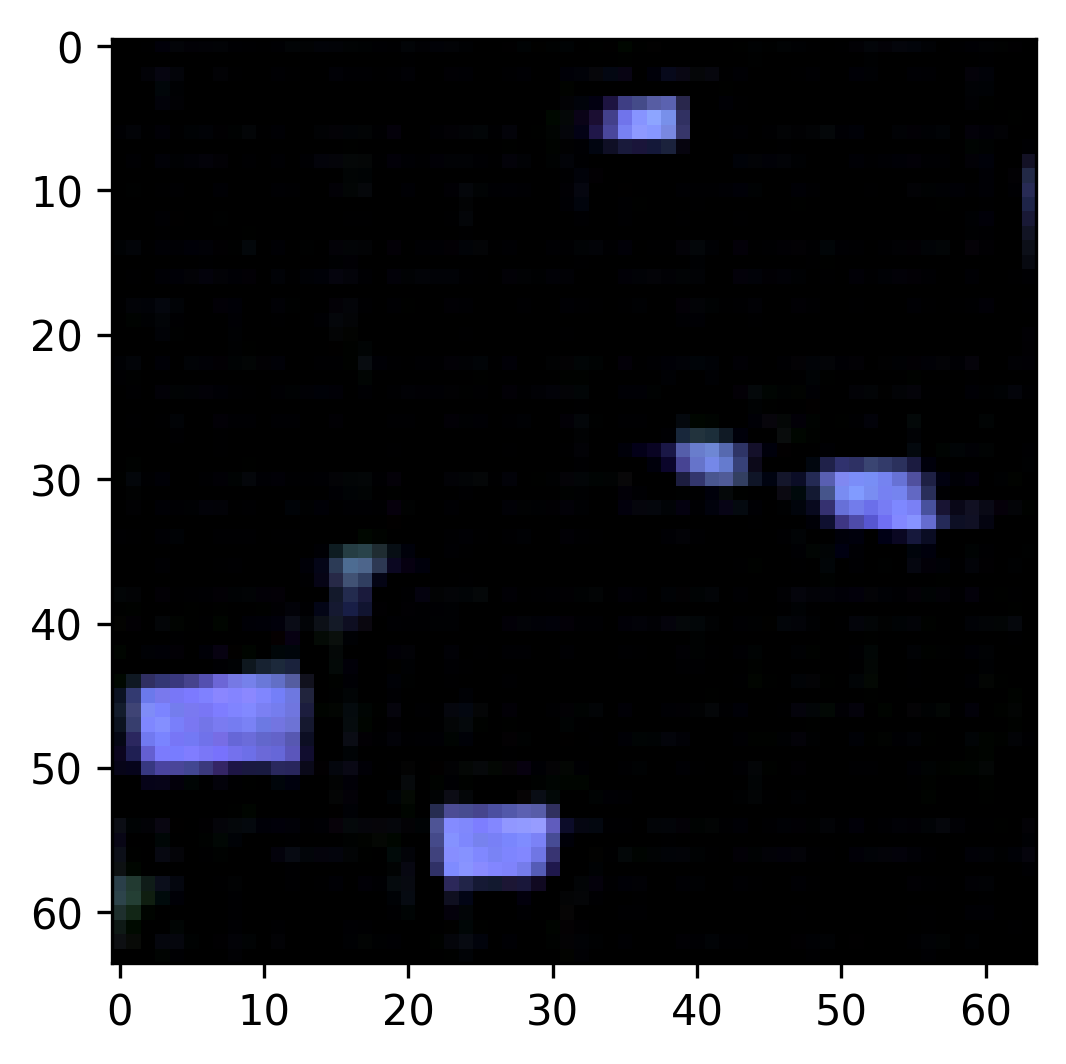

11
repr, std, cov, conv, closs 0.5935195684432983 0.474853515625 5.139084532856941e-05 0.009089101105928421 0.249824658036232
161.21241901796097 0.009493535332711795 1.0
repr, std, cov, conv, closs 0.5630097389221191 0.473876953125 5.988008342683315e-05 0.006912247743457556 0.2490546852350235
161.21241901796097 0.009493535332711795 1.0
repr, std, cov, conv, closs 0.5937780141830444 0.47412109375 5.618855357170105e-05 0.007522454019635916 0.2507513165473938
161.85823661355775 0.009493535332711795 1.0
repr, std, cov, conv, closs 0.61139976978302 0.47314453125 6.376951932907104e-05 0.007381556089967489 0.2561095356941223
163.81125378559696 0.009493535332711795 1.0
repr, std, cov, conv, closs 0.6114028096199036 0.473388671875 6.38302881270647e-05 0.01027245819568634 0.24741360545158386
165.4567575216652 0.00944620972746785 1.0
repr, std, cov, conv, closs 0.6112165451049805 0.47314453125 6.681703962385654e-05 0.008844368159770966 0.2529805302619934
167.28590933110928 0.009389730311707426 1.

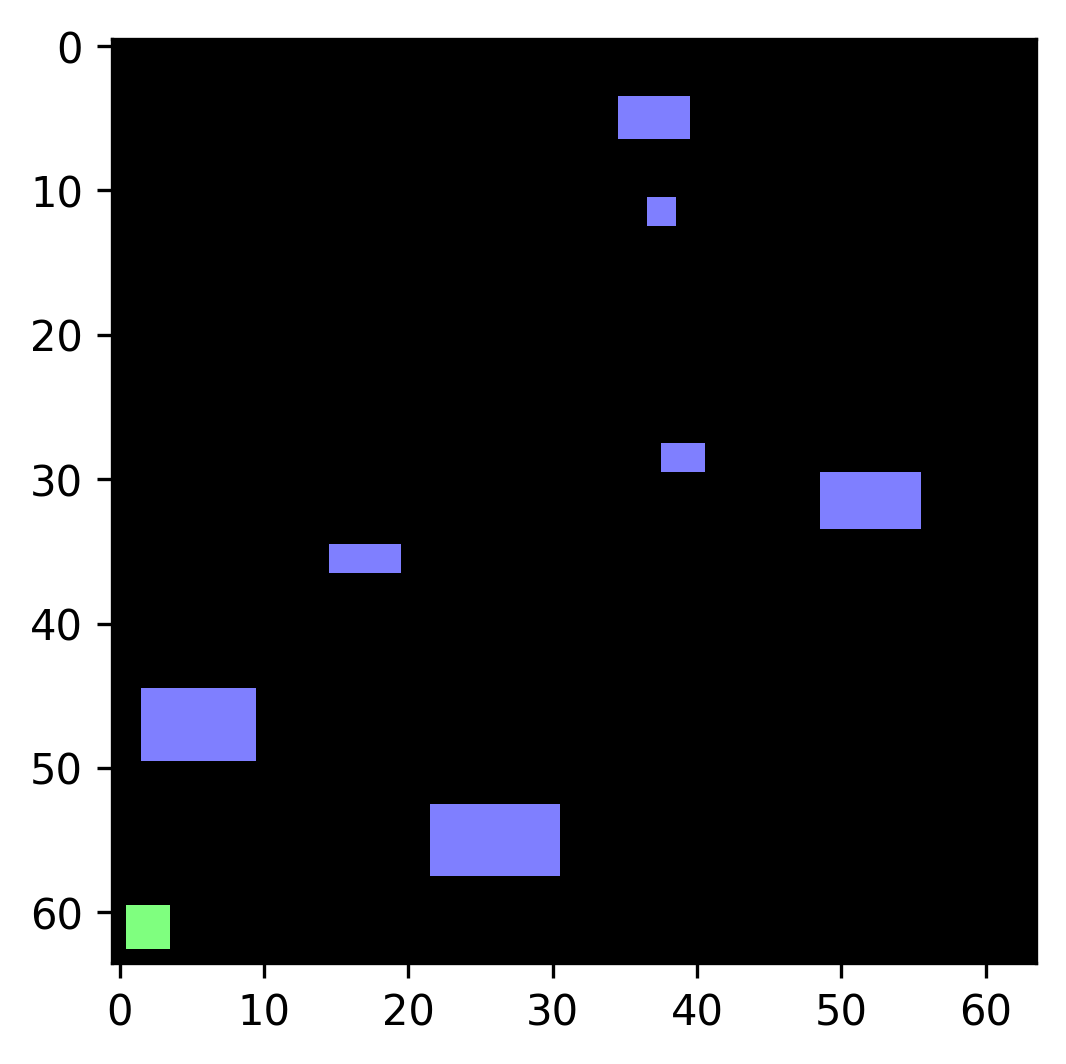

(3, 64, 64)


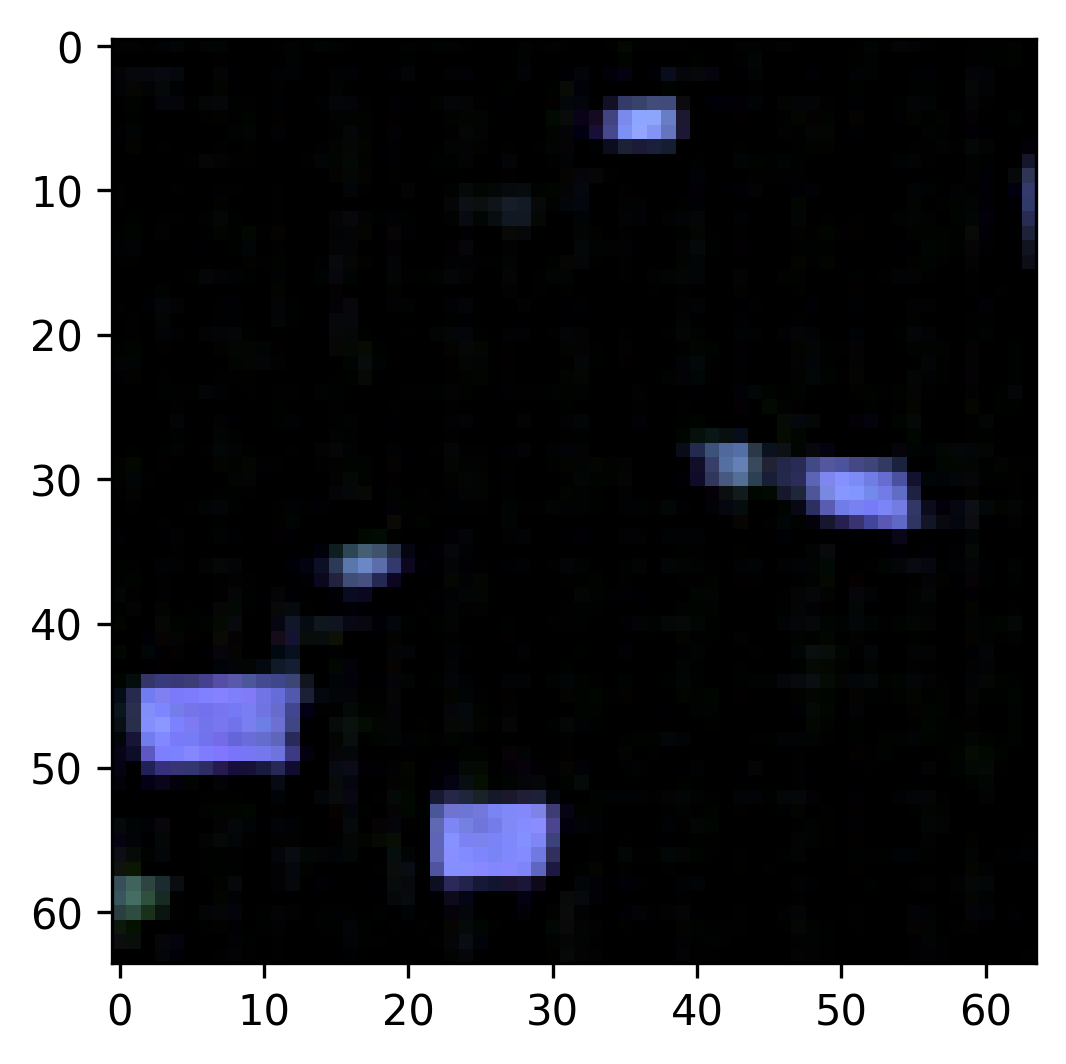

12
repr, std, cov, conv, closs 0.5625288486480713 0.4736328125 6.564822979271412e-05 0.007146107032895088 0.24798965454101562
183.76493464932815 0.008799096540482219 1.0
repr, std, cov, conv, closs 0.5976724028587341 0.4736328125 6.060861051082611e-05 0.007675169967114925 0.24946004152297974
182.66619383733175 0.008720299183455531 1.0
repr, std, cov, conv, closs 0.5904220342636108 0.473876953125 5.831359885632992e-05 0.008094782941043377 0.2522483468055725
187.47535906512053 0.008720299183455531 1.0
repr, std, cov, conv, closs 0.5854511260986328 0.474853515625 5.079945549368858e-05 0.007611581590026617 0.24917957186698914
188.41461248972783 0.008720299183455531 1.0
repr, std, cov, conv, closs 0.5749067068099976 0.474609375 5.1579903811216354e-05 0.007163922302424908 0.24968712031841278
193.76206348560896 0.008720299183455531 1.0
repr, std, cov, conv, closs 0.5859535336494446 0.47509765625 4.801223985850811e-05 0.007650656159967184 0.25046205520629883
194.92754617562363 0.00872029918345

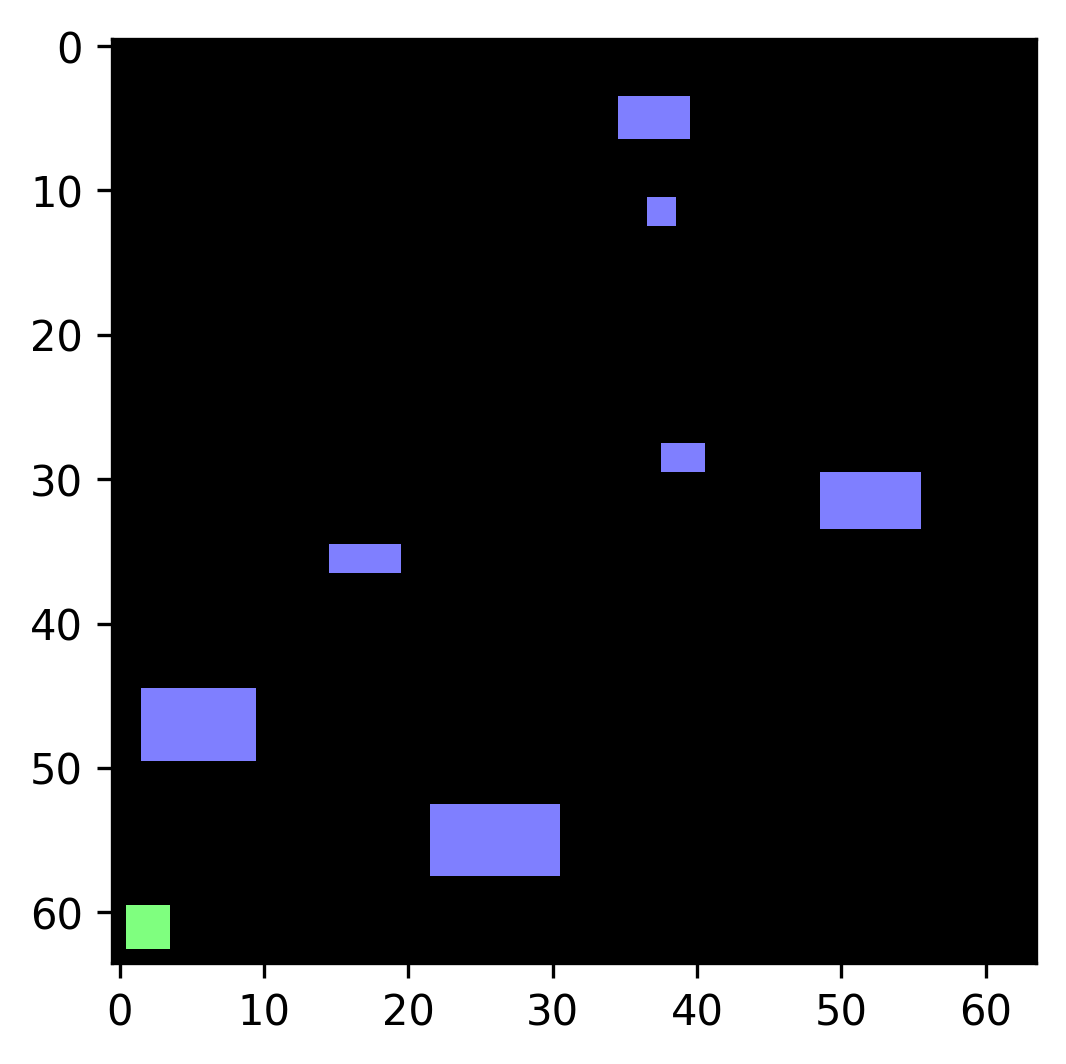

(3, 64, 64)


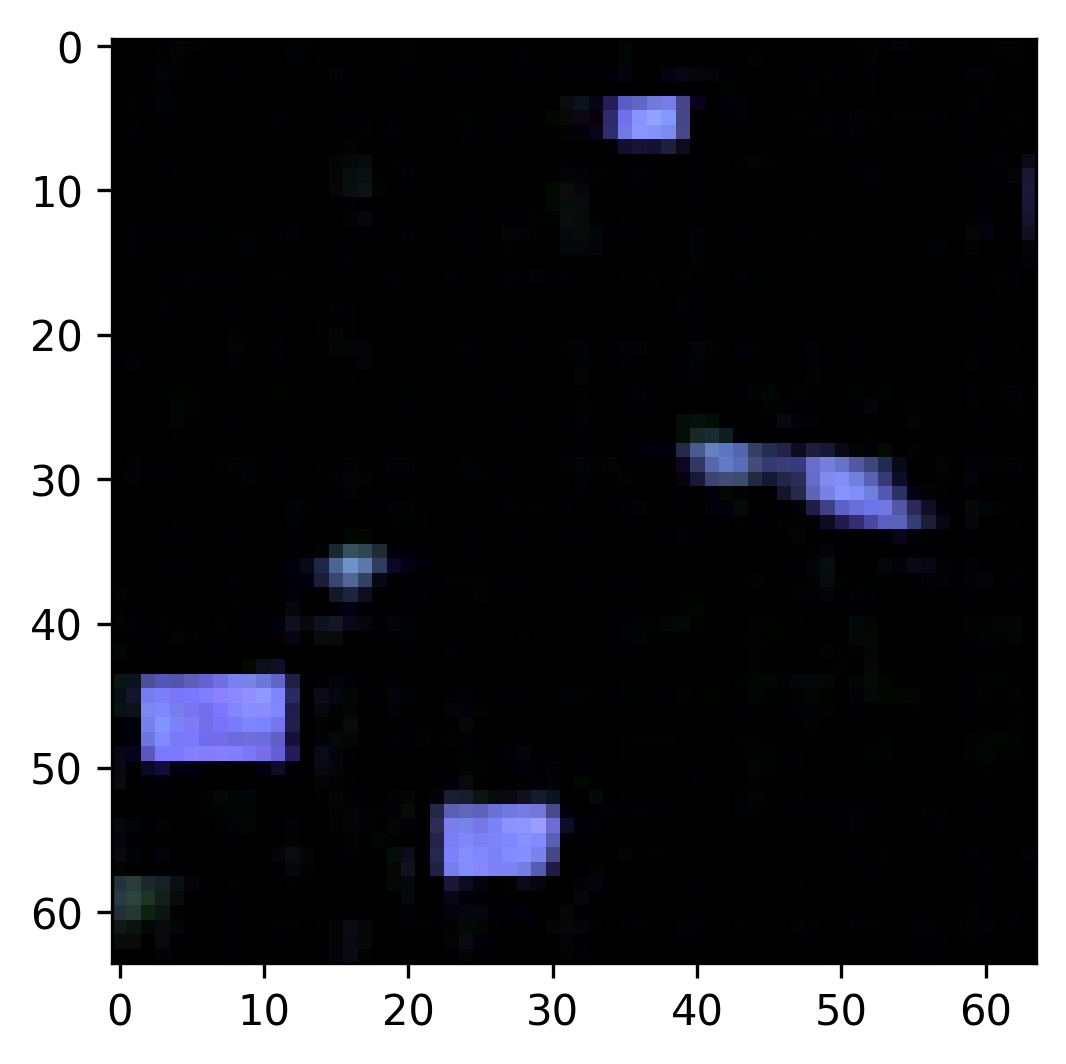

13
repr, std, cov, conv, closs 0.6076482534408569 0.475830078125 4.124338738620281e-05 0.00988570787012577 0.25166603922843933
244.57316489013942 0.008155454971758154 1.0
repr, std, cov, conv, closs 0.592302143573761 0.4755859375 4.307250492274761e-05 0.007597482763230801 0.2516288161277771
248.01953462654615 0.008155454971758154 1.0
repr, std, cov, conv, closs 0.586952805519104 0.47509765625 4.869257099926472e-05 0.007579424884170294 0.25320738554000854
254.80384674809392 0.008155454971758154 1.0
repr, std, cov, conv, closs 0.5801727175712585 0.475341796875 4.7788023948669434e-05 0.007333909627050161 0.25117406249046326
254.80384674809392 0.008155454971758154 1.0
repr, std, cov, conv, closs 0.5708576440811157 0.4755859375 4.304060712456703e-05 0.007075855042785406 0.25082290172576904
254.80384674809392 0.008155454971758154 1.0
repr, std, cov, conv, closs 0.5942201018333435 0.475830078125 4.045991227030754e-05 0.008692971430718899 0.24963034689426422
255.82459197763686 0.00815545497175

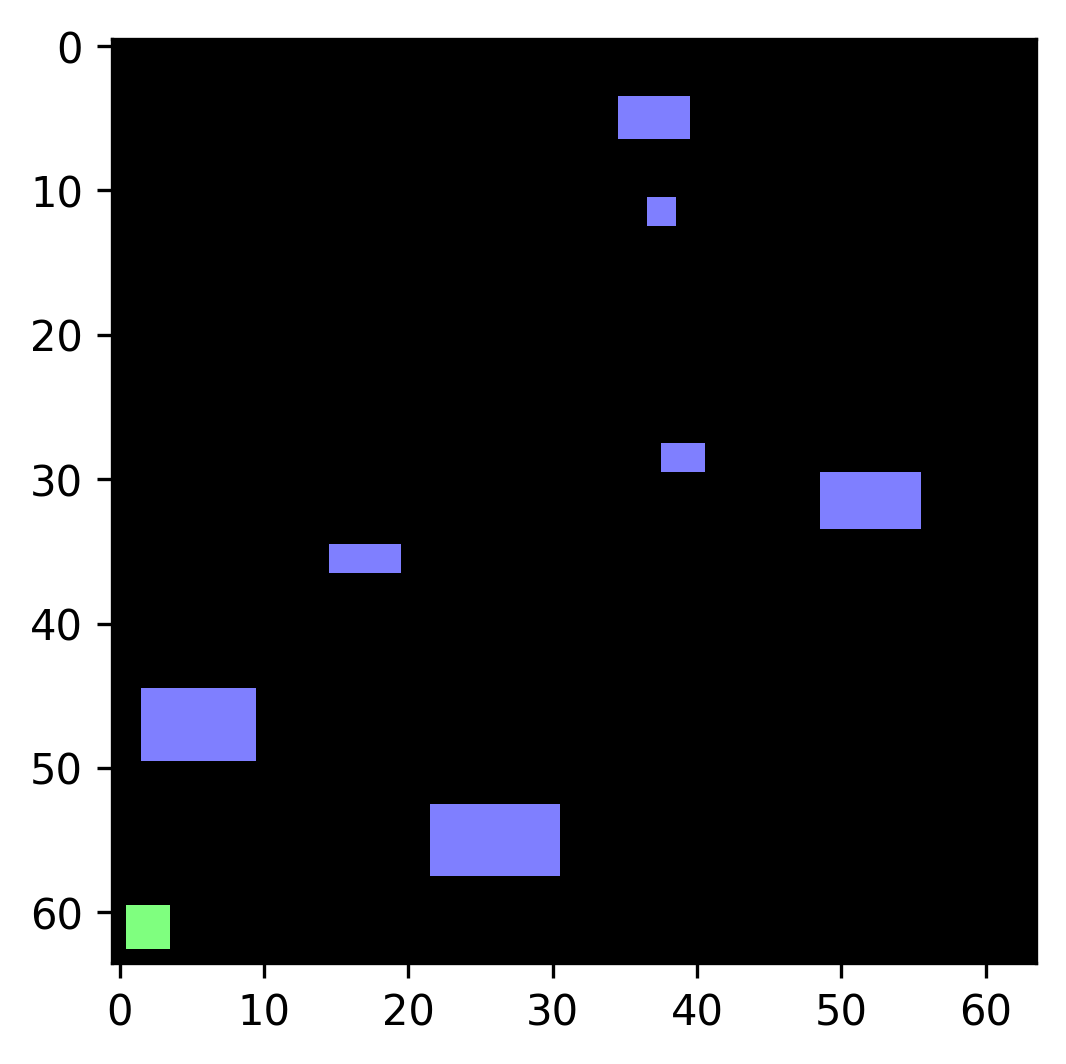

(3, 64, 64)


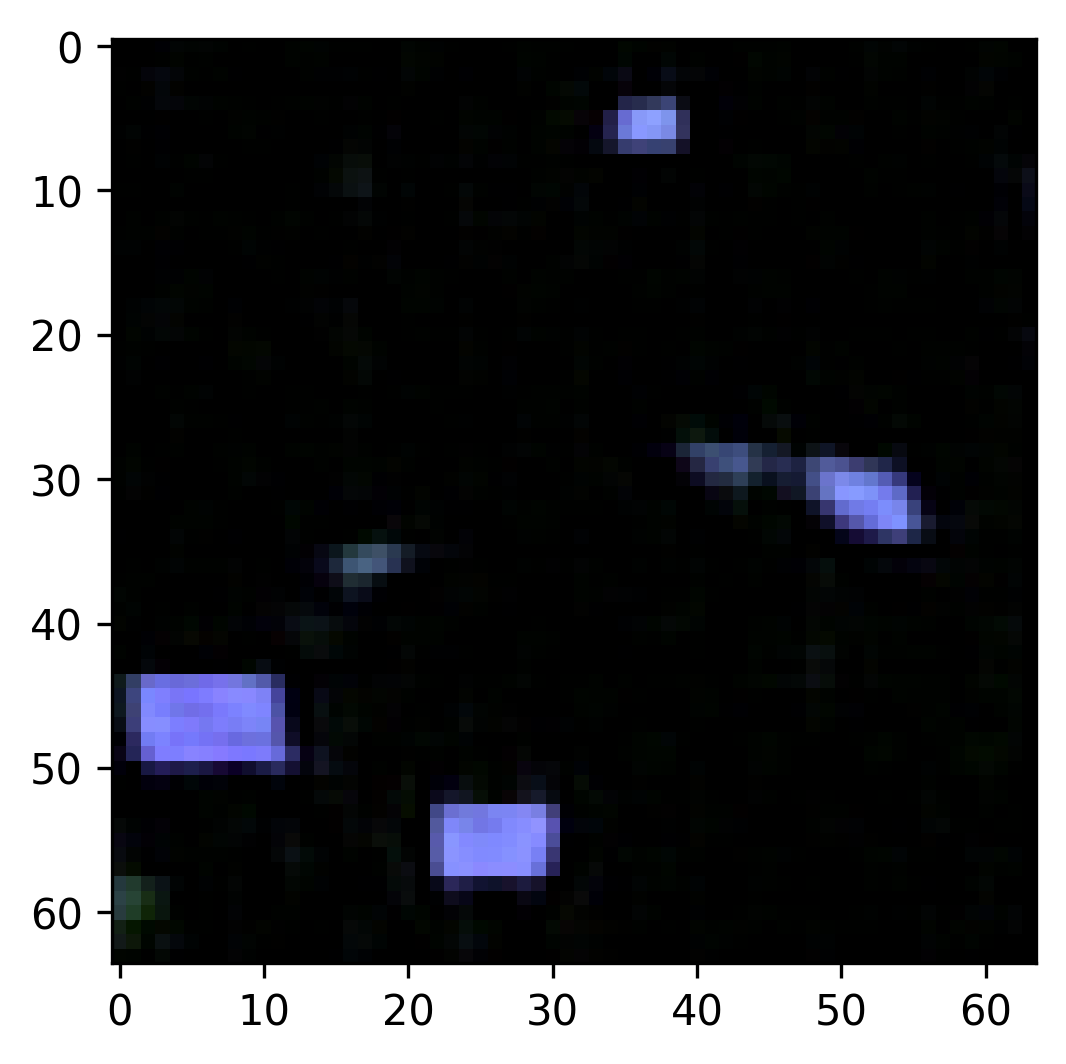

14
repr, std, cov, conv, closs 0.5691284537315369 0.475341796875 4.469696432352066e-05 0.007737250998616219 0.2472117394208908
301.391497769749 0.00761196614668242 1.0
repr, std, cov, conv, closs 0.5549255609512329 0.474609375 5.0761736929416656e-05 0.00711060082539916 0.2472391426563263
300.789617744642 0.0075967650198776465 1.0
repr, std, cov, conv, closs 0.5537177324295044 0.475341796875 4.6972883865237236e-05 0.00653960881754756 0.25192394852638245
299.58946116455945 0.0075664537757785 1.0
repr, std, cov, conv, closs 0.5777970552444458 0.47607421875 3.940984606742859e-05 0.006900648586452007 0.24882306158542633
299.58946116455945 0.0075664537757785 1.0
repr, std, cov, conv, closs 0.5715959072113037 0.475830078125 4.225596785545349e-05 0.008799411356449127 0.2500656247138977
299.58946116455945 0.0075664537757785 1.0
repr, std, cov, conv, closs 0.5815609693527222 0.475830078125 4.1664810851216316e-05 0.007756752893328667 0.24966371059417725
299.889050625724 0.0075664537757785 1.0
rep

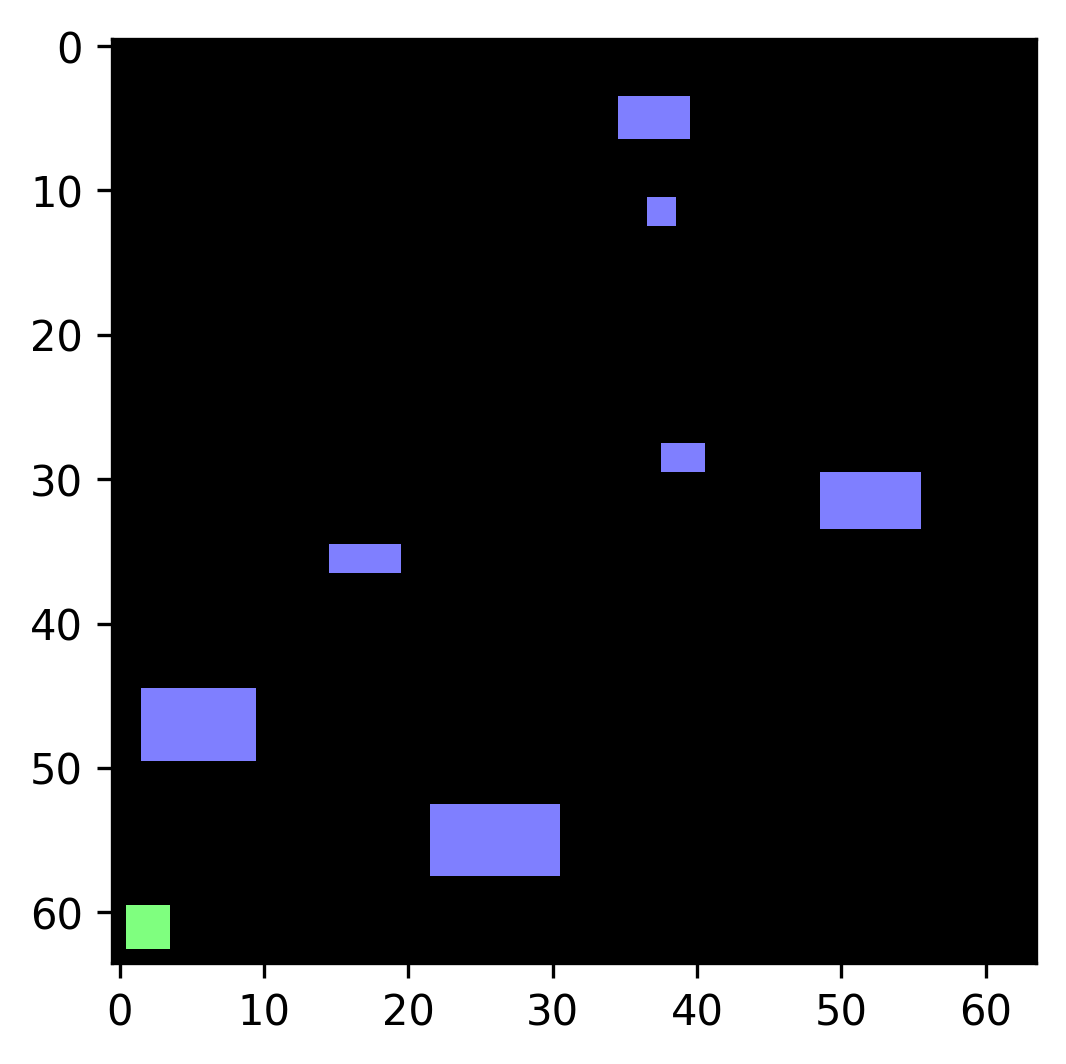

(3, 64, 64)


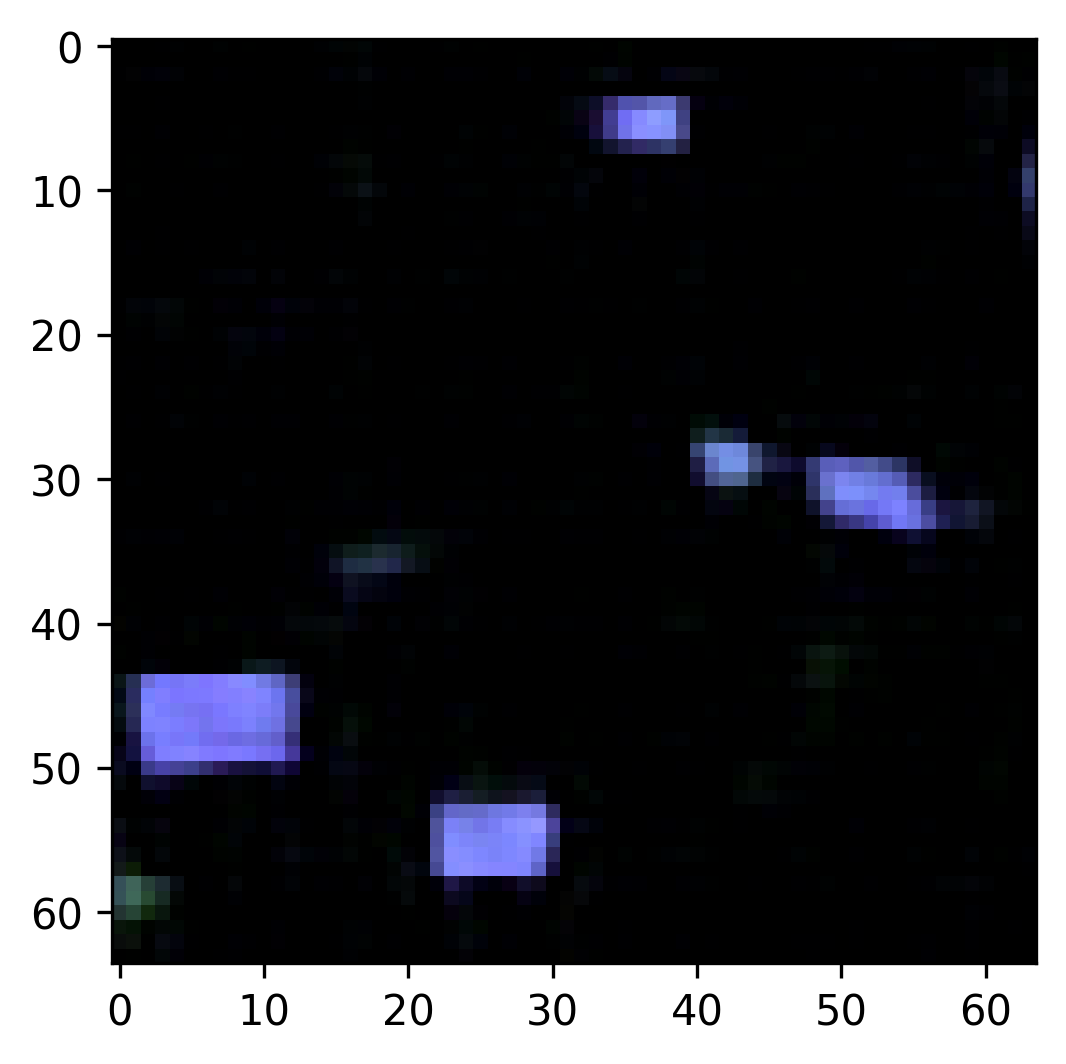

15
repr, std, cov, conv, closs 0.5808470845222473 0.476806640625 3.480887971818447e-05 0.008380132727324963 0.25118640065193176
359.3590885715506 0.007255396131914282 1.0
repr, std, cov, conv, closs 0.5891988277435303 0.4765625 3.5835662856698036e-05 0.008340058848261833 0.24980294704437256
365.88282844613 0.007255396131914282 1.0
repr, std, cov, conv, closs 0.581503689289093 0.475830078125 4.1745370253920555e-05 0.007359727751463652 0.2500431537628174
365.51731113499505 0.007183239626368374 1.0
repr, std, cov, conv, closs 0.5823369026184082 0.4755859375 4.355260170996189e-05 0.00675508938729763 0.24947087466716766
363.6951945714216 0.007090507930686744 1.0
repr, std, cov, conv, closs 0.575429379940033 0.4755859375 4.295911639928818e-05 0.007399755530059338 0.24989736080169678
371.7810652025728 0.007090507930686744 1.0
repr, std, cov, conv, closs 0.5827588438987732 0.475830078125 4.22594603151083e-05 0.007931530475616455 0.2495865672826767
372.52499911404306 0.007090507930686744 1.0
re

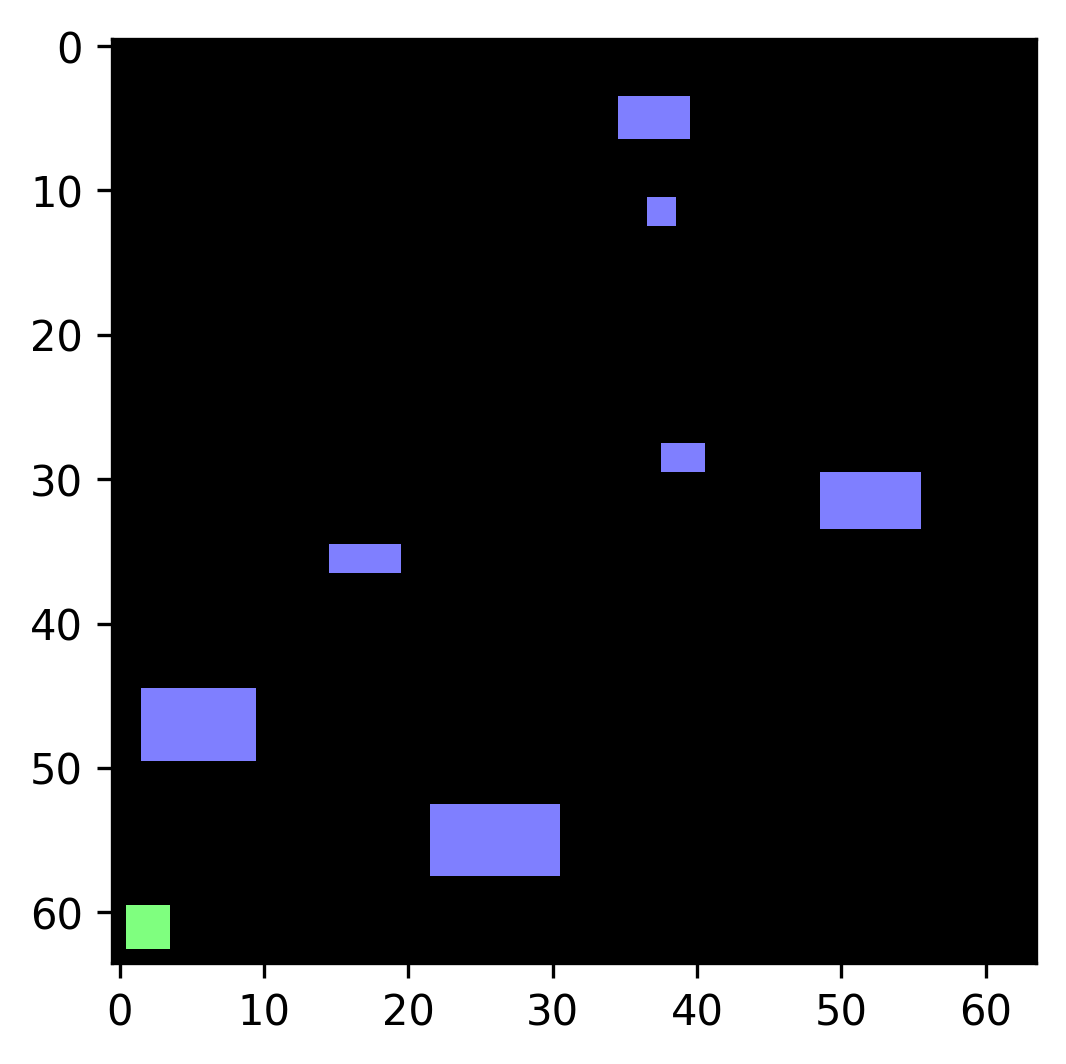

(3, 64, 64)


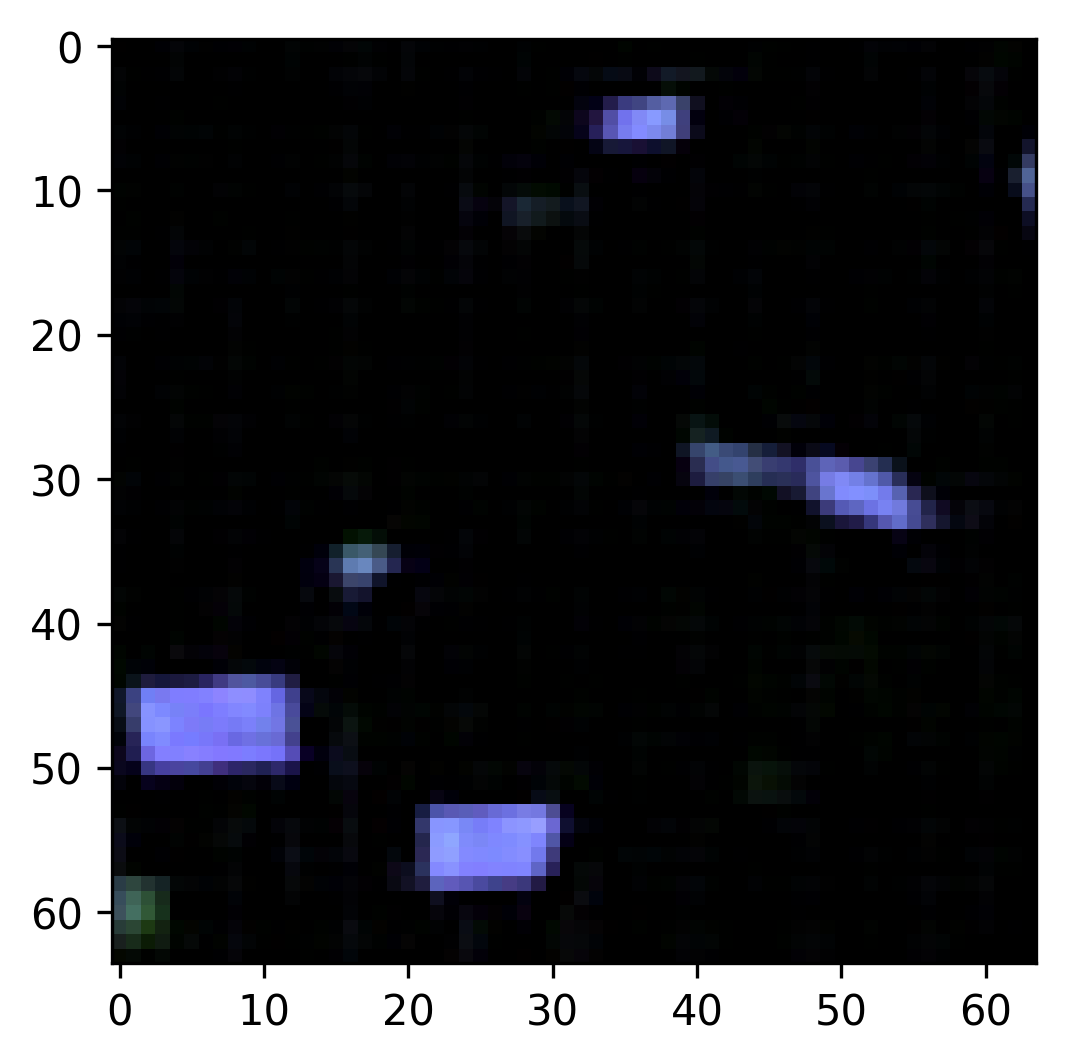

16
repr, std, cov, conv, closs 0.5688287019729614 0.476806640625 3.696652129292488e-05 0.008308101445436478 0.2544209957122803
416.65068487333474 0.00644822208304261 1.0
repr, std, cov, conv, closs 0.5766912698745728 0.476806640625 3.491947427392006e-05 0.00874304212629795 0.25110507011413574
419.99557993312476 0.00644822208304261 1.0
repr, std, cov, conv, closs 0.5776805877685547 0.47705078125 3.218301571905613e-05 0.008677041158080101 0.2506946325302124
433.6458546647064 0.00644822208304261 1.0
repr, std, cov, conv, closs 0.5972498655319214 0.477783203125 2.9223738238215446e-05 0.010360841639339924 0.2505802810192108
441.51818305013114 0.00644822208304261 1.0
repr, std, cov, conv, closs 0.5854529142379761 0.47705078125 3.3718766644597054e-05 0.008900763466954231 0.2496778964996338
455.8679638230211 0.00644822208304261 1.0
repr, std, cov, conv, closs 0.5874851942062378 0.47705078125 3.481656312942505e-05 0.007784578017890453 0.24843847751617432
464.1437083574283 0.00644822208304261 1.

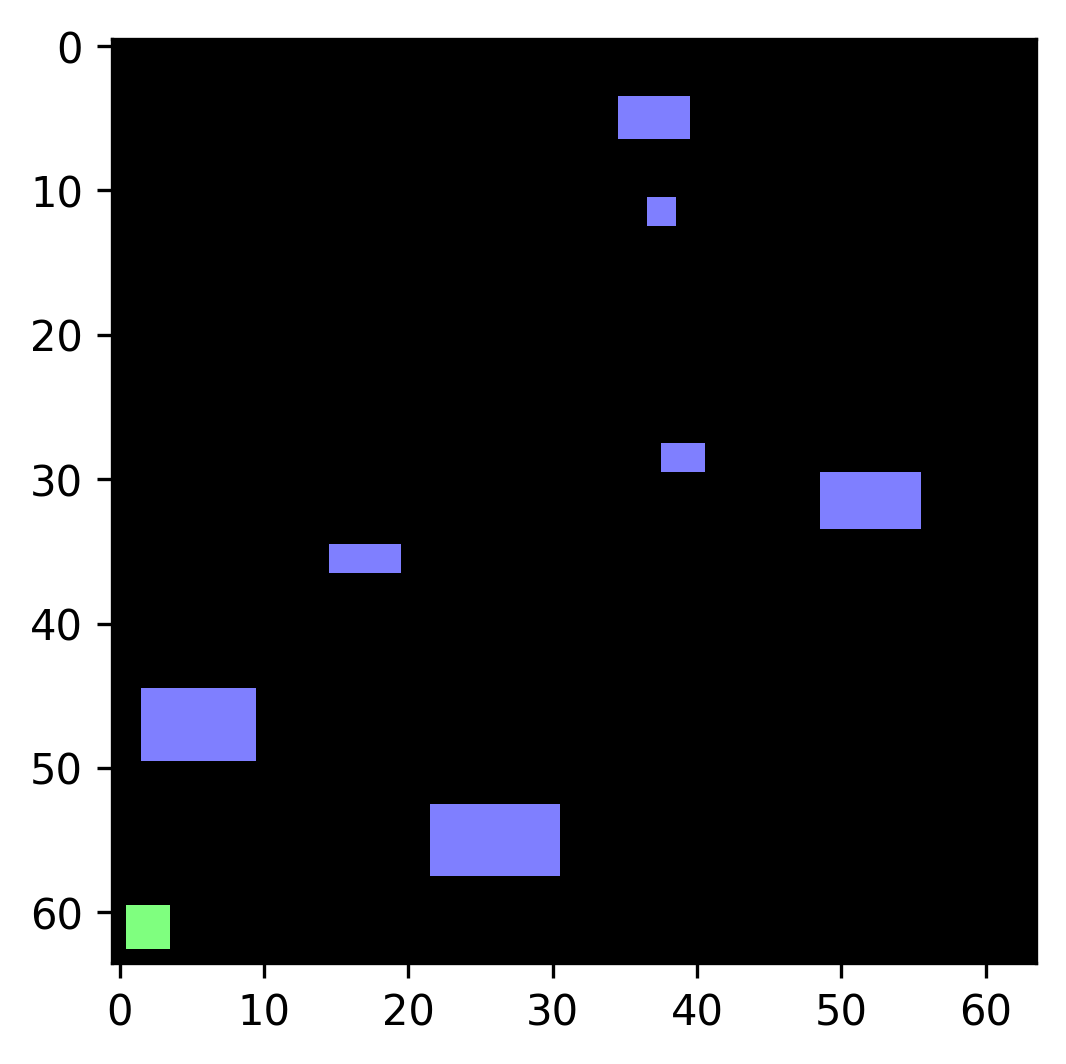

(3, 64, 64)


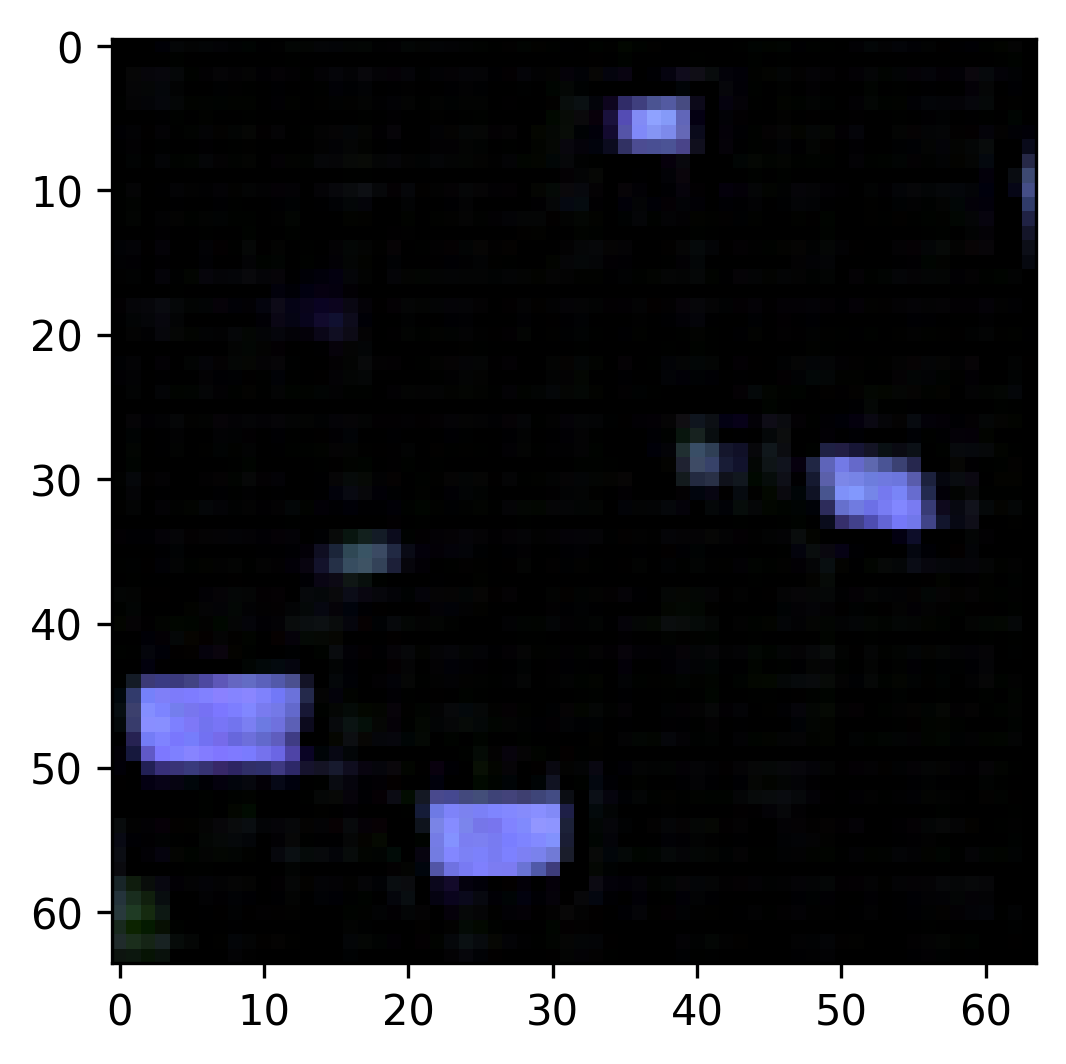

17
repr, std, cov, conv, closs 0.5484517812728882 0.4775390625 3.130454570055008e-05 0.006771334446966648 0.25039148330688477
637.8067427974149 0.0062390063803167434 1.0
repr, std, cov, conv, closs 0.5581016540527344 0.4775390625 3.093155100941658e-05 0.006948649883270264 0.25000375509262085
637.8067427974149 0.0062390063803167434 1.0
repr, std, cov, conv, closs 0.5559897422790527 0.476806640625 3.5004690289497375e-05 0.006604383699595928 0.2500823736190796
637.8067427974149 0.0062390063803167434 1.0
repr, std, cov, conv, closs 0.5644698143005371 0.477294921875 3.216788172721863e-05 0.007367739453911781 0.24997097253799438
637.8067427974149 0.0062390063803167434 1.0
repr, std, cov, conv, closs 0.559417724609375 0.477294921875 3.1751347705721855e-05 0.0069513870403170586 0.2500084638595581
636.5330401840068 0.006226547059650384 1.0
repr, std, cov, conv, closs 0.5931247472763062 0.477294921875 3.135437145829201e-05 0.008861739188432693 0.24987617135047913
646.7943104115502 0.006226547059

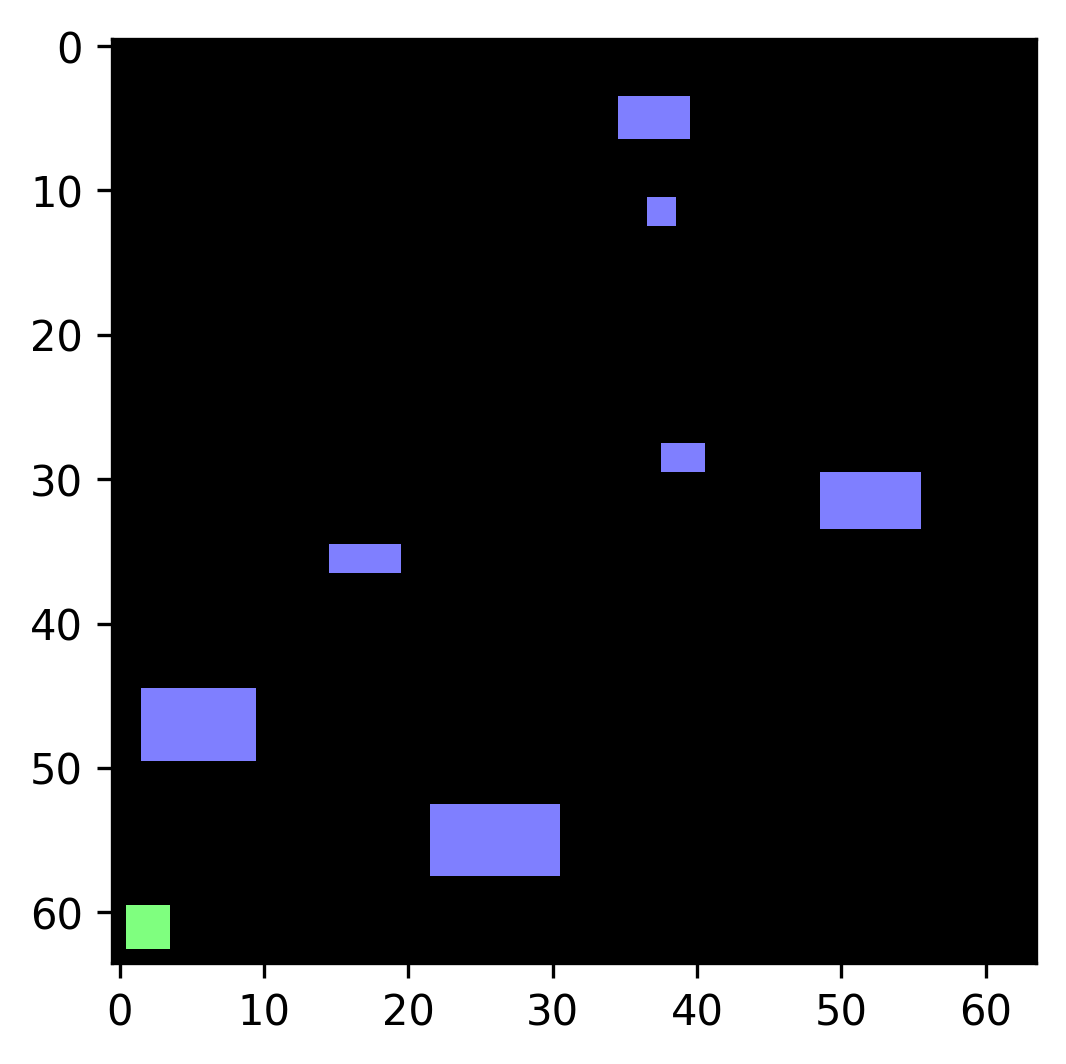

(3, 64, 64)


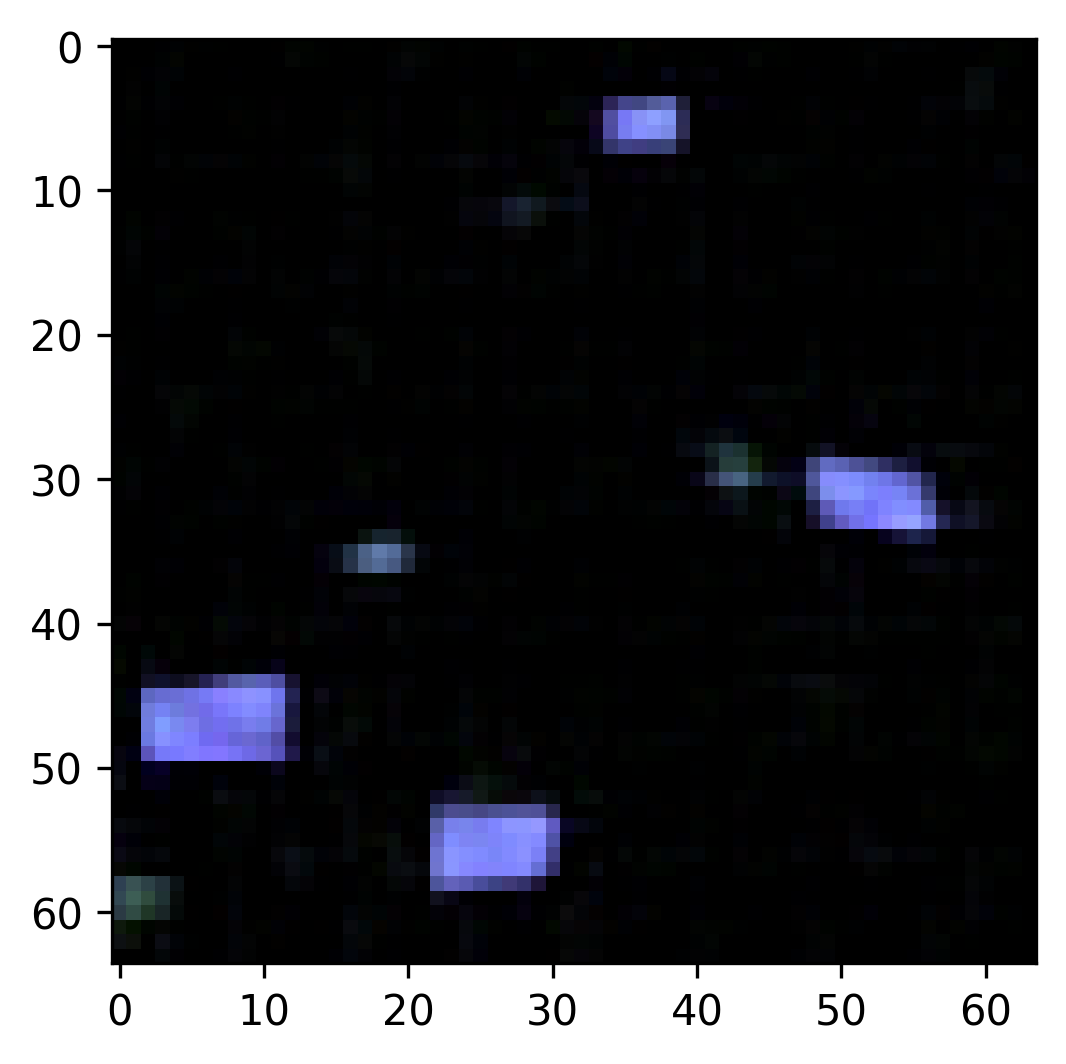

18
repr, std, cov, conv, closs 0.5676798820495605 0.47802734375 2.7834903448820114e-05 0.007914411835372448 0.23986521363258362
865.9978521869162 0.005811602858812175 1.0
repr, std, cov, conv, closs 0.5416702032089233 0.477294921875 3.286194987595081e-05 0.00706196716055274 0.25625598430633545
868.5984446030311 0.005811602858812175 1.0
repr, std, cov, conv, closs 0.5640806555747986 0.4775390625 3.075646236538887e-05 0.007922148331999779 0.24913643300533295
866.8638500391031 0.0057480571368355195 1.0
repr, std, cov, conv, closs 0.5697383284568787 0.477783203125 2.800743095576763e-05 0.007729340344667435 0.24921248853206635
880.8381823269735 0.0057480571368355195 1.0
repr, std, cov, conv, closs 0.5536909103393555 0.478271484375 2.5985296815633774e-05 0.0072455937042832375 0.25227090716362
880.8381823269735 0.0057480571368355195 1.0
repr, std, cov, conv, closs 0.5640015602111816 0.477783203125 2.800137735903263e-05 0.008241753093898296 0.24009864032268524
880.8381823269735 0.0057480571368

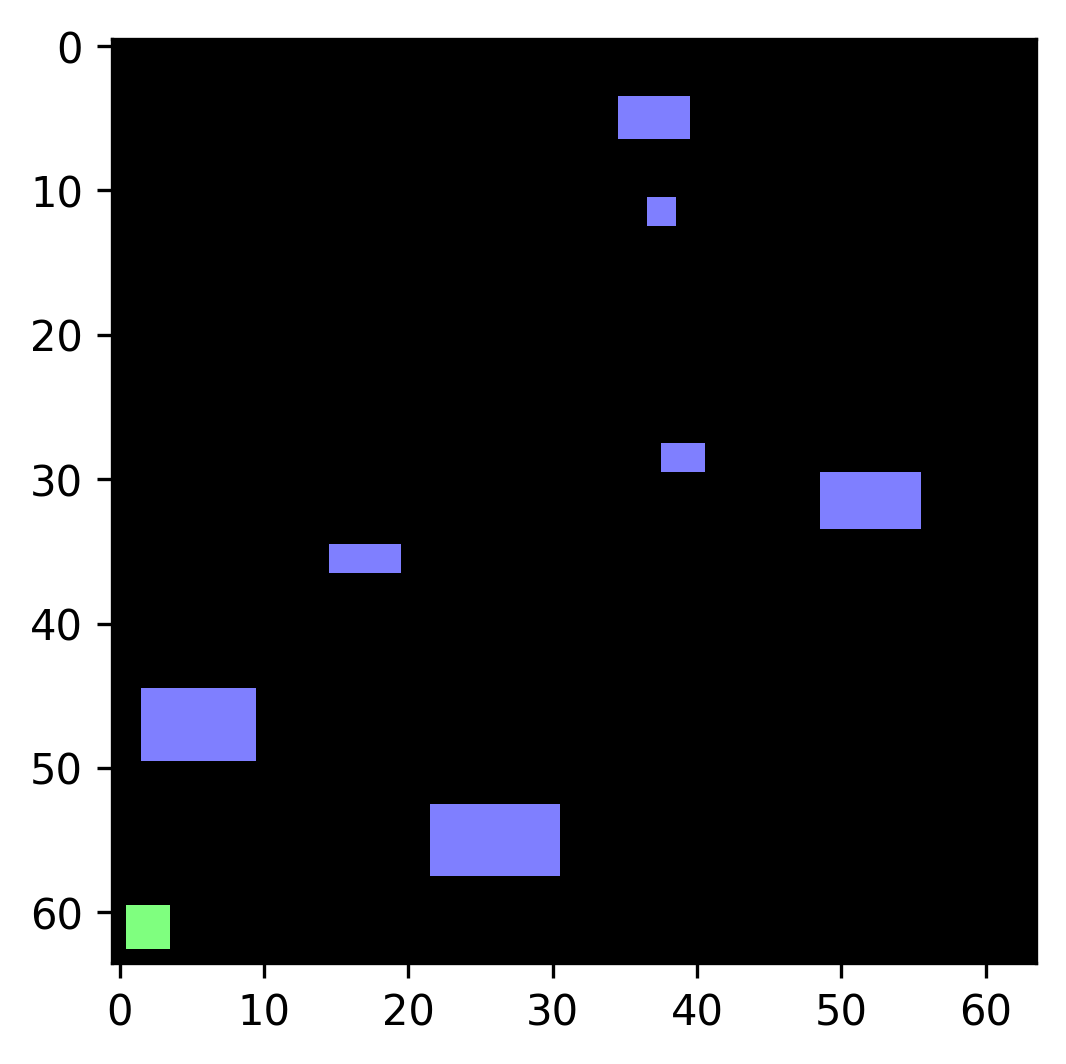

(3, 64, 64)


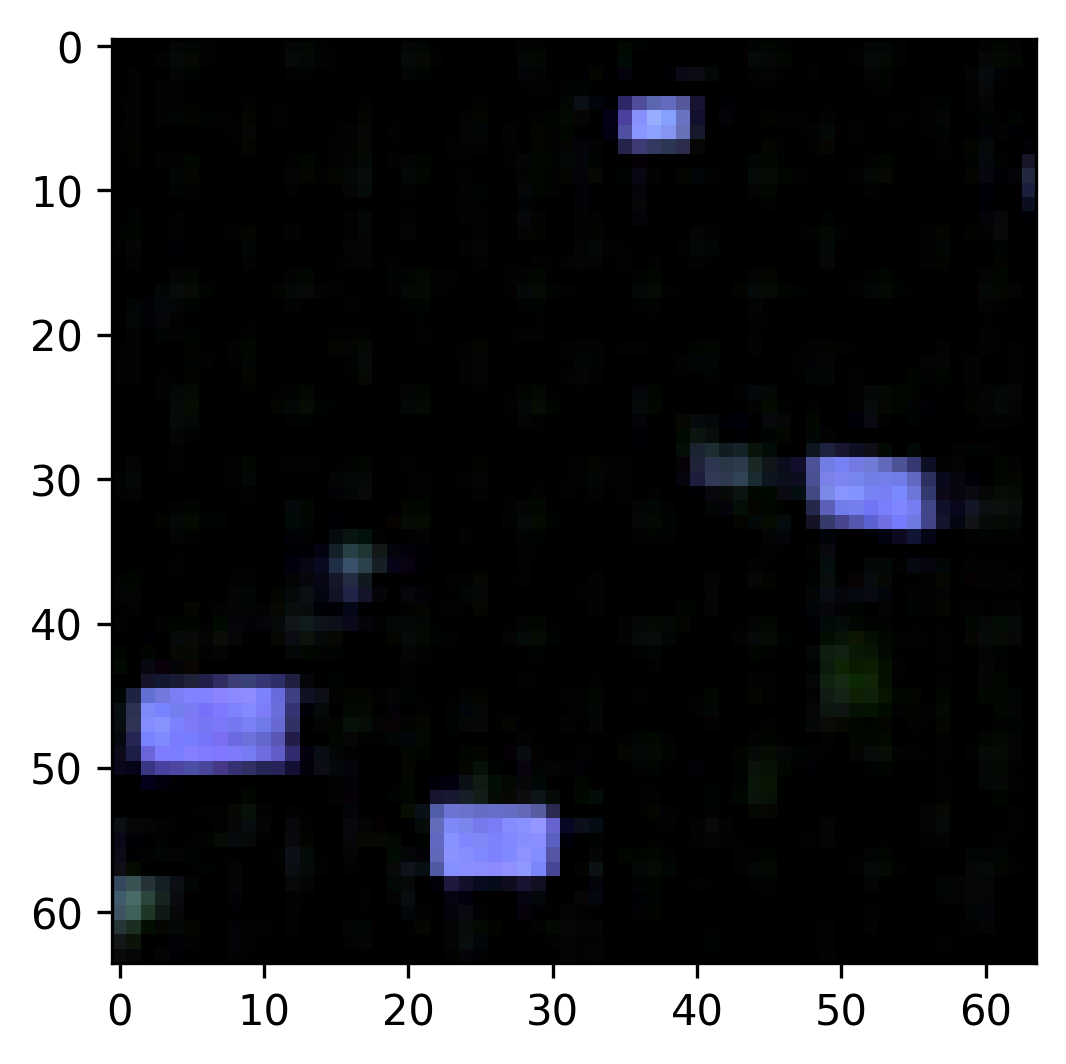

19
repr, std, cov, conv, closs 0.552953839302063 0.478515625 2.3793894797563553e-05 0.008035583421587944 0.24892587959766388
1006.0705509485223 0.00541889212086781 1.0
repr, std, cov, conv, closs 0.5394444465637207 0.47802734375 2.7276109904050827e-05 0.00782859232276678 0.24793797731399536
1006.0705509485223 0.00541889212086781 1.0
repr, std, cov, conv, closs 0.5419679284095764 0.478515625 2.514687366783619e-05 0.007747594267129898 0.24978229403495789
1012.122085448985 0.005402667903750182 1.0
repr, std, cov, conv, closs 0.5279746055603027 0.477783203125 2.8091249987483025e-05 0.007094775792211294 0.25069862604141235
1012.122085448985 0.005402667903750182 1.0
repr, std, cov, conv, closs 0.5597244501113892 0.477294921875 3.164075314998627e-05 0.00706528453156352 0.24514783918857574
1001.0552541098734 0.0053435935931194535 1.0
repr, std, cov, conv, closs 0.5724027752876282 0.477783203125 2.7538742870092392e-05 0.007926620543003082 0.2410287857055664
1009.0917818190909 0.0053435935931194

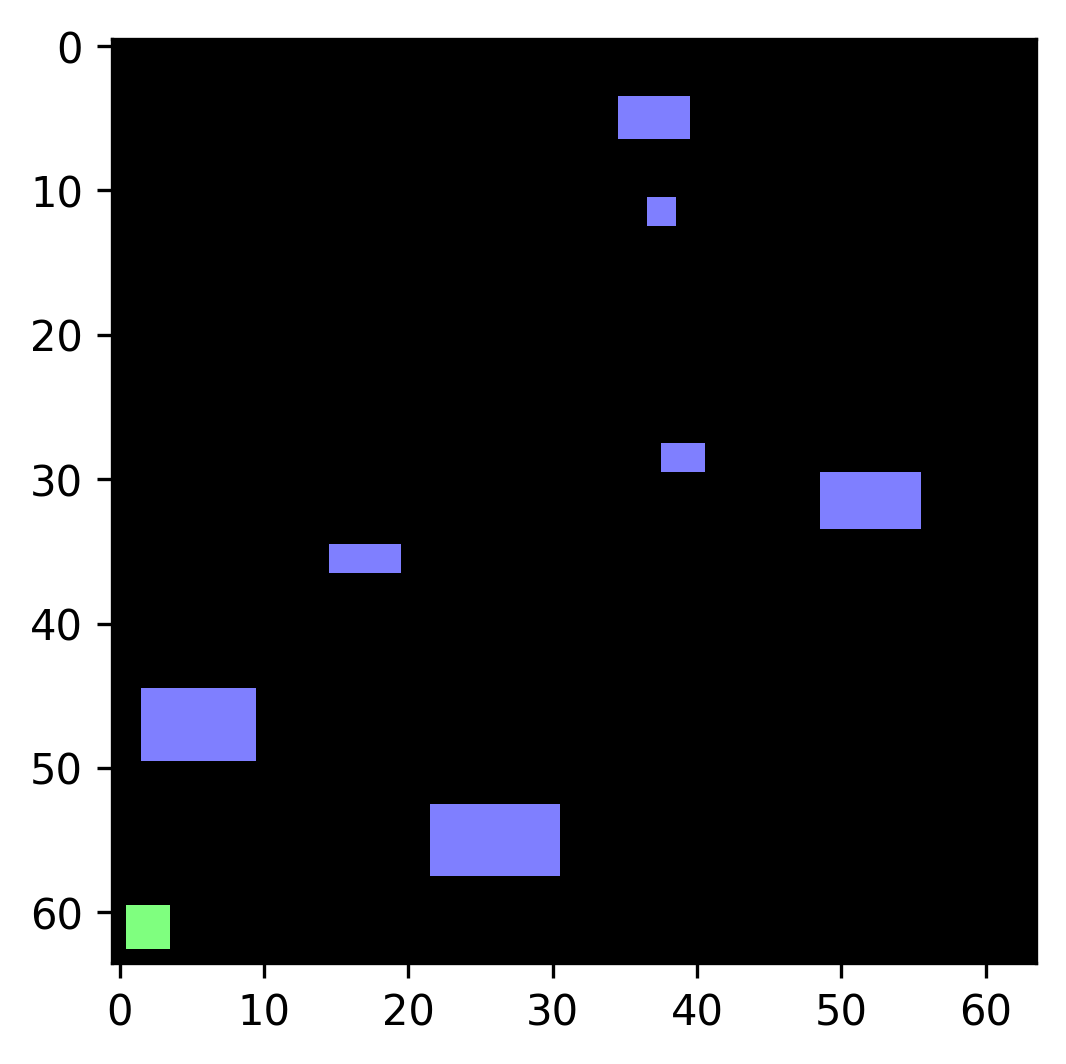

(3, 64, 64)


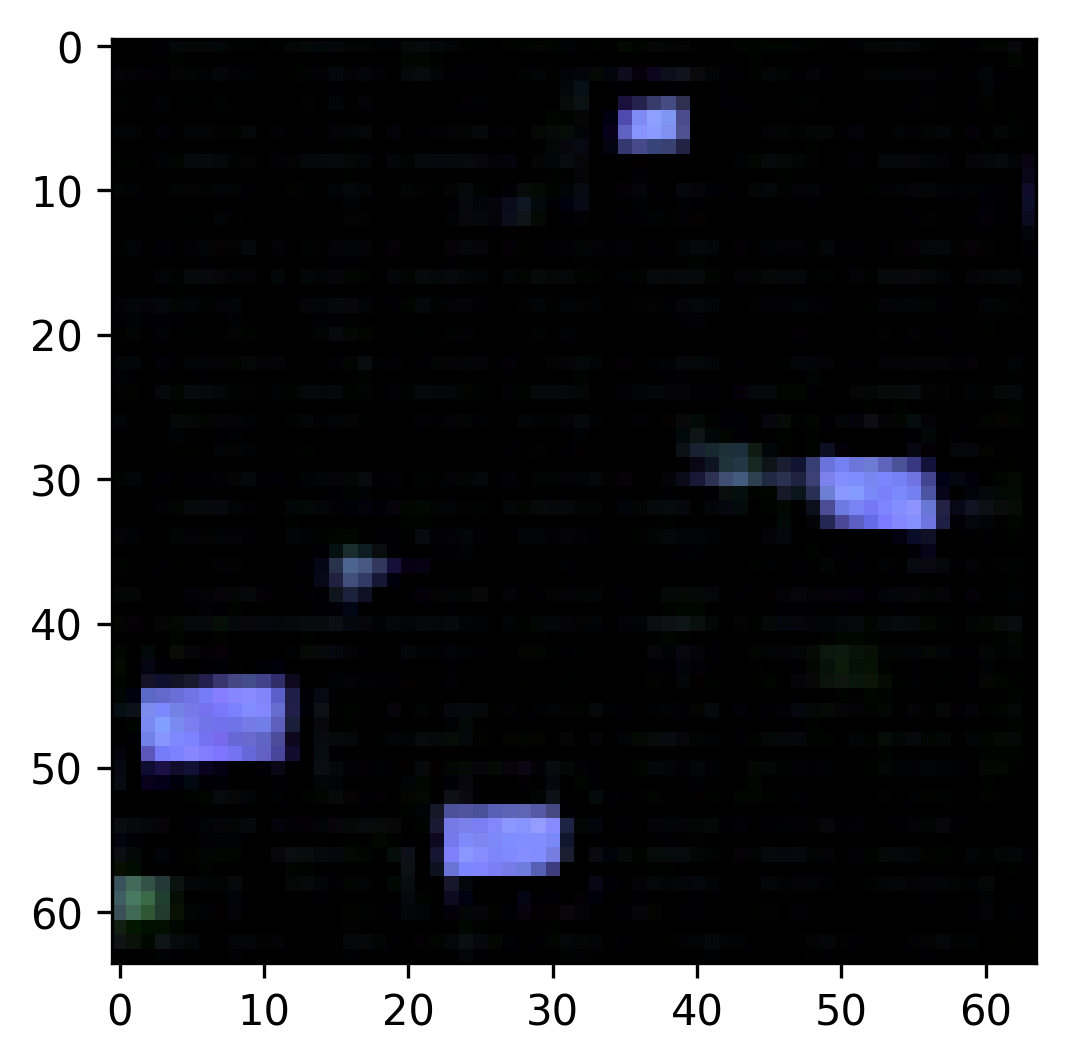

20
repr, std, cov, conv, closs 0.5635707378387451 0.47900390625 2.2087013348937035e-05 0.007767354603856802 0.2507826089859009
1574.3277387318287 0.005118799146424036 1.0
repr, std, cov, conv, closs 0.5638228058815002 0.47900390625 2.1624378859996796e-05 0.006090069189667702 0.249809131026268
1575.9020664705604 0.005118799146424036 1.0
repr, std, cov, conv, closs 0.5447899103164673 0.47900390625 2.2073974832892418e-05 0.007634039036929607 0.25022536516189575
1579.0554465055677 0.005118799146424036 1.0
repr, std, cov, conv, closs 0.573625922203064 0.478515625 2.4548498913645744e-05 0.007555910386145115 0.24972748756408691
1582.215136454025 0.005118799146424036 1.0
repr, std, cov, conv, closs 0.560496985912323 0.478515625 2.449820749461651e-05 0.007479570806026459 0.2493751347064972
1622.2488386004868 0.005118799146424036 1.0
repr, std, cov, conv, closs 0.5873972177505493 0.478515625 2.5061191990971565e-05 0.008758810348808765 0.24886807799339294
1651.6988505006616 0.005118799146424036 1

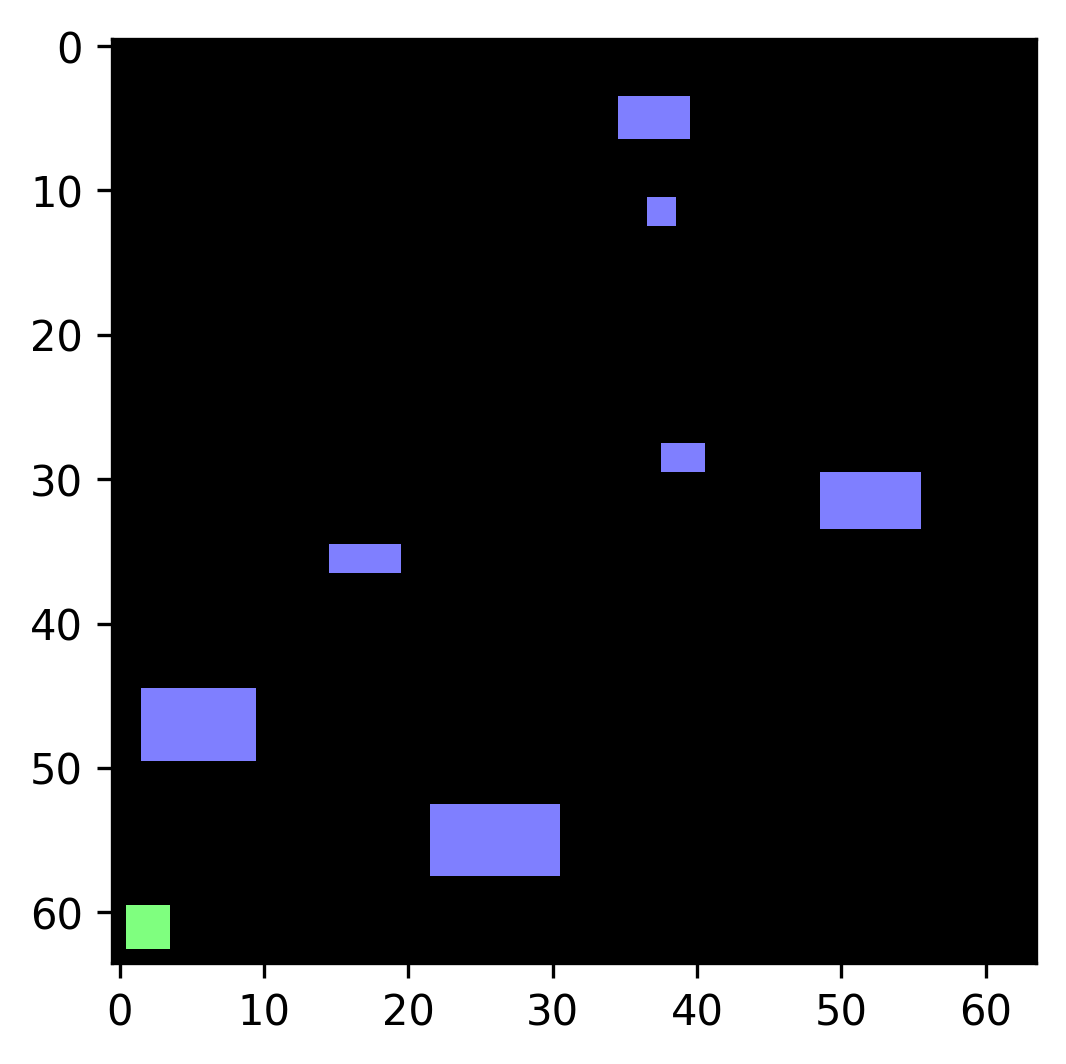

(3, 64, 64)


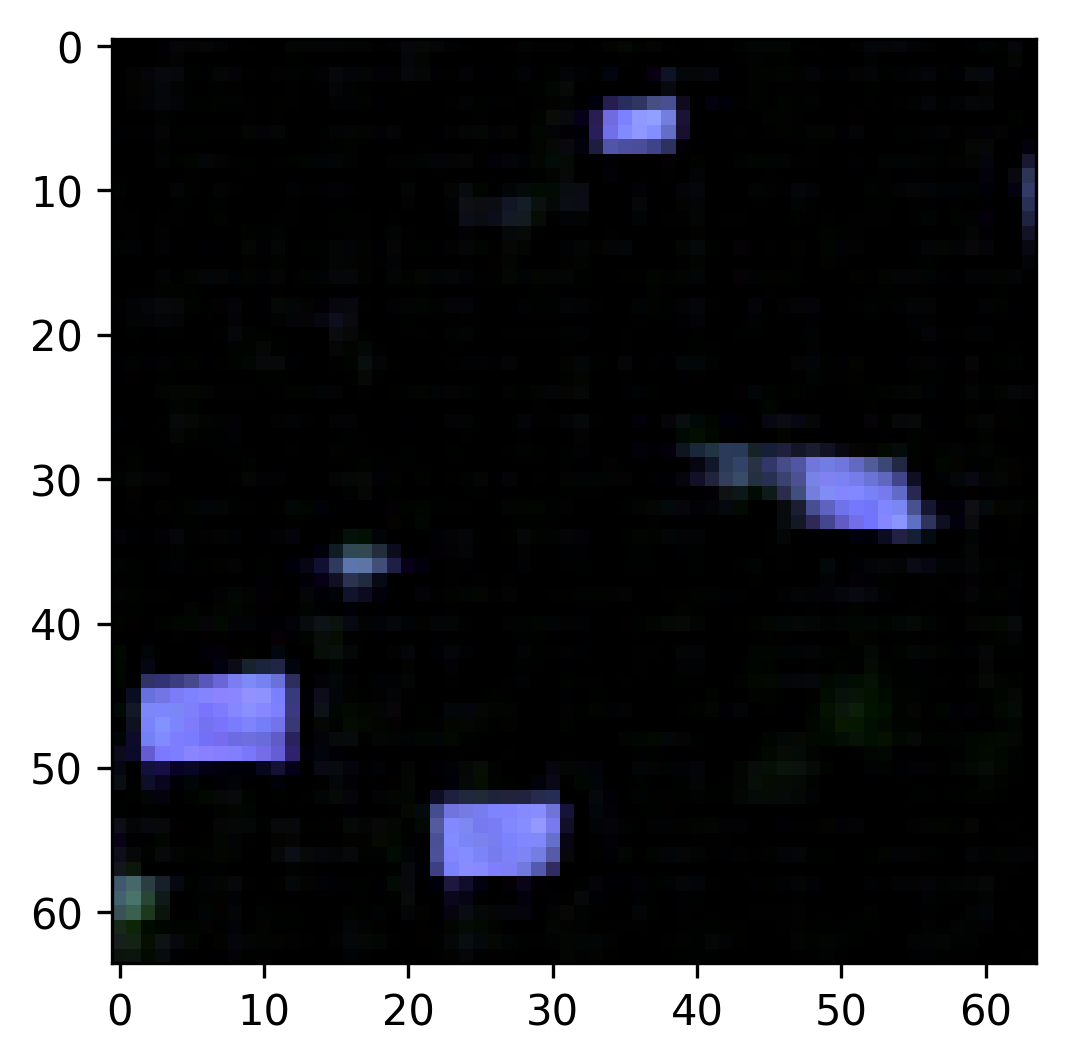

21
repr, std, cov, conv, closs 0.5398468971252441 0.47802734375 2.7843518182635307e-05 0.006717480253428221 0.24994808435440063
1729.4118505346119 0.0046411808954432655 1.0
repr, std, cov, conv, closs 0.5486288070678711 0.478759765625 2.3620668798685074e-05 0.007663199212402105 0.2537862956523895
1729.4118505346119 0.0046411808954432655 1.0
repr, std, cov, conv, closs 0.5291658043861389 0.479736328125 1.9118422642350197e-05 0.007855471223592758 0.24995455145835876
1729.4118505346119 0.0046411808954432655 1.0
repr, std, cov, conv, closs 0.5294308066368103 0.47998046875 1.7591752111911774e-05 0.0073585063219070435 0.24633750319480896
1729.4118505346119 0.0046411808954432655 1.0
repr, std, cov, conv, closs 0.5374342203140259 0.47998046875 1.7771730199456215e-05 0.008281227201223373 0.25173670053482056
1729.4118505346119 0.0046411808954432655 1.0
repr, std, cov, conv, closs 0.534121036529541 0.47998046875 1.834775321185589e-05 0.007301920559257269 0.25254011154174805
1729.4118505346119 0.0

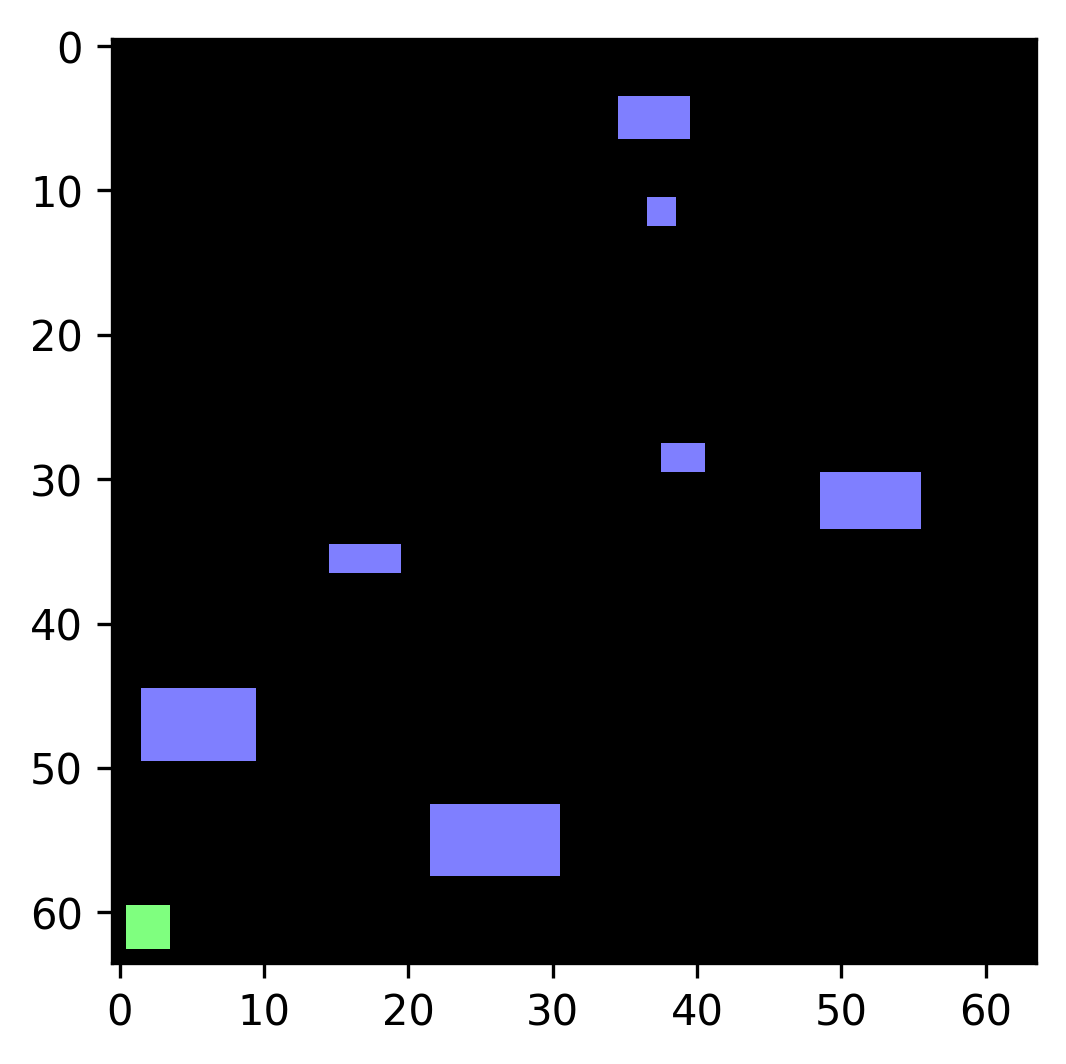

(3, 64, 64)


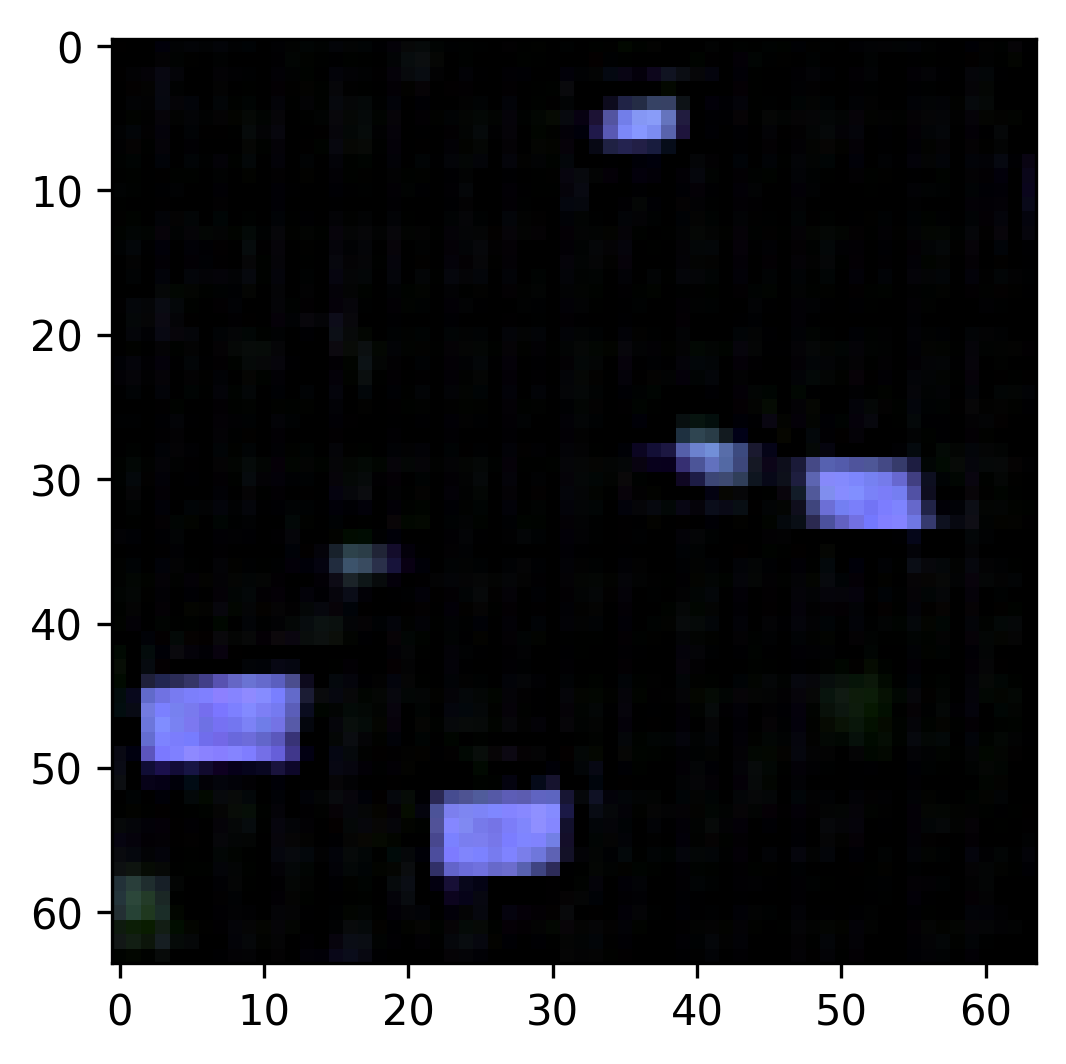

22
repr, std, cov, conv, closs 0.5556057691574097 0.479736328125 1.85440294444561e-05 0.008887757547199726 0.252083957195282
1818.035271025921 0.004401719761877882 1.0
repr, std, cov, conv, closs 0.5633001327514648 0.4794921875 1.9225524738430977e-05 0.008325126953423023 0.2512287199497223
1851.0395543964307 0.004401719761877882 1.0
repr, std, cov, conv, closs 0.5627881288528442 0.479736328125 1.8758466467261314e-05 0.008729612454771996 0.2497057020664215
1911.2001838501012 0.004401719761877882 1.0
repr, std, cov, conv, closs 0.5622424483299255 0.479736328125 1.914449967443943e-05 0.008162486366927624 0.25005003809928894
1945.8957661915617 0.004401719761877882 1.0
repr, std, cov, conv, closs 0.5599277019500732 0.4794921875 2.0116101950407028e-05 0.007969329133629799 0.25059106945991516
2009.1393170207537 0.004401719761877882 1.0
repr, std, cov, conv, closs 0.5546633005142212 0.4794921875 2.0175473764538765e-05 0.006872205995023251 0.25053906440734863
2041.5277715945676 0.00439292950992

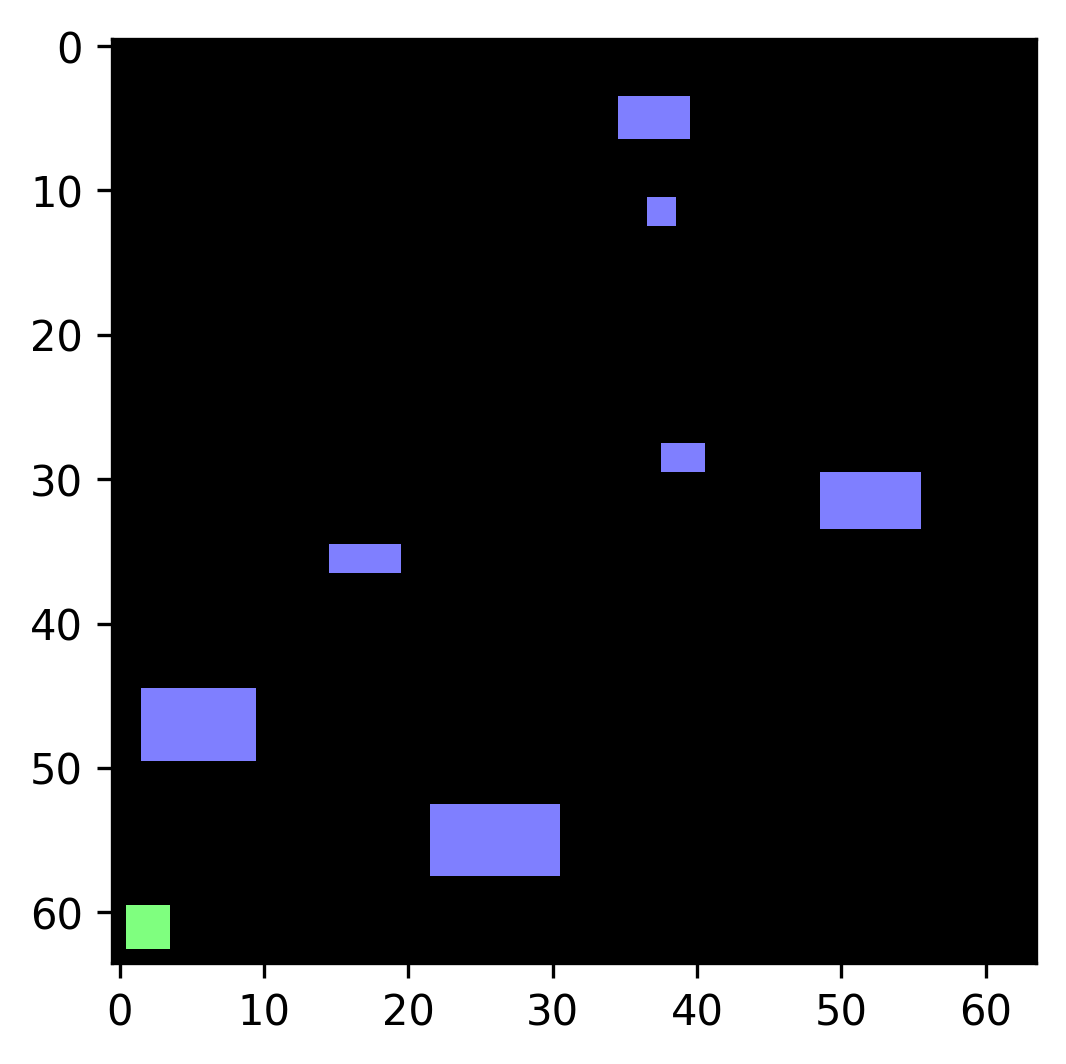

(3, 64, 64)


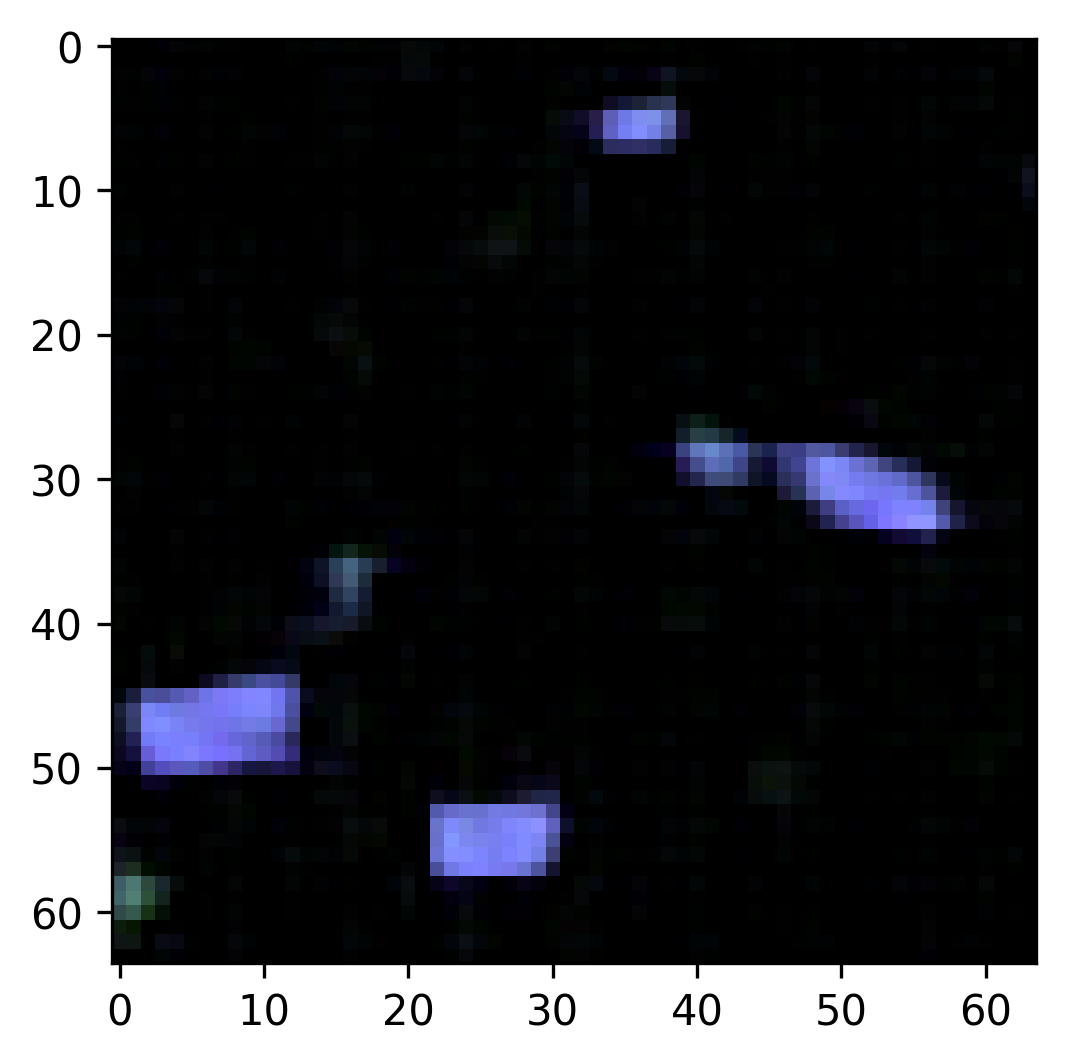

23
repr, std, cov, conv, closs 0.5660127401351929 0.47998046875 1.7314450815320015e-05 0.00963280163705349 0.25239336490631104
2409.9728707788604 0.004208127626823506 1.0
repr, std, cov, conv, closs 0.5291462540626526 0.4794921875 2.0377570763230324e-05 0.007100812159478664 0.2552511394023895
2426.8933747380474 0.00419133711357698 1.0
repr, std, cov, conv, closs 0.5292277336120605 0.479248046875 2.1130545064806938e-05 0.007770180702209473 0.24732251465320587
2441.4911869613807 0.004145507839037695 1.0
repr, std, cov, conv, closs 0.5395815372467041 0.479736328125 1.879781484603882e-05 0.007233547978103161 0.2456223964691162
2439.0521348265543 0.00414136647256513 1.0
repr, std, cov, conv, closs 0.5370428562164307 0.48046875 1.5962868928909302e-05 0.007242168765515089 0.2553099989891052
2453.723082235177 0.00414136647256513 1.0
repr, std, cov, conv, closs 0.5666734576225281 0.48095703125 1.3967975974082947e-05 0.010189506225287914 0.2455836683511734
2480.849396584456 0.00414136647256513 1

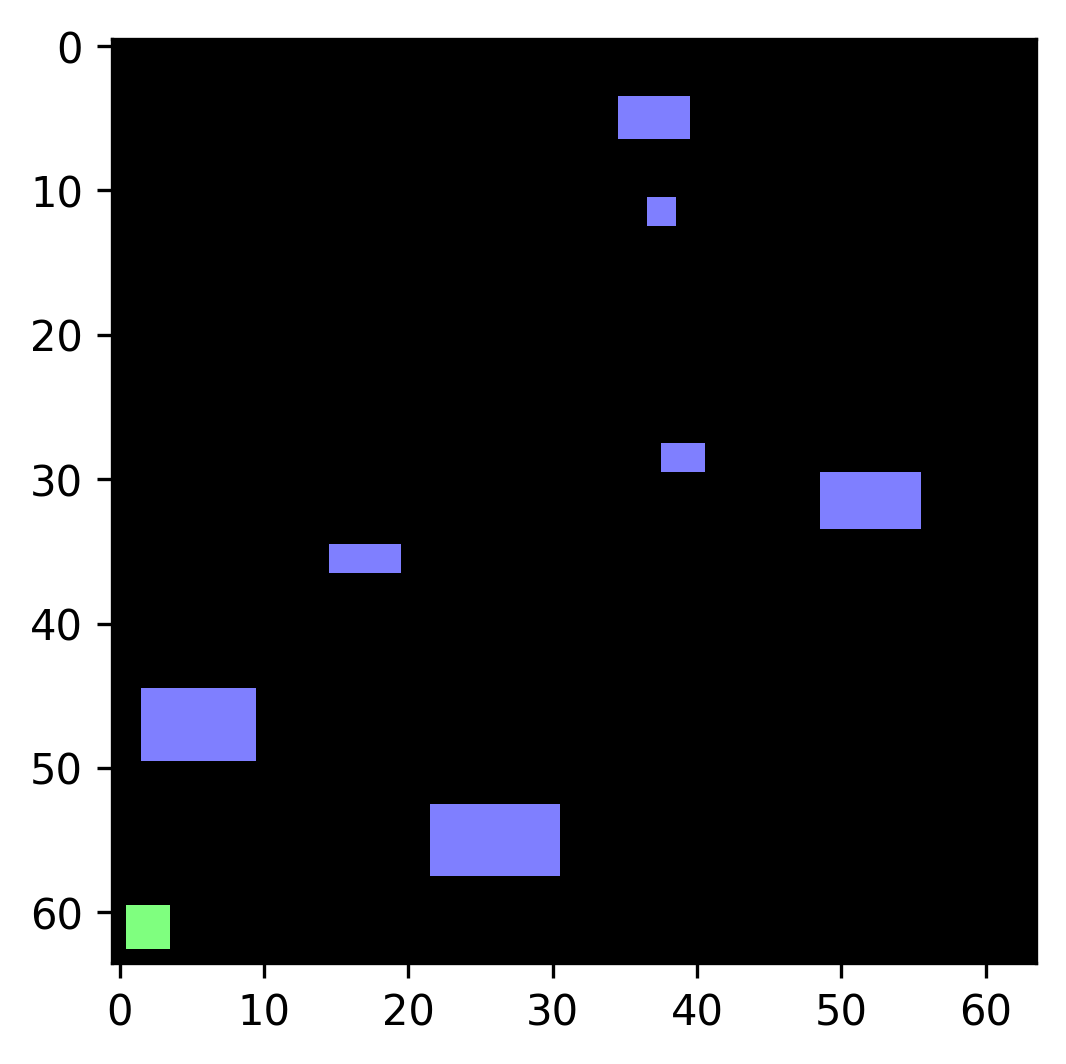

(3, 64, 64)


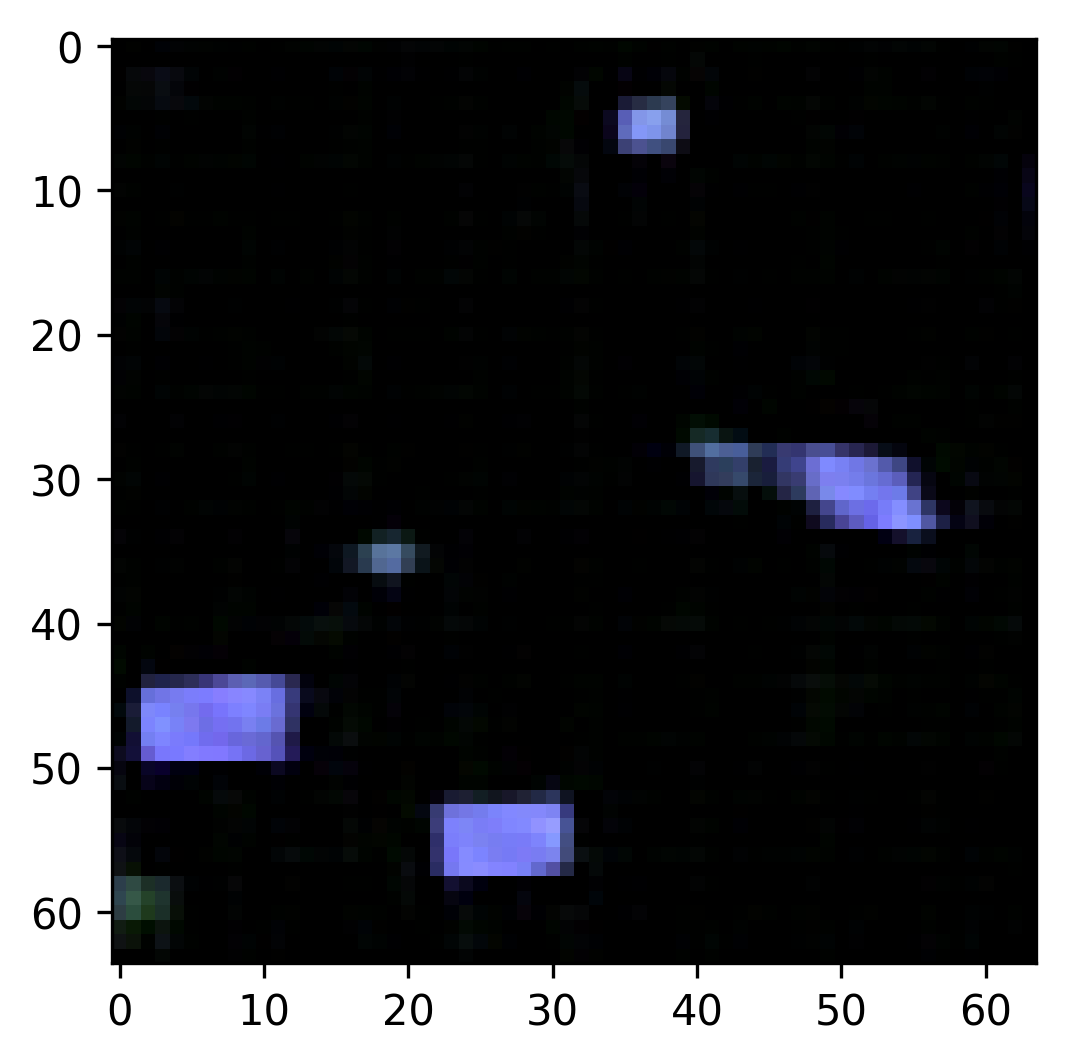

24
repr, std, cov, conv, closs 0.5361789464950562 0.480224609375 1.6897451132535934e-05 0.00703062629327178 0.2506413459777832
2727.9585124061673 0.003747450589206622 1.0
repr, std, cov, conv, closs 0.5355780720710754 0.48095703125 1.3845041394233704e-05 0.008043373003602028 0.25194770097732544
2727.9585124061673 0.003747450589206622 1.0
repr, std, cov, conv, closs 0.5331206917762756 0.480712890625 1.5085563063621521e-05 0.0073058120906353 0.25159189105033875
2794.187983744966 0.003747450589206622 1.0
repr, std, cov, conv, closs 0.5249356031417847 0.48095703125 1.3438519090414047e-05 0.006254781037569046 0.2453487515449524
2794.187983744966 0.003747450589206622 1.0
repr, std, cov, conv, closs 0.5370303392410278 0.480712890625 1.56438909471035e-05 0.00909867137670517 0.25051796436309814
2830.731175335588 0.003747450589206622 1.0
repr, std, cov, conv, closs 0.5315552353858948 0.480224609375 1.6249017789959908e-05 0.007346460595726967 0.2513795793056488
2850.6058380923437 0.00374745058920

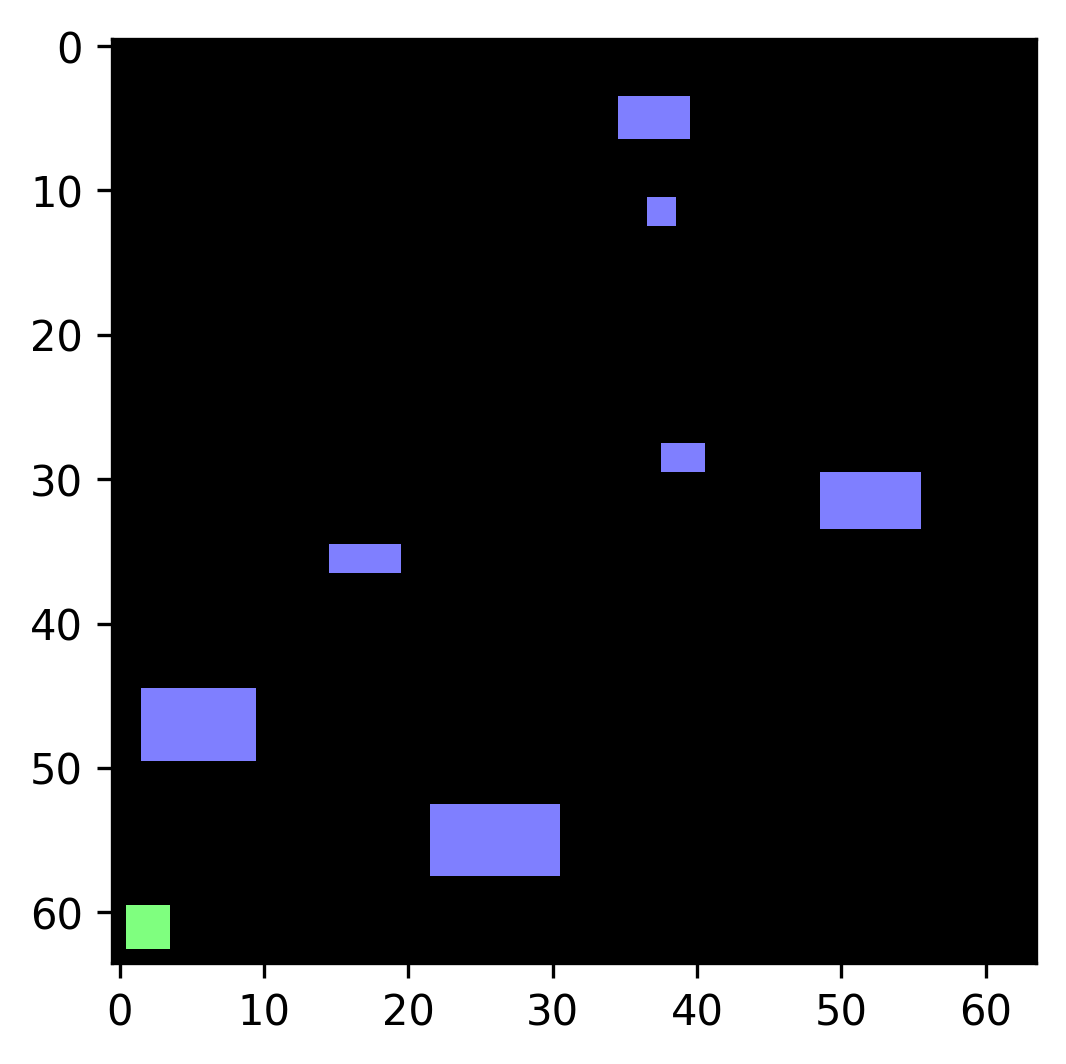

(3, 64, 64)


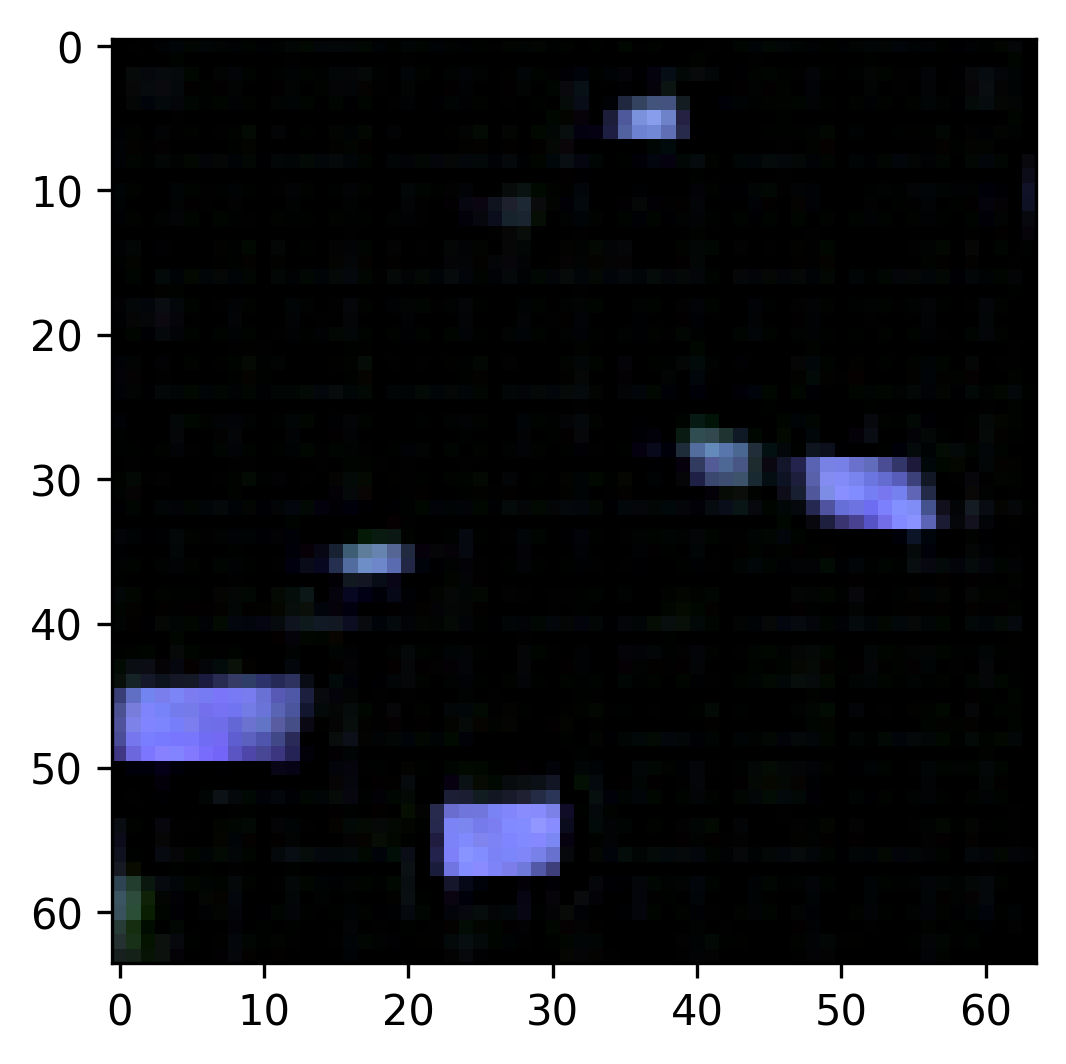

25
repr, std, cov, conv, closs 0.50626540184021 0.481201171875 1.231534406542778e-05 0.008079476654529572 0.24995750188827515
2890.7747654365958 0.003501213922130405 1.0
repr, std, cov, conv, closs 0.5144534111022949 0.480712890625 1.4421530067920685e-05 0.00796177051961422 0.25006651878356934
2890.7747654365958 0.003501213922130405 1.0
repr, std, cov, conv, closs 0.5139867067337036 0.480712890625 1.4741672202944756e-05 0.008439669385552406 0.2500815689563751
2890.7747654365958 0.003501213922130405 1.0
repr, std, cov, conv, closs 0.5127052664756775 0.48046875 1.5591969713568687e-05 0.006708468310534954 0.2500899136066437
2890.7747654365958 0.003501213922130405 1.0
repr, std, cov, conv, closs 0.5233821868896484 0.480712890625 1.526414416730404e-05 0.009538724087178707 0.24969664216041565
2931.509727797835 0.003501213922130405 1.0
repr, std, cov, conv, closs 0.5281690359115601 0.48095703125 1.299404539167881e-05 0.008367946371436119 0.25030696392059326
2949.142817484722 0.003501213922130

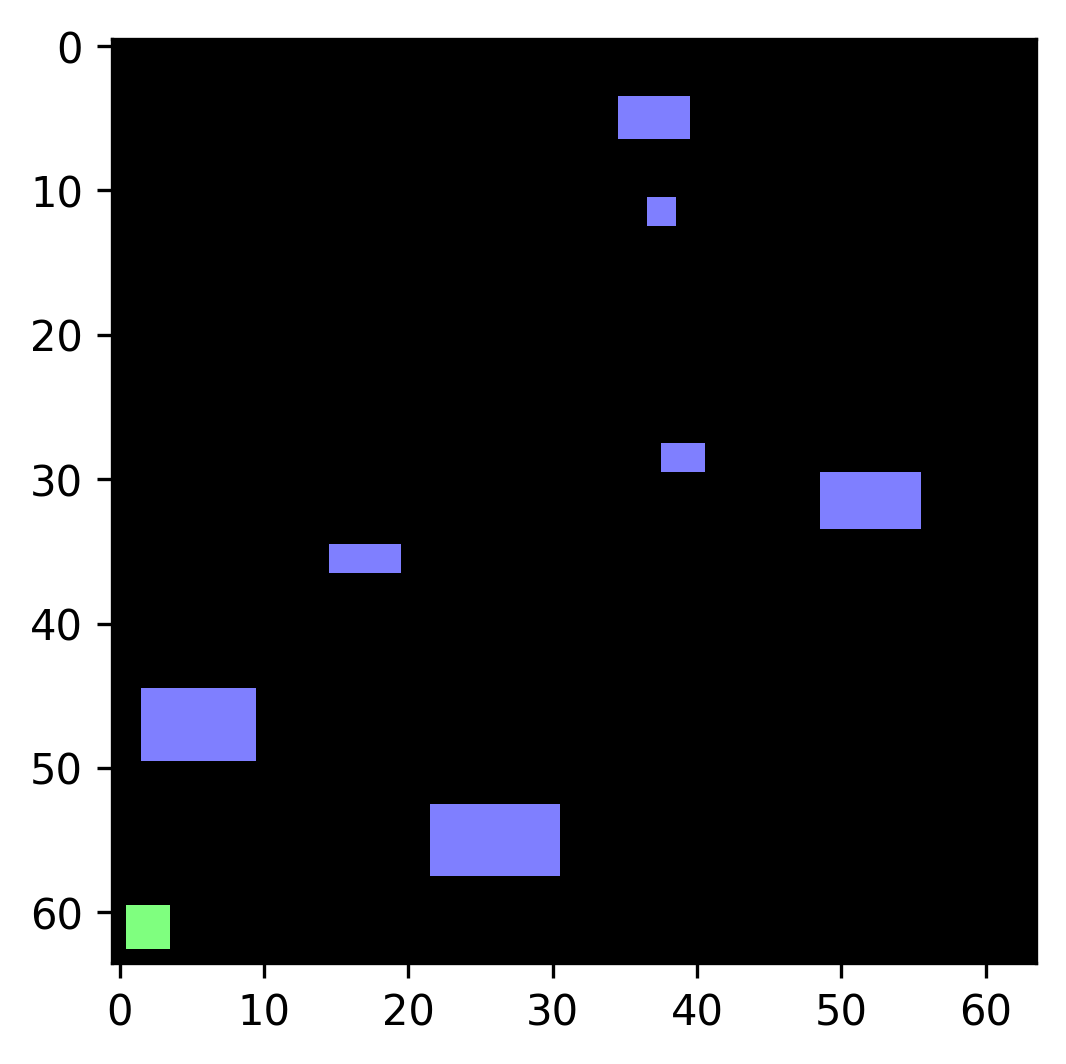

(3, 64, 64)


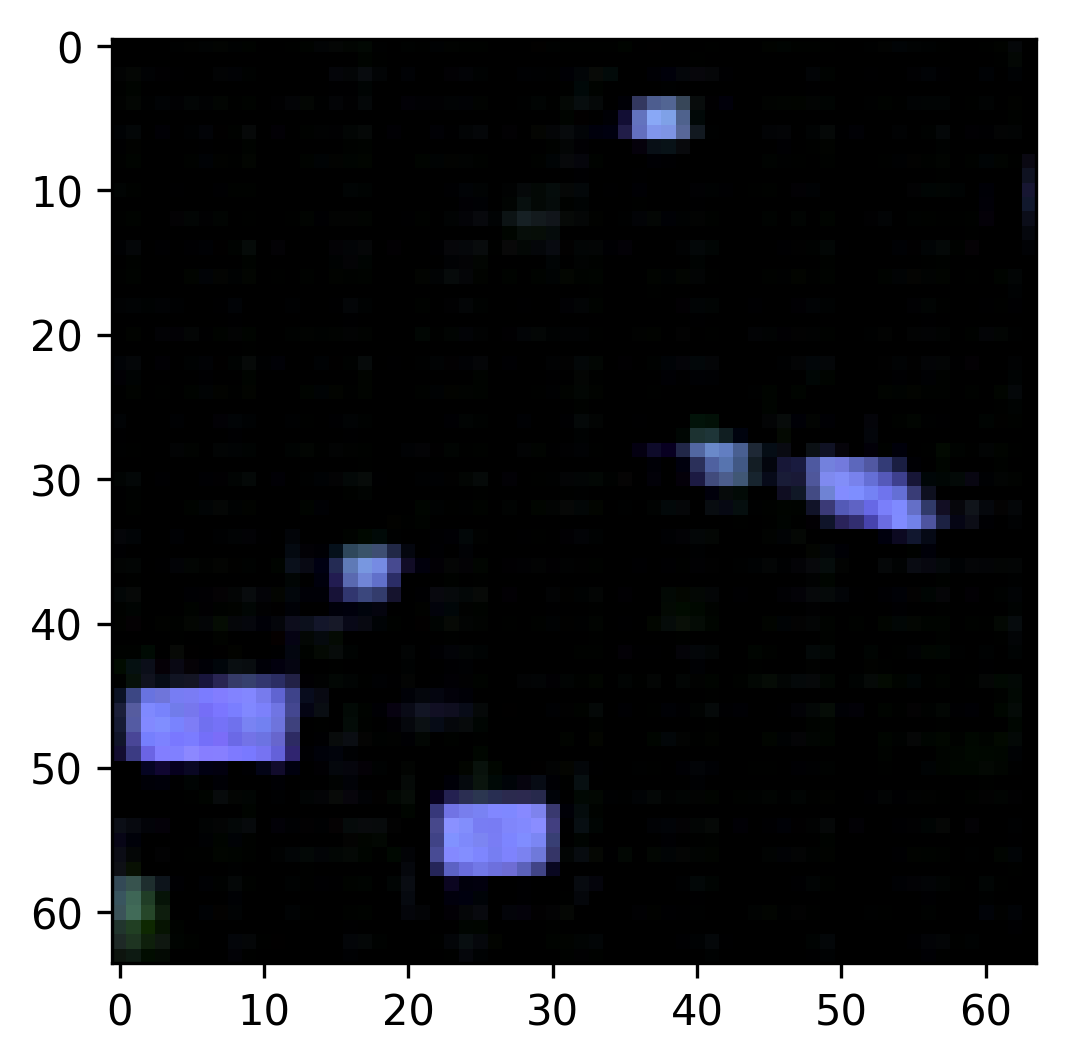

26
repr, std, cov, conv, closs 0.49884170293807983 0.481689453125 1.1448981240391731e-05 0.007334093563258648 0.24995781481266022
3634.2767666186196 0.0033639965950363207 1.0
repr, std, cov, conv, closs 0.522315263748169 0.48095703125 1.348019577562809e-05 0.007376992609351873 0.2512401044368744
3634.2767666186196 0.0033639965950363207 1.0
repr, std, cov, conv, closs 0.5276044011116028 0.481201171875 1.2680422514677048e-05 0.008126558735966682 0.25093919038772583
3689.1741757460372 0.0033639965950363207 1.0
repr, std, cov, conv, closs 0.5314351320266724 0.480712890625 1.4335615560412407e-05 0.0071589588187634945 0.24981653690338135
3700.252769484976 0.003340542528904904 1.0
repr, std, cov, conv, closs 0.5270248651504517 0.48095703125 1.4458084478974342e-05 0.00841506291180849 0.25196754932403564
3812.8850874854234 0.003337205323581323 1.0
repr, std, cov, conv, closs 0.5150715112686157 0.4814453125 1.1887634173035622e-05 0.007283358834683895 0.249826580286026
3824.335185216026 0.0033372

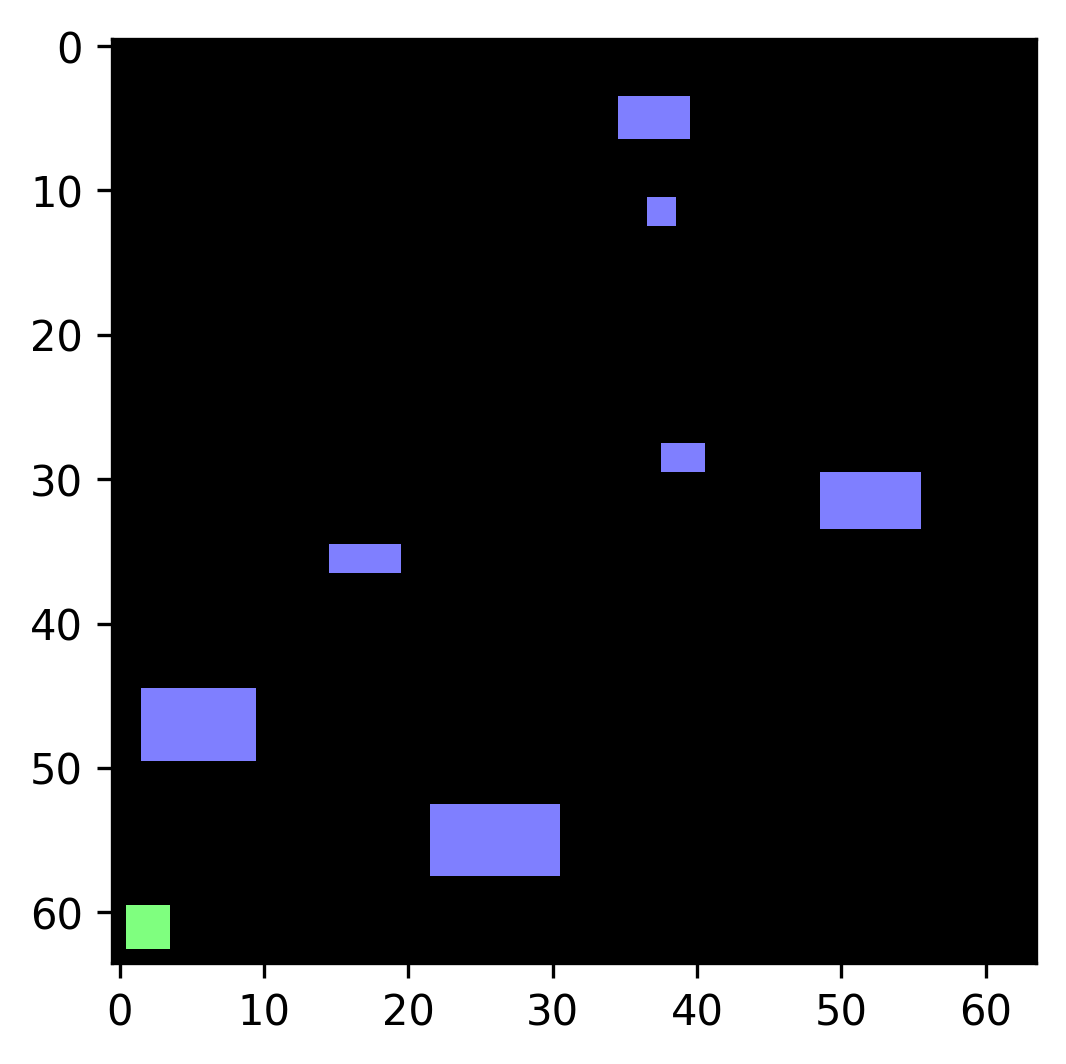

(3, 64, 64)


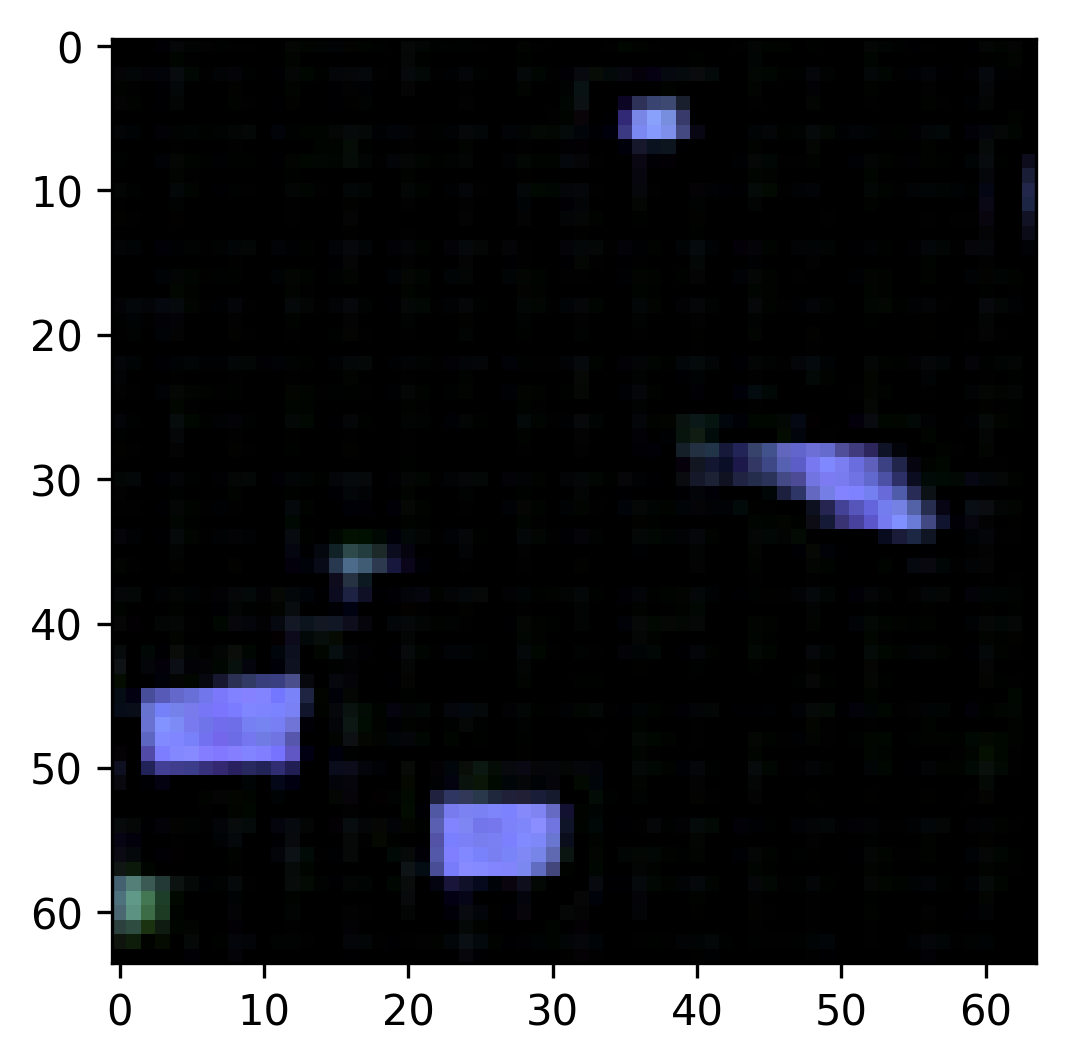

27
repr, std, cov, conv, closs 0.5336494445800781 0.482666015625 8.25454480946064e-06 0.00979750044643879 0.24943366646766663
5166.700298606562 0.0030623319430406032 1.0
repr, std, cov, conv, closs 0.5395001173019409 0.482421875 9.353505447506905e-06 0.009904427453875542 0.24807634949684143
5260.495641009068 0.0030623319430406032 1.0
repr, std, cov, conv, closs 0.5256130695343018 0.481689453125 1.152651384472847e-05 0.007838892750442028 0.2513635754585266
5404.390936983983 0.0030623319430406032 1.0
repr, std, cov, conv, closs 0.5341947078704834 0.4814453125 1.2440141290426254e-05 0.008076492697000504 0.252189576625824
5480.546182295947 0.003050113177448244 1.0
repr, std, cov, conv, closs 0.48883917927742004 0.48046875 1.6037840396165848e-05 0.007252495735883713 0.2491529881954193
5323.969941330634 0.0029541019222114598 1.0
repr, std, cov, conv, closs 0.5188261270523071 0.48095703125 1.4020130038261414e-05 0.007343245204538107 0.2472056746482849
5239.506158375354 0.0029014298889669696 1

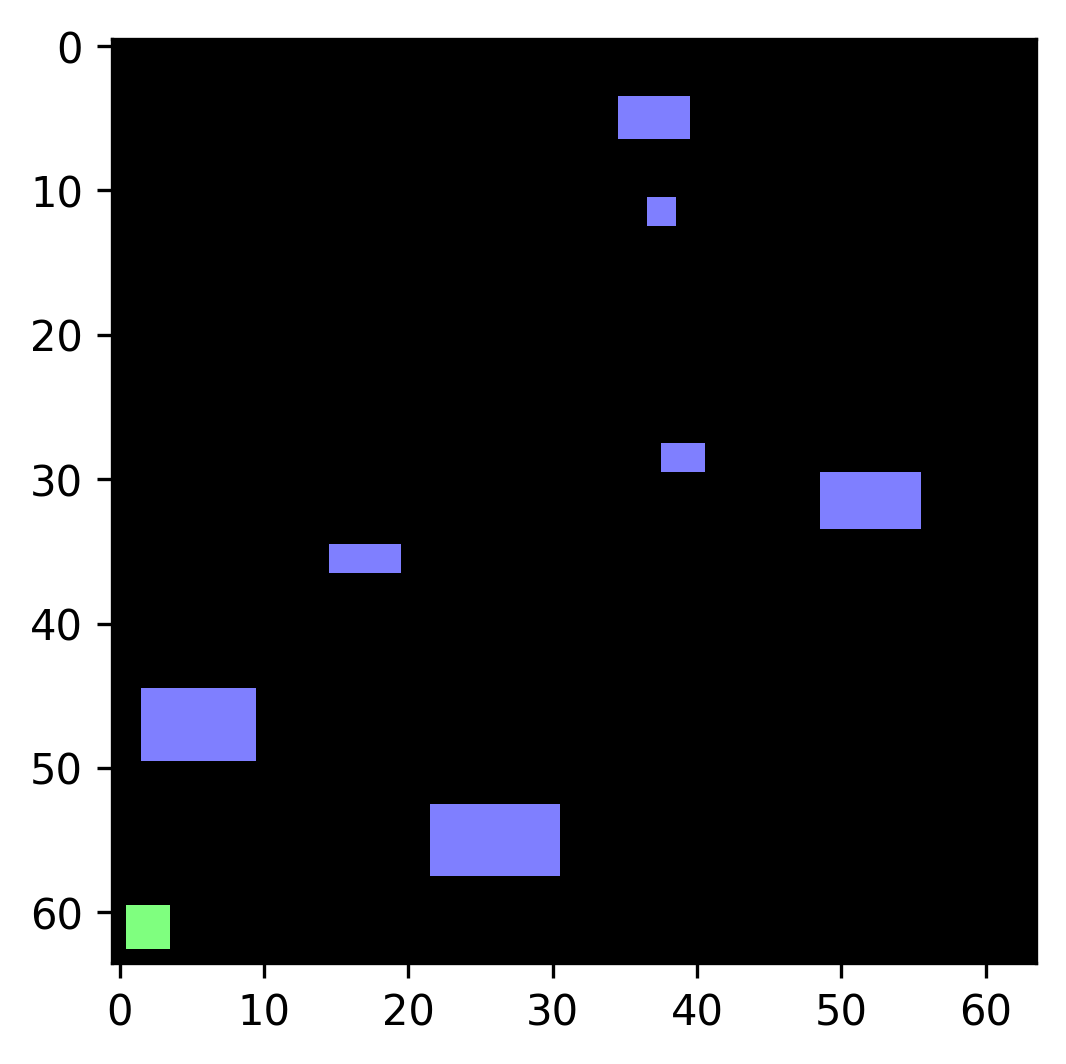

(3, 64, 64)


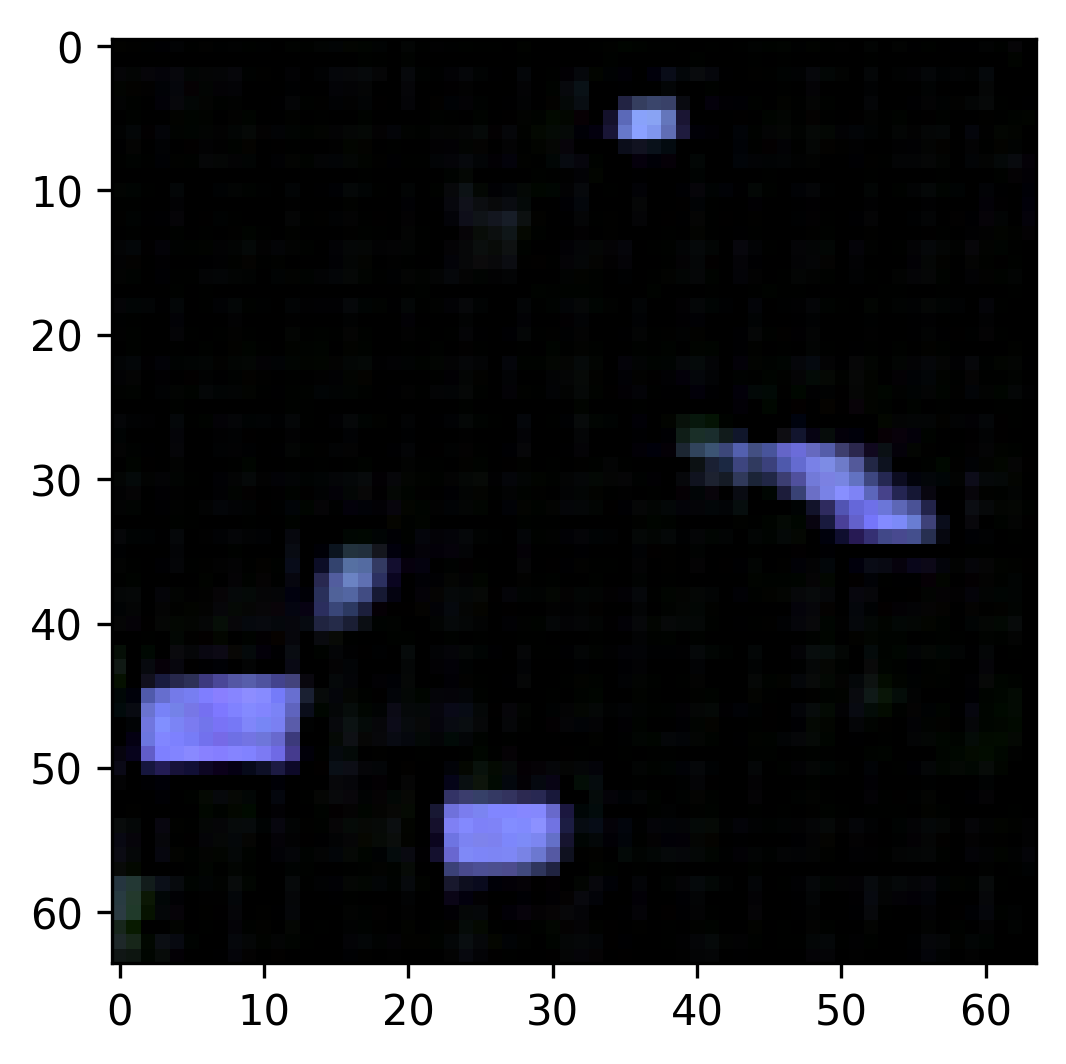

28
repr, std, cov, conv, closs 0.5315104722976685 0.482421875 9.104609489440918e-06 0.007942674681544304 0.24495616555213928
9006.589083340592 0.002815721884027946 1.0
repr, std, cov, conv, closs 0.541181743144989 0.482421875 8.996576070785522e-06 0.008895928971469402 0.24010217189788818
9124.379837708306 0.002815721884027946 1.0
repr, std, cov, conv, closs 0.5241236686706543 0.482421875 9.123934432864189e-06 0.008716324344277382 0.25038987398147583
9160.932139844806 0.002815721884027946 1.0
repr, std, cov, conv, closs 0.5324281454086304 0.482421875 9.06316563487053e-06 0.007655765395611525 0.2492116242647171
9216.035330022078 0.002815721884027946 1.0
repr, std, cov, conv, closs 0.5247527360916138 0.482177734375 9.784242138266563e-06 0.007942944765090942 0.2569080591201782
9468.130231724992 0.002815721884027946 1.0
repr, std, cov, conv, closs 0.5305373072624207 0.482177734375 9.869225323200226e-06 0.007624153047800064 0.2509216368198395
9506.05959931527 0.002815721884027946 1.0
repr, s

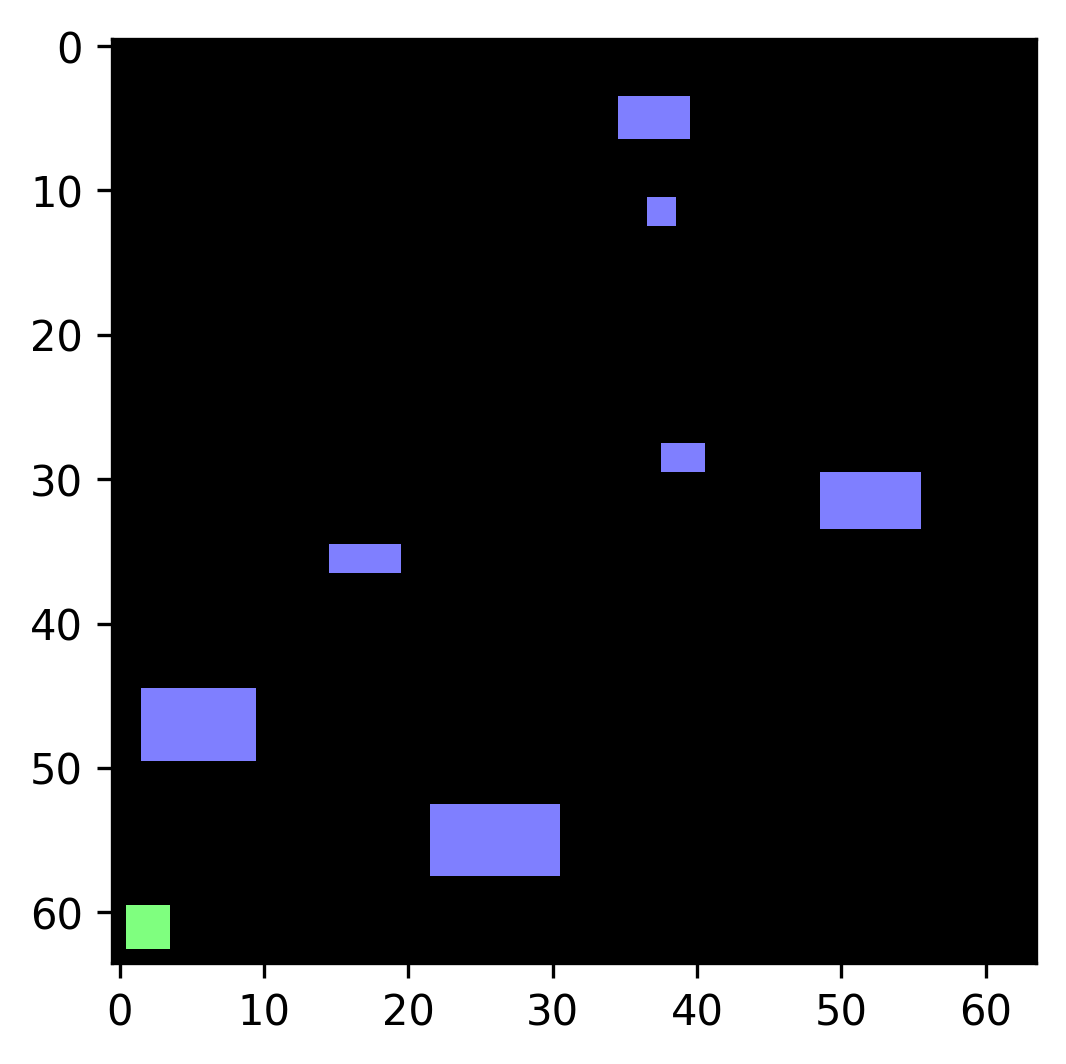

(3, 64, 64)


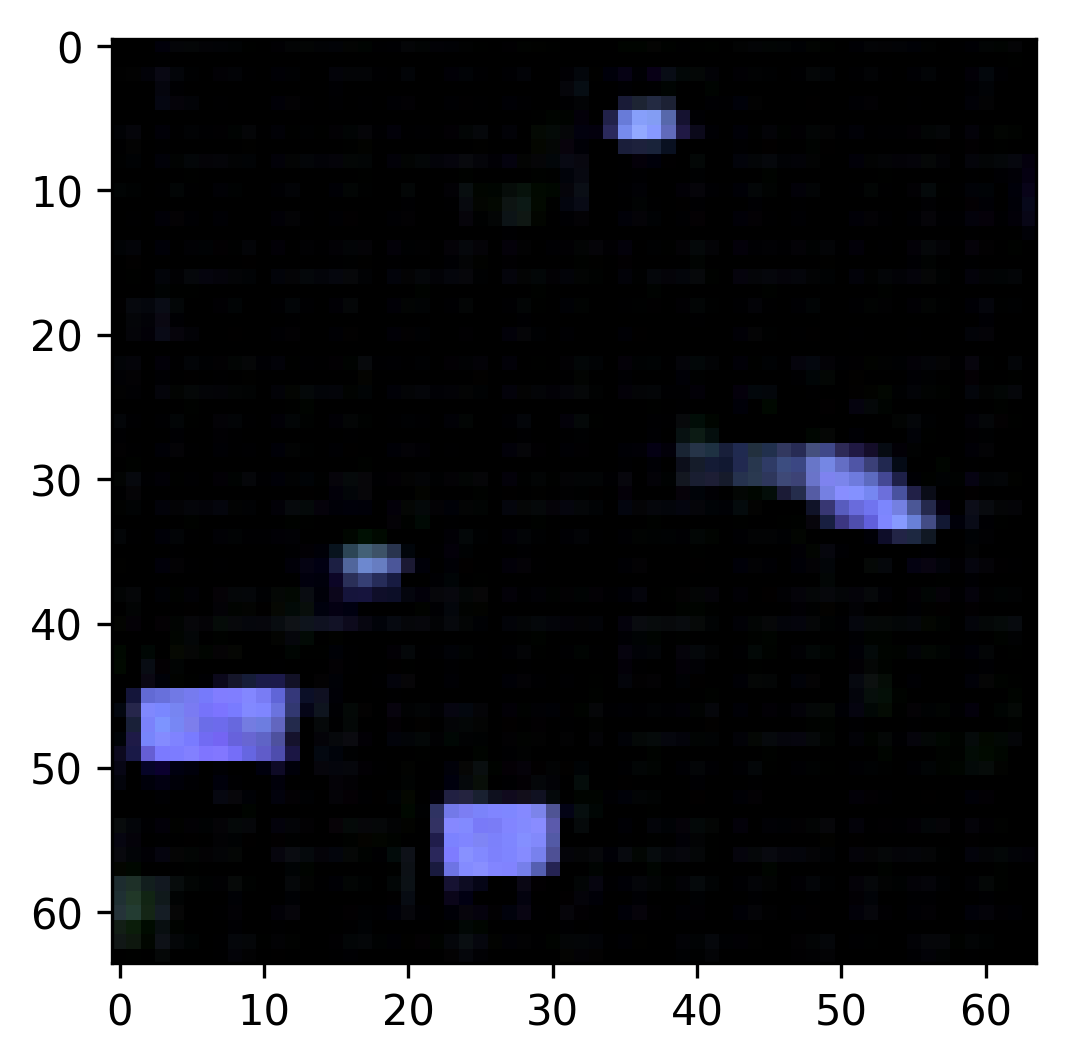

29
repr, std, cov, conv, closs 0.5207065343856812 0.483154296875 7.209833711385727e-06 0.008470699191093445 0.25004392862319946
12438.48179205521 0.0026945754405816756 1.0
repr, std, cov, conv, closs 0.5373007655143738 0.482421875 9.064329788088799e-06 0.008641041815280914 0.2502535581588745
12638.997106785393 0.0026945754405816756 1.0
repr, std, cov, conv, closs 0.5104430913925171 0.48193359375 1.0381918400526047e-05 0.0069793714210391045 0.25006115436553955
12855.587585884456 0.0026811428878885184 1.0
repr, std, cov, conv, closs 0.5227628946304321 0.48193359375 9.772134944796562e-06 0.006561882793903351 0.25021985173225403
12676.952027736063 0.0026438869123795155 1.0
repr, std, cov, conv, closs 0.5076719522476196 0.48193359375 1.0084128007292747e-05 0.00802204292267561 0.2499750554561615
12638.997106785393 0.0026333377508137726 1.0
repr, std, cov, conv, closs 0.5111817717552185 0.482421875 8.74977558851242e-06 0.007549740374088287 0.24994578957557678
12638.997106785393 0.002633337750

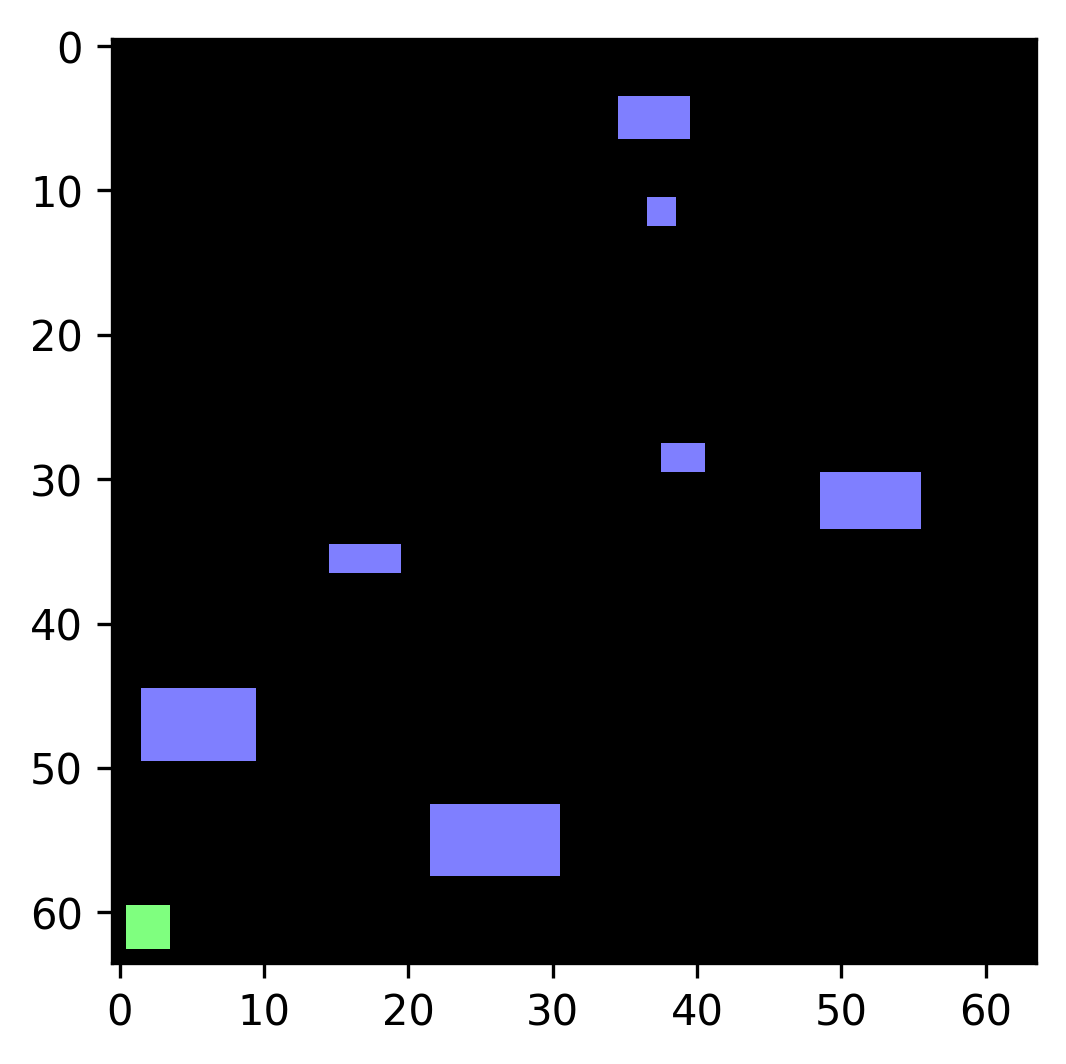

(3, 64, 64)


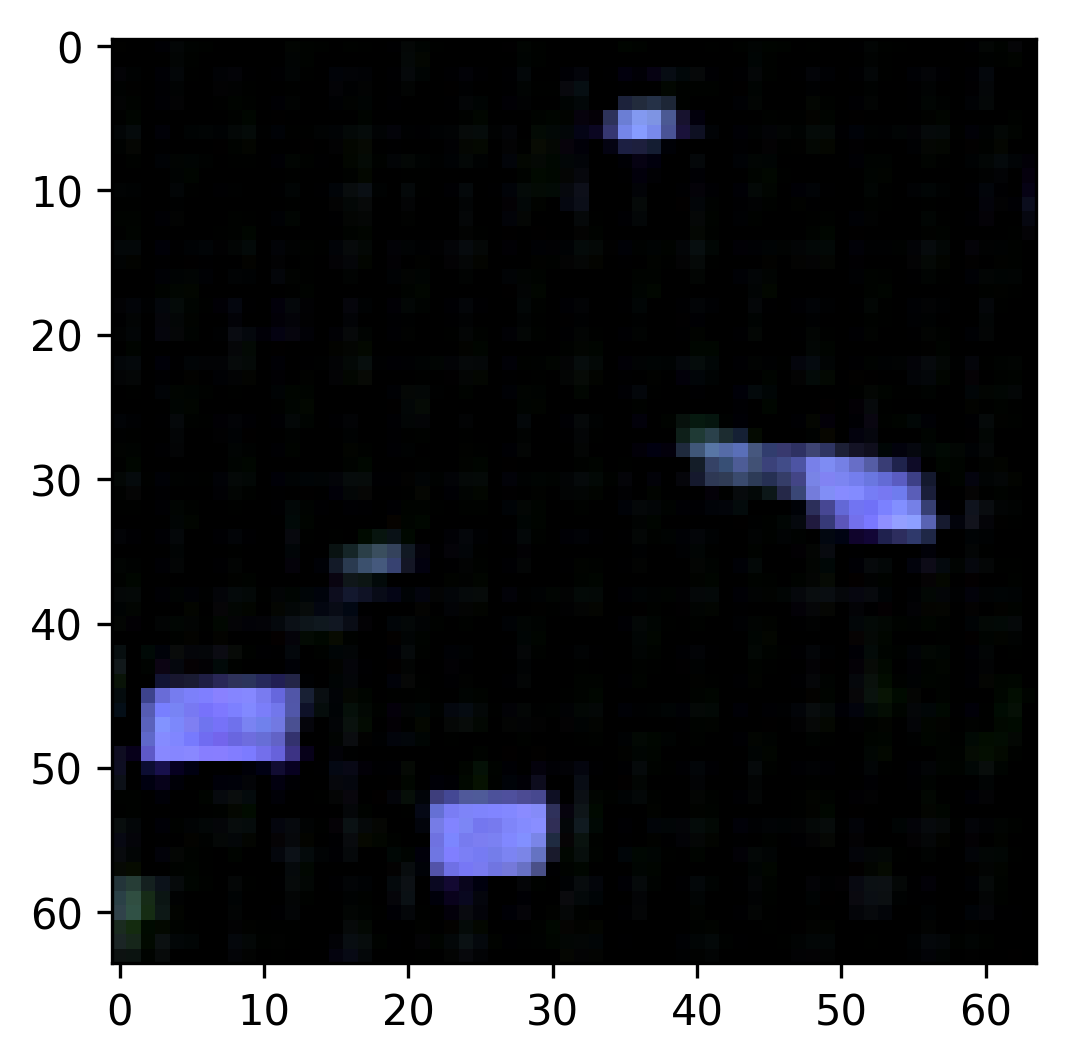

In [ ]:
from matplotlib import pyplot as plt
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(4, 4))
    print(npimg.shape)
    # plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.imshow(np.transpose(npimg, (1, 2, 0)), cmap='gray')
    plt.show()

import torchvision.transforms.v2 as transforms
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


for i in range(30):
    print(i)
    # agent.train_ae(train_loader, optim)
    # agent.train_jepa(train_loader, optim)
    agent.train_jepa(train_loader, c_loader, optim)

    state = buffer[7][80][0]
    state = transform(state).unsqueeze(0).to(device)[0]
    sx_ = agent.jepa.enc(state.unsqueeze(0))
    out= agent.deconv(sx_).squeeze(0)
    print(out.shape)
    imshow(state.detach().cpu())
    imshow(out.detach().cpu())

# 10 epochs 15m23s


In [ ]:
state = buffer[7][80][0]
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
state = transform(state).unsqueeze(0).to(device)[0]
sx_ = agent.jepa.enc(state.unsqueeze(0))
out= agent.deconv(sx_).squeeze(0)
print(out.shape)
imshow(state.detach().cpu())
imshow(out.detach().cpu())

In [ ]:
# @title simulate 4
from google.colab.patches import cv2_imshow
import cv2
import torchvision.transforms as transforms
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
# buffer=[]

def simulate(agent, buffer=[]):
    # out = cv2.VideoWriter('video.avi', cv2.VideoWriter_fourcc(*'DIVX'), 20, (64,64))
    out = cv2.VideoWriter('video{}.avi'.format(time.time()), cv2.VideoWriter_fourcc(*'DIVX'), 20, (64,64))
    state = env.reset()
    episode=[]
    act=[]
    while True:
    # while not done:
        state = transform(state).unsqueeze(0).to(device)
        # action = agent(state).cpu() # https://github.com/openai/procgen/blob/master/procgen/env.py#L155
        if len(act)<=0: act = agent(state).cpu()[:1].tolist()
        action = act.pop(0)
        state, reward, done, info = env.step(action) # np(64,64,3) 0.0 False {'prev_level_seed': 736820912, 'prev_level_complete': 0, 'level_seed': 736820912, 'rgb': array([[[  0, 125, 222], ...)
        # print(i, 'act: ',action.item(), 'reward: ',reward)
        out.write(state)
        if done:
            episode.append((state, action, -1))
            print("ded")
            break
        episode.append((state, action, 0))
    print('time')
    env.close()
    out.release()
    cv2.destroyAllWindows()
    buffer.append(episode)
    return buffer

buffer = simulate(agent, buffer)
# _=simulate(agent)



In [ ]:
# @title wwwwwwwwwwww
for i in range(10):
    # # buffer=[]
    # print("#### simulate ####")
    # buffer = simulate(agent, buffer)

    print(i,"#### train ####")
    # train_data = BufferDataset(buffer, seq_len) # one line of poem is roughly 50 characters
    # train_loader = DataLoader(train_data, shuffle = True, pin_memory = True, batch_size = batch_size, num_workers = 2, drop_last=True) # num_workers = 4
    agent.train_jepa(train_loader, optim)

# repr, std, cov 0.009419754147529602 0.478271484375 0.005037273280322552


In [ ]:
!ffmpeg -hide_banner -loglevel error -i video.avi video.mp4 -y
from IPython.display import HTML
from base64 import b64encode
mp4 = open('video.mp4', "rb").read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML(f"""<video width=400 controls autoplay><source src="{data_url}" type="video/mp4"></video>""")

###save

In [ ]:
# @title test search, argm
# # def search(self, sx, T=None, bptt=None):
T=20
bptt=None
if T==None: T = 256
if bptt==None: bptt = min(T,32)
d_model=agent.d_model
# sx=torch.randn((1, d_model), device=device)
# batch=sx.size(dim=0)
batch=32
# scale = torch.sqrt(torch.tensor((d_model,), device=device))

# x_ = torch.rand((batch, T, 3),device=device)
# x_ = torch.rand((batch, T, 3),device=device)*4 -2
# x_ = torch.rand((batch, T, 3),device=device)*3 -1.5
# x_ = torch.rand((batch, T, 3),device=device)*2 -1
# *self.dim_z**(-0.5) # 1/d^(1/2)
# x_ = torch.zeros((batch, T, 3),device=device) # dont, deterministic, stuck
x=nn.Parameter(x_.clone())
# optim = torch.optim.SGD([x], lr=1e3, momentum=0.9)
optim = torch.optim.SGD([x], lr=1e2)
optim = torch.optim.SGD([x], lr=1e5)
# optim = torch.optim.SGD([x], lr=3e2)
# optim = torch.optim.AdamW([x], lr=3e2)
# optim = torch.optim.AdamW([x], lr=1e5)

# xx = torch.split(x, bptt, dim=1)
# for _ in range(10): # num epochs
#     sx_ = sx.detach()
#     # print(sx_[0][:10])
#     for xxx in xx: # https://discuss.pytorch.org/t/how-to-train-a-many-to-many-lstm-with-bptt/13005/10
#         la, lact = quantizer(x) # xhat, indices [batch_size, T, num_levels], [batch_size, T]
#         print(lact)
#         loss, sx_ = agent.rnn_pred(sx_, la)
#         loss.backward()
#         optim.step()
#         optim.zero_grad()
#         sx_ = sx_.detach()
#         print("search",loss.item())


# argm
# sx = torch.rand((batch, d_model),device=device)*2 -1
# sy = torch.rand((batch, d_model),device=device)*2 -1
# a = torch.rand((batch, agent.dim_a),device=device)*2 -1
# z_ = torch.rand((batch, agent.dim_z),device=device)*2 -1
# # z_ = torch.rand((batch, agent.dim_z),device=device)
# # z_ = z_/scale

z=nn.Parameter(z_.clone()) # argm 0.38188403844833374 3.86767578125
# torch.nn.init.zeros_(z)
torch.nn.init.xavier_uniform_(z)
# print(z)
# optim = torch.optim.SGD([z], lr=1e2, momentum=0.9)
# optim = torch.optim.SGD([z], lr=1e4)
optim = torch.optim.SGD([z], lr=3e3)
# optim = torch.optim.SGD([z], lr=3e1)
# optim = torch.optim.AdamW([z], lr=3e-1)
lossfn = torch.nn.MSELoss()
num_steps = 100
agent.jepa.eval()
import time
start=time.time()
for i in range(num_steps):
    sxaz = torch.cat([sx, a, z], dim=-1)
    # loss, sx = agent.rnn_pred(sx, la)s
    sy_ = agent.jepa.pred(sxaz)
    # print("y_, y",y_.shape, y.shape)
    loss = lossfn(sy_, sy)
    loss.backward()
    optim.step()
    optim.zero_grad()
    print("argm",loss.item(), z[0].item())
# print(time.time()-start)
print(z.squeeze())

want z around [-1,1], large lr, few steps, punish large z


In [ ]:
# @title wandb
# https://docs.wandb.ai/quickstart
!pip install wandb
import wandb
wandb.login() # 487a2109e55dce4e13fc70681781de9f50f27be7
run = wandb.init(
    project="procgen",
    config={
        "model": "res18",
    })


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 90.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 17.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.1/309.1 kB 22.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 5.0 MB/s eta 0:00:00


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: bobdole. Use `wandb login --relogin` to force relogin


In [ ]:
print(sum(p.numel() for p in agent.parameters() if p.requires_grad))
# 23921665 # agent # 6872065
# 12219840 # jepa # 3695040
# 24M params
# 24M * 3 * 4bytes
# 288MB

# 4 byte *3*64*64
# 4 *3*64*64 = 49152 # 1 img 50kb
# 64 img -> 3.2mb
# seq len 50 -> 160mb

# 64*64*3=12288
# 256*256=65536


6872065


In [ ]:
# @title gym
# https://gymnasium.farama.org/
# https://github.com/Farama-Foundation/Gymnasium
import gymnasium as gym
# env = gym.make("LunarLander-v2", render_mode="human")
env = gym.make("Pendulum-v1") # https://gymnasium.farama.org/environments/classic_control/pendulum/
observation, info = env.reset(seed=42)
for _ in range(1000):
   action = env.action_space.sample()  # this is where you would insert your policy
   observation, reward, terminated, truncated, info = env.step(action)

   if terminated or truncated:
      observation, info = env.reset()

env.close()

import torch
from vector_quantize_pytorch import FSQ

quantizer = FSQ(levels = [2]).to(device) # https://github.com/lucidrains/vector-quantize-pytorch/blob/master/vector_quantize_pytorch/finite_scalar_quantization.py



In [ ]:
# @title train test function
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True
scaler = torch.cuda.amp.GradScaler()

def strain(dataloader, model, optimizer, scheduler=None, verbose=True):
    size = len(dataloader)
    model.train()
    loss_list = []
    for batch, (x, y) in enumerate(dataloader):
        x, y = x.to(device), y.to(device)
        with torch.cuda.amp.autocast():
            x1, x2 = trs(x)
            loss = model.loss(x1,x2)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        optimizer.zero_grad()
        # model.conv_ema.update_parameters(model.conv)
        # model.exp_ema.update_parameters(model.exp)

        scaler.update()
        if scheduler is not None: scheduler.step()
        train_loss = loss.item()/len(y)
        loss_list.append(loss.item())
        try: wandb.log({"train loss": train_loss})
        except: pass
        if batch % (size//10) == 0:
            loss, current = loss.item(), batch
            if verbose: print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    return loss_list

def train(dataloader, model, optimizer, scheduler=None, verbose=True):
    size = len(dataloader)
    model.train()
    loss_list = []
    for batch, (x, y) in enumerate(dataloader):
        x, y = x.to(device), y.to(device)
        x1, x2 = trs(x)
        loss = model.loss(x1,x2)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        if scheduler is not None: scheduler.step()

        loss_list.append(loss.item())
        if batch % (size//10) == 0:
            loss, current = loss.item(), batch
            if verbose: print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    return loss_list


# def ctrain(dataloader, model, loss_fn, optimizer, scheduler=None, verbose=True):
def ctrain(dataloader, model, loss_fn, optimizer, verbose=True):
    size = len(dataloader)
    model.train()
    for batch, (x, y) in enumerate(dataloader):
        x, y = x.to(device), y.to(device)
        with torch.no_grad():
            x = model(x)
        pred = model.classify(x)
        loss = loss_fn(pred, y)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        if batch % (size//10) == 0:
        # if batch % 100 == 0:
            loss, current = loss.item(), batch * len(x)
            if verbose: print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

def test(dataloader, model, loss_fn):
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            x = model(x)
            pred = model.classify(x)
            loss = loss_fn(pred, y)
            # predicted, actual = classes[pred[0].argmax(0)], classes[y]
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= len(dataloader)
    correct /= len(dataloader.dataset)
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return test_loss


In [ ]:
# @title rnn train, gen

def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        pred,_ = model(X)
        loss = loss_fn(pred.reshape(-1,pred.shape[-1]), y.reshape(-1))
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        train_loss = loss.item()/ len(X)

        try: wandb.log({"train loss": train_loss})
        except: pass
        # if batch % 100 == 0:
        #     loss, current = loss.item(), batch * len(X)
        #     print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def train(dataloader, model, loss_fn, optimizer, bptt=32):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # hid = model.init_hidden(bptt)
        hid = model.init_hidden(X.shape[0])
        X, y = X.to(device), y.to(device)
        # print("X.shape:",X.shape) # [batch_size, seq_len]
        Xs, ys = torch.split(X, bptt, dim=1), torch.split(y, bptt, dim=1)
        for (X, y) in zip(Xs, ys): # https://discuss.pytorch.org/t/how-to-train-a-many-to-many-lstm-with-bptt/13005/10
            optimizer.zero_grad()
            # print("X.shape:",X.shape) # [batch_size, bptt]
            pred, hid = model(X, hid)
            loss = loss_fn(pred.reshape(-1,pred.shape[-1]), y.flatten())
            # loss = loss_fn(pred.flatten(0,1), y.flatten())
            # loss = loss_fn(pred, y)
            loss.backward()
            optimizer.step()
            hid = hid.detach()

        train_loss = loss.item()/ len(X)
        try: wandb.log({"train loss": train_loss})
        except: pass
        # if batch % 100 == 0:
        #     loss, current = loss.item(), batch * len(X)
        #     print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


import torch
from torch.nn import functional as F
def generate(model, context, max_steps = 64, temperature=1):
    # x = torch.tensor([train_dataset.stoi.get(c) for c in context], device=device).unsqueeze(0)
    x=ix = torch.tensor([train_dataset.stoi.get(c) for c in context], device=device).unsqueeze(0)
    model.eval()
    hidden=None
    with torch.no_grad():
        for n in range(max_steps):
            # output, hidden = model(x, hidden)
            output, hidden = model(ix, hidden)
            hidden=hidden[:, -1, :].unsqueeze(1)
            output = output[:, -1, :] # get logit for last character
            output = output/temperature
            output = F.softmax(output, dim = -1) # vocab_size to char
            ix = torch.multinomial(output, num_samples = 1) # rand sample by output distribution
            x = torch.cat((x, ix),1)
        completion = ''.join([train_dataset.itos[int(i)] for i in x.flatten()])
        return completion

# out=generate(model, "A wi")
# print(out)


In [ ]:
# @title simulate
from google.colab.patches import cv2_imshow
import cv2
# history = []
import torchvision.transforms as transforms
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

out = cv2.VideoWriter('video.avi', cv2.VideoWriter_fourcc(*'DIVX'), 20, (64,64))
buffer = []
state = env.reset()
done = False
while not done:
    state = transform(state).unsqueeze(0)
    action = agent(state) # https://github.com/openai/procgen/blob/master/procgen/env.py#L155
    state, reward, done, info = env.step(action) # np(64,64,3) 0.0 False {'prev_level_seed': 736820912, 'prev_level_complete': 0, 'level_seed': 736820912, 'rgb': array([[[  0, 125, 222], ...)
    # print(action.item(), reward)
    out.write(state)
    if done:
        buffer.append((state, action, reward-100))
        break
    buffer.append((state, action, reward))
env.close()
out.release()
cv2.destroyAllWindows()


In [ ]:
# @title mha
import torch
import torch.nn as nn
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, n_heads, dropout=0):
        super(MultiHeadAttention, self).__init__()
        self.d_model = d_model
        self.n_heads = n_heads
        self.head_dim = d_model // n_heads
        self.q = nn.Linear(d_model, d_model, bias=False)
        self.k = nn.Linear(d_model, d_model, bias=False)
        self.v = nn.Linear(d_model, d_model, bias=False)
        self.lin = nn.Linear(d_model, d_model)
        self.drop = nn.Dropout(dropout)
        self.scale = torch.sqrt(torch.tensor((self.head_dim,), dtype=torch.float, device=device))

    def forward(self, query, key, value, mask=None): # [batch_size, seq_len, d_model]
        batch_size = query.shape[0]
        Q = self.q(query).view(batch_size, -1, self.n_heads, self.head_dim).transpose(1, 2) # [batch_size, n_heads, seq_len, head_dim]
        K = self.k(key).view(batch_size, -1, self.n_heads, self.head_dim).transpose(1, 2)
        V = self.v(value).view(batch_size, -1, self.n_heads, self.head_dim).transpose(1, 2)
        # attn = torch.matmul(Q, K.transpose(2, 3)) / self.scale
        attn = Q @ K.transpose(2, 3) / self.scale # [batch_size, n_heads, seq_len, seq_len]
        if mask is not None:
            attn = attn.masked_fill(mask == 0, -1e10)
        attention = torch.softmax(attn, dim=-1)
        # x = torch.matmul(self.drop(attention), V)
        x = self.drop(attention) @ V # [batch_size, n_heads, seq_len, head_dim]
        x = x.transpose(1, 2).reshape(batch_size, -1, self.d_model) # [batch_size, seq_len, d_model]
        x = self.lin(x)
        return x, attention


class MHAme(nn.Module):
    def __init__(self, d_model, n_heads, dropout=0):
        super().__init__()
        self.d_model = d_model
        self.n_heads = n_heads
        self.head_dim = d_model // n_heads
        self.q = nn.Linear(d_model, d_model, bias=False)
        self.k = nn.Linear(d_model, d_model, bias=False)
        self.v = nn.Linear(d_model, d_model, bias=False)
        self.lin = nn.Linear(d_model, d_model)
        self.drop = nn.Dropout(dropout)
        self.scale = torch.sqrt(torch.tensor((self.head_dim,), dtype=torch.float, device=device))

    def forward(self, query, key, value, mask=None): # [batch_size, seq_len, d_model]
        batch_size = query.shape[0]
        Q = self.q(query).view(batch_size, -1, self.n_heads, self.head_dim).transpose(1, 2) # [batch_size, n_heads, seq_len, head_dim]
        K = self.k(key).view(batch_size, -1, self.n_heads, self.head_dim).transpose(1, 2)
        V = self.v(value).view(batch_size, -1, self.n_heads, self.head_dim).transpose(1, 2)
        # attn = torch.matmul(Q, K.transpose(2, 3)) / self.scale
        attn = Q @ K.transpose(2, 3) / self.scale # [batch_size, n_heads, seq_len, seq_len]
        if mask is not None:
            attn = attn.masked_fill(mask == 0, -1e10)
        attention = torch.softmax(attn, dim=-1)
        # x = torch.matmul(self.drop(attention), V)
        x = self.drop(attention) @ V # [batch_size, n_heads, seq_len, head_dim]
        x = x.transpose(1, 2).reshape(batch_size, -1, self.d_model) # [batch_size, seq_len, d_model]
        x = self.lin(x)
        return x, attention

# @title test mha
# import torch
# batch_size=3
# L=5
# d_model=8
# n_heads=2

# trg = torch.rand(batch_size,L, d_model)
# src = torch.rand(batch_size,L, d_model)

# mha = MultiHeadAttention(d_model, n_heads)
# x, attn = mha(trg,src,src)

# head_dim = d_model // n_heads

# # trg1=trg.view(batch_size, -1, n_heads, head_dim).transpose(1, 2)
# trg=trg.view(batch_size, n_heads, -1, head_dim)
# src=src.view(batch_size, n_heads, -1, head_dim)
# # print(trg1)
# # print("##########")
# # print(trg2)
# attn = trg @ src.transpose(2, 3)
# x=attn@trg
# print(x.shape)
# print(attn.shape)

# # trg1=trg1.view(batch_size,L, d_model)
# trg1=trg1.reshape(batch_size,L, d_model)
# trg2=trg2.view(batch_size,L, d_model)
# print(trg1)
# print("##########")
# print(trg2)



In [ ]:
# @title simulate save
from google.colab.patches import cv2_imshow
import cv2

out = cv2.VideoWriter('video.avi', cv2.VideoWriter_fourcc(*'DIVX'), 20, (64,64))

# print(env.action_space)

state = env.reset()
done = False
while not done:
    # action = env.action_space.sample() # https://github.com/openai/procgen/blob/master/procgen/env.py#L155
    action = agent(state)
    state, reward, done, info = env.step(action)
    # print(state.shape) # 0-255 (64, 64, 3)
    print(action, reward, done)
    out.write(state)

    # break
    if done:
        break
env.close()
out.release()
cv2.destroyAllWindows()


In [ ]:
# @title autoencoder

class autoencoder(torch.nn.Module):
    def __init__(self, d_model):
        super().__init__()
        self.enc = get_res(d_model)
        # self.enc.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=2, padding=1, bias=False)
        self.enc.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1, bias=False)
        # self.enc = nn.Sequential( # nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0),
        #     nn.Conv2d(3, d_model, 1, 1, 1), nn.ReLU(), nn.MaxPool2d(kernel_size=2, stride=2), # 256
        #     nn.Conv2d(d_model, d_model, 3, 1, 1), nn.ReLU(), nn.MaxPool2d(2, 2),
        #     nn.Conv2d(d_model, d_model, 3, 1, 1), nn.ReLU(), nn.MaxPool2d(2, 2),
        #     nn.Conv2d(d_model, d_model, 3, 1, 1), nn.ReLU(), nn.MaxPool2d(2, 2),
        #     nn.Conv2d(d_model, d_model, 3, 1, 1), nn.ReLU(), nn.MaxPool2d(2, 2),
        #     nn.Conv2d(d_model, d_model, 3, 1, 1), nn.ReLU(), nn.MaxPool2d(2, 2),
        #     # nn.Conv2d(d_model, 3, 3, 1, 1), nn.ReLU(), # 32
        # )
        # self.enc = nn.Sequential( # nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0),
        #     nn.Conv2d(3, d_model, 3, 2, 1), nn.ReLU(), # 256
        #     nn.Conv2d(d_model, d_model, 3, 2, 1), nn.ReLU(),
        #     nn.Conv2d(d_model, d_model, 3, 2, 1), nn.ReLU(),
        #     nn.Conv2d(d_model, d_model, 3, 2, 1), nn.ReLU(),
        #     nn.Conv2d(d_model, d_model, 3, 2, 1), nn.ReLU(),
        #     nn.Conv2d(d_model, d_model, 3, 2, 1), nn.ReLU(),
        #     # nn.Conv2d(d_model, 3, 3, 1, 1), nn.ReLU(), # 32
        # )
        self.deconv = Deconv(d_model)

    def forward(self, x):
        x = self.encode(x)
        x = self.decode(x)
        return x

    def encode(self, x): return self.enc(x).squeeze()
    # def decode(self, x): return self.deconv(x.unsqueeze(-1).unsqueeze(-1))
    def decode(self, x): return self.deconv(x)


device = "cuda" if torch.cuda.is_available() else "cpu"
model = autoencoder(256).to(device)
print(sum(p.numel() for p in model.enc.parameters() if p.requires_grad)) # res 2775104, convpool 2951424, stride 2957315
print(sum(p.numel() for p in model.deconv.parameters() if p.requires_grad)) # 2957315

input = torch.rand((4,3,64,64), device=device)
out = model.encode(input)
print(out.shape)
i2= model.decode(out)
print(i2.shape)



2775104
2362625
torch.Size([4, 256])
torch.Size([4, 1, 32, 32])


In [ ]:
# @title train autoencoder
# print(train_data.data)
# sar=train_data.data
# state, action, reward = zip(*sar)

# loader = DataLoader(state, shuffle = True, pin_memory = True, batch_size = batch_size, num_workers = 2, drop_last=True) # num_workers = 4
# optim = torch.optim.AdamW(agent.parameters(), 1e-4, (0.9, 0.95)) # lr = 1e-4 #3e-4
optim = torch.optim.AdamW(model.parameters(), 3e-3, (0.9, 0.95)) # lr = 1e-3

def train(dataloader, model, optimizer, scheduler=None, verbose=True):
    size = len(dataloader)
    model.train()
    for batch, state in enumerate(dataloader):
        state = state.to(device)
        # sx_ = agent.jepa.enc(state)
        # state_ = agent.conv(sx_)
        state_ = model(state)
        loss = F.mse_loss(state_, state)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        if scheduler is not None: scheduler.step()

        try: wandb.log({"loss": loss.item()})
        except: pass
        if batch % (size//10) == 0:
            loss, current = loss.item(), batch
            if verbose: print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


for i in range(8):
    print(i)
    train(train_loader,model,optim)
    state = buffer[7][80][0]
    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    state = transform(state).unsqueeze(0).to(device)[0]
    sx_ = model.encode(state.unsqueeze(0))
    out= model.decode(sx_)
    imshow(state.detach().cpu())
    imshow(out.detach().cpu())


In [ ]:
# @title text E norm (d/3)^(1/2)
# a=torch.rand(16, 1, 256)
# b=torch.tensor([])
# c=torch.cat((a,b),dim=1)

# a=torch.rand(16, 1, 1)
# b=torch.rand(16, 1, 256)
# # c=torch.bmm(a,b)
# c=a@b
# print(c.shape)

d=16
# a=torch.rand(d)/(d/3)**(1/2)
# a=torch.rand(d)*2-1
# # a=torch.rand(d,d)
# print(a)
# print(a.norm().item())

# w=torch.rand(d,d)*2-1
# w=(torch.rand(d,d)*2-1)*(3**0.5)/d
# print(w)
w = F.normalize(w)
k,v = torch.rand(1,d), torch.rand(1,d)
k,v = k*2-1, v*2-1
# k,v = F.normalize(k), F.normalize(v)
# print(k)
# print(k.T@v)
# print(k@v.T)
print((k.T@v).norm().item())
# print(w.norm().item())
# print(w[0].norm().item())
# print(w[:,0].norm().item())
# print((w@k.T).norm().item())

# (d/3)^(1/2) # E norm of dim d vec [0-1] or [-1-1]
# print(4/(3**0.5))
# k@v.T d/4 [0-1], 0 [-1-1],
# w norm: d^2 a^2 = print(16/(3**0.5))

# int int ab db da = int [1/2 a b^2] da = int 1/2 a da =
# 1/4



5.039520263671875


In [ ]:
# @title 514
n=100
a=torch.linspace(n,0,n)
i=0
o=0
# oo=[]
while True:
    m = torch.randint(0, n, (1,))
    a[m] = i
    o_=i-a.min()
    oo.append(o_.item())
    print(sum(oo)/len(oo))
    i+=1
# 514?
# p=1.064422028?


In [ ]:
n=100
tt=0
a=1+1/(n*(n-1))
print(a)
for i in range(n-1):
    a=(1+ 1/(n-i))*a
    print(a)
    tt+=a


In [ ]:
# @title augmentations
# https://github.com/facebookresearch/vicreg/blob/main/augmentations.py
import torch
import torchvision.transforms as transforms
from torchvision.transforms import InterpolationMode

class TrainTransform(object):
    def __init__(self):
        self.transform = transforms.Compose([
                transforms.RandomResizedCrop(32, interpolation=InterpolationMode.BICUBIC),#224
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.Lambda(lambda x : torch.clamp(x, 0., 1.)), # clamp else ColorJitter will return nan https://discuss.pytorch.org/t/input-is-nan-after-transformation/125455/6
                transforms.RandomApply([transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.2, hue=0.1)], p=0.8,),
                transforms.RandomGrayscale(p=0.2),
                transforms.RandomApply([transforms.GaussianBlur(kernel_size=5, sigma=(0.1, 2.0)),], p=1.0),
                # transforms.RandomSolarize(threshold=130, p=0.0)
                # transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ])
        self.transform_prime = transforms.Compose([
                transforms.RandomResizedCrop(32, interpolation=InterpolationMode.BICUBIC),#224
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.Lambda(lambda x : torch.clamp(x, 0., 1.)), # clamp else ColorJitter will return nan https://discuss.pytorch.org/t/input-is-nan-after-transformation/125455/6
                transforms.RandomApply([transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.2, hue=0.1)], p=0.8,),
                transforms.RandomGrayscale(p=0.2),
                transforms.RandomApply([transforms.GaussianBlur(kernel_size=5, sigma=(0.1, 2.0)),], p=0.1),
                # transforms.RandomSolarize(threshold=130/255, p=0.2) # og threshold=130, /255 bec after normalising
                transforms.RandomSolarize(threshold=.9, p=0.2),
                # transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ])
                # transforms.RandomPerspective(distortion_scale=0.3, p=0.5), # me
                # transforms.RandomErasing(p=0.5, scale=(0.1, 0.11), ratio=(1,1), value=0, inplace=True), # default p=0.5, scale=(0.02, 0.33), ratio=(0.3, 3.3), value=0, inplace=False
        # dims = len(sample.shape)
        # if dims==3: x1 = self.transform(sample) # same transforms per minibatch
        # elif dims==4: x1 = transforms.Lambda(lambda x: torch.stack([self.transform(x_) for x_ in x]))(sample) # diff transforms per img in minibatch
    def __call__(self, sample):
        x1 = self.transform(sample)
        x2 = self.transform_prime(sample)
        return x1, x2

trs=TrainTransform()


In [ ]:
# @title vicreg next
import torch
import torch.nn as nn
import torch.nn.functional as F
device = "cuda" if torch.cuda.is_available() else "cpu"
from torch.optim.swa_utils import AveragedModel, get_ema_multi_avg_fn, update_bn # https://pytorch.org/docs/stable/optim.html#putting-it-all-together-ema


def off_diagonal(x):
    n, m = x.shape
    assert n == m
    return x.flatten()[:-1].view(n - 1, n + 1)[:, 1:].flatten()

# https://github.com/facebookresearch/vicreg/blob/main/resnet.py
class VICReg(nn.Module):
    def __init__(self, dim_embd=256, ema=False):
        super().__init__()
        self.conv = get_res(dim_embd=dim_embd)

        # f=[dim_embd,1024,1024,1024]
        # f=[dim_embd,512,512,512]
        f=[dim_embd,256,256,256]
        self.exp = nn.Sequential(
            nn.Linear(f[0], f[1]), nn.BatchNorm1d(f[1]), nn.ReLU(),
            nn.Linear(f[1], f[2]), nn.BatchNorm1d(f[2]), nn.ReLU(),
            nn.Linear(f[-2], f[-1], bias=False)
            )
        self.ema = ema
        if ema:
            self.conv_ema = AveragedModel(self.conv, multi_avg_fn=get_ema_multi_avg_fn(0.999))
            self.exp_ema = AveragedModel(self.exp, multi_avg_fn=get_ema_multi_avg_fn(0.999))

    # https://arxiv.org/pdf/2105.04906.pdf
    def vicreg(self, x, y): # https://github.com/facebookresearch/vicreg/blob/main/main_vicreg.py
        # invariance loss
        repr_loss = F.mse_loss(x, y) # s(Z, Z')

        x = x - x.mean(dim=0)
        y = y - y.mean(dim=0)

        # variance loss
        std_x = torch.sqrt(x.var(dim=0) + 0.0001) #ϵ=0.0001
        std_y = torch.sqrt(y.var(dim=0) + 0.0001)
        std_loss = torch.mean(F.relu(1 - std_x)) / 2 + torch.mean(F.relu(1 - std_y)) / 2

        batch_size=x.size(dim=0)
        num_features=32
        sim_coeff=10.0 # 25.0 # λ
        std_coeff=10.0 # 25.0 # µ
        cov_coeff=1.0 # 1.0 # ν

        if x.dim() == 1: x = x.unsqueeze(0)
        if y.dim() == 1: y = y.unsqueeze(0)

        # # covariance loss
        cov_x = (x.T @ x) / (batch_size - 1) #C(Z)
        cov_y = (y.T @ y) / (batch_size - 1)
        cov_loss = off_diagonal(cov_x).pow_(2).sum().div(num_features)\
         + off_diagonal(cov_y).pow_(2).sum().div(num_features) #c(Z)
        loss = (sim_coeff * repr_loss + std_coeff * std_loss + cov_coeff * cov_loss)
        print("in vicreg ",(sim_coeff * repr_loss).item() , (std_coeff * std_loss).item() , (cov_coeff * cov_loss).item())
        return loss

    def loss(self, sx, sy):
        sx = self.forward(sx)
        sy = self.forward(sy)
        with torch.no_grad(): # target encoder is ema
            sy = self.conv_ema(sy)
            vy = self.exp_ema(sy)
        vx = self.exp(sx)
        vy = self.exp(sy)
        loss = self.vicreg(vx,vy)
        return loss

    def forward(self, x):
        return self.conv(x)


model = VICReg().to(device) # create an instance and move it to device (cache?)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 58.0MB/s]


In [ ]:
# @title simulate 512
from google.colab.patches import cv2_imshow
import cv2
import torchvision.transforms as transforms
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

def simulate(agent, buffer=[]):
    out = cv2.VideoWriter('video.avi', cv2.VideoWriter_fourcc(*'DIVX'), 20, (64,64))
    state = env.reset()
    episode=[]
    while True:
    # while not done:
        # state = transform(state).unsqueeze(0).to(device)
        # action = agent(state).cpu() # https://github.com/openai/procgen/blob/master/procgen/env.py#L155
        # state, reward, done, info = env.step(action[0]) # np(64,64,3) 0.0 False {'prev_level_seed': 736820912, 'prev_level_complete': 0, 'level_seed': 736820912, 'rgb': array([[[  0, 125, 222], ...)
        action = env.action_space.sample() # https://github.com/openai/procgen/blob/master/procgen/env.py#L155
        state, reward, done, info = env.step(action)
        # print(i, 'act: ',action.item(), 'reward: ',reward)
        out.write(state)
        if done:
            episode.append((state, action, -1))
            # print("ded")
            break
        episode.append((state, action, 0))
    # print('time')
    env.close()
    out.release()
    cv2.destroyAllWindows()
    buffer.append(episode)
    return buffer

# buffer = simulate(agent, buffer)
# _=simulate(agent)

buffer=[]
for i in range(512):
    buffer = simulate(agent, buffer)



/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:174: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed a `seed` instead of using `Env.seed` for resetting the environment random number generator.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:190: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed `return_info` to return information from the environment resetting.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:195: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed `options` to allow the environment initialisation to be passed additional information.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:227: DeprecationWarning: WARN: Core environment is written in old step API which returns one bool instead of two. It is recommended to rewrite the envir

### trash

In [ ]:
# @title torch gru
# text_generation.ipynb https://colab.research.google.com/drive/1SguQZQYZBaalRuElJcxGdgF3YxhiwkAM
# RNNs.ipynb https://colab.research.google.com/drive/16DZRFsBEPMTHnjDED1xlxBDZpCmp5XGR

import torch.nn as nn
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class gru(nn.Module):
    def __init__(self, emb_dim, rnn_units, num_layers):
        super().__init__()
        self.gru = nn.GRU(emb_dim, rnn_units, num_layers=num_layers, dropout=0.0, batch_first=True)
        self.dense = nn.Linear(rnn_units, vocab_size)
        self.rnn_units = rnn_units
        self.num_layers = num_layers

    def init_hidden(self, batch_size):
        return torch.zeros(self.num_layers, batch_size, self.rnn_units, device=device) # https://pytorch.org/docs/stable/generated/torch.nn.GRU.html

    def forward(self, x, hidden=None):
        x = self.embedding(x)
        if hidden is None: hidden = self.init_hidden(x.shape[0])
        # print('fwd',x.shape, hidden.shape) # fwd [batch_size, bptt, emb_dim], [num_layers, batch_size, rnn_units]
        output, hidden = self.gru(x, hidden)
        output = self.dense(output)
        return output, hidden


emb_dim = 256#256
rnn_units = 1024#1024
num_layers = 1
# model = gru(emb_dim, rnn_units, num_layers).to(device)
# model.summary()



In [ ]:
# @title ltm
import faiss
import numpy as np
import pickle
import torch

class Ltm():
    def __init__(self, ltmk=None, ltmv=None):
        self.index = None
        if ltmk is None:
            self.ltmk = torch.tensor([])
            self.ltmv = torch.tensor([])
        else:
            self.ltmk = ltmk # [len_ltm, d_model]
            self.ltmv = ltmv
        if len(self.ltmk)>=100:
            self.index = makefaissindex(ltmk)

    # def add(self, k, v):
    def add(self, k, v, mask=None):
        # self.ltmk.append(k)
        # self.ltmv.append(v)
        if k==None: return
        if k.ndim==1: k, v = k.unsqueeze(0), v.unsqueeze(0)
        if mask==None:
            self.ltmk = torch.cat([self.ltmk, k], dim=1)
            self.ltmv = torch.cat([self.ltmv, v], dim=1)
        else:
            self.ltmk[mask] = torch.cat([self.ltmk[mask], k], dim=1)
            self.ltmv[mask] = torch.cat([self.ltmv[mask], v], dim=1)
        if self.index:
            self.index.add(k)
            if torch.rand(1)<0.1:
                self.index.train(self.ltmk)

    def makefaissindex(self, vert_store):
        d = vert_store.shape[-1]
        nlist = 100
        index = faiss.IndexFlatL2(d) # no need train # 1-Flat.py
        index = faiss.IndexIVFFlat(index, d, nlist, faiss.METRIC_L2) # 2-IVFFlat.py
        if not index.is_trained: index.train(vert_store)
        index.add(vert_store)
        return index

    def vecsearch(self, query, k=5, treshold=36): # k nearest neighbors
        # index.nprobe = 5 # 1
        D, I = self.index.search(query, k) # dist, idx
        D, I = D[0], I[0]
        mask = I[D<treshold]
        return mask

    def __call__(self, query, k=5, treshold=36): # [batch_size, d_model]
        if self.index!=None and len(self.ltmk)>=100:
            mask = self.vecsearch(query, k, treshold)
            rag = self.ltmk[mask] # [len_rag, d_model]
        else:
            rag = self.ltmk
        if len(rag)==0: return 0
        # print("ltm call", query.shape, rag.shape)
        # attn = query @ rag.T # [batch_size, d_model] @ [d_model, len_ltm] = [batch_size, len_ltm]
        attn = query.unsqueeze(1) @ rag.transpose(-1,-2) # [batch_size, 1, d_model] @ [batch_size, d_model, len_ltm] = [batch_size, len_ltm]
        attention = torch.softmax(attn, dim=-1) # [batch_size, len_ltm]
        x = attention @ self.ltmv
        return x # [batch_size, d_model]

    def remove_ids(self, removing): # torch.tensor indexes
        mask = torch.ones(len(self.ltmk), dtype=torch.bool)
        mask[removing] = False
        self.ltmk, self.ltmv = self.ltmk[mask], self.ltmv[mask]
        if self.index: self.index = makefaissindex(ltmk)

    def save(file='ltm.pkl'):
        with open(file, 'wb') as f: pickle.dump((self.ltmk, self.ltmv), f)

    def load(file='ltm.pkl'):
        with open(file, 'rb') as f: self.ltmk, self.ltmv = pickle.load(f)

ltm = Ltm()


In [ ]:
# @title stm
import torch
import pickle

class Stm():
    def __init__(self, stmk=None, stmv=None, meta=None):
        self.stmk = stmk # [len_ltm, d_model]
        self.stmv = stmv
        self.meta = meta

    def __call__(self, query):
        # if len(rag)==0: return 0
        # print("stm call", query.shape, self.stmk.shape)
        # attn = query @ self.stmk.T # [batch_size, d_model] @ [d_model, len_ltm] = [batch_size, len_ltm]
        attn = query.unsqueeze(1) @ self.stmk.transpose(-1,-2) # [batch_size, d_model] @ [d_model, len_ltm] = [batch_size, len_ltm]
        attention = torch.softmax(attn, dim=-1) # [batch_size, len_ltm]
        x = attention @ self.stmv
        self.meta = self.meta + attn.squeeze() # attention
        return x # [batch_size, d_model]

    def add(self, k, v):
        if k.ndim==1:
            k=k.unsqueeze(0)
            v=v.unsqueeze(0)
        self.stmk = torch.cat([self.stmk, k], dim=1)
        self.stmv = torch.cat([self.stmv, v], dim=1)
        # self.meta = torch.cat([self.meta, torch.ones(1,1)], dim=-1)
        self.meta = torch.cat([self.meta, torch.ones(self.meta.shape[0],1)], dim=-1)
        # self.meta = torch.cat([self.meta, torch.ones(1)])

    def decay(self, g=0.9, k=256):
        self.meta = g*self.meta # decay
        mask = self.meta>0.001 # forget not retrieved
        self.stmk, self.stmv = self.stmk[mask], self.stmv[mask]
        self.meta = self.meta[mask]

        topk = torch.topk(self.meta, k)#, dim=None, largest=True, sorted=True
        self.meta = topk.values # cap stm size
        self.stmk, self.stmv = self.stmk[topk.indices], self.stmv[topk.indices]

    def pop(self, t=5):
        # if important long term, if
        mask = self.meta>t # to pop to ltm
        popk, popv = self.stmk[mask], self.stmv[mask]
        self.stmk, self.stmv = self.stmk[~mask], self.stmv[~mask]
        self.meta = self.meta[~mask]
        return popk, popv, mask.any(dim=-1)

    def save(file='stm.pkl'):
        with open(file, 'wb') as f: pickle.dump((self.stmk, self.stmv, self.meta), f)

    def load(file='stm.pkl'):
        with open(file, 'rb') as f: self.stmk, self.stmv, self.meta = pickle.load(f)



In [ ]:
# @title split params to train
# qkv for useful for critic predicting cost?

# train after each step: jepa(pred)(using SL)?

# train after each episode: critic, jepa()


# jepa is batch of same length episodes, take from history
# cost is single full episode buffer

# or combine string of episode buffers, batchify like rnn training


# batch_size = 64
# weights = torch.ones(len(buffer))#.expand(batch_size, -1)
# index = torch.multinomial(weights, num_samples=batch_size, replacement=False)
# buffer[index]


for name, p in agent.named_parameters():
    print(name, 'tcost' in name)
# https://pytorch.org/docs/stable/optim.html#per-parameter-options4
# optim.SGD([
#                 {'params': others},
#                 {'params': bias_params, 'weight_decay': 0}
#             ], weight_decay=1e-2, lr=1e-2)

tcost_params = [p for name, p in agent.named_parameters() if 'tcost' in name]
others = [p for name, p in agent.named_parameters() if 'tcost' not in name]

# # joptim = torch.optim.AdamW(agent.jepa.parameters(), lr=1e-3)
# joptim = torch.optim.AdamW([agent.jepa.parameters(),agent.q.parameters(), agent.k.parameters(), agent.v.parameters()], lr=1e-3)
# coptim = torch.optim.AdamW(agent.tcost.parameters(), lr=1e-3)
joptim = torch.optim.AdamW(tcost_params, lr=1e-3)
coptim = torch.optim.AdamW(others, lr=1e-3)
agent.train(buffer, joptim, coptim)


In [ ]:
# @title assorted
# print(type(buffer[0][0]))
# print(buffer[0][0])
# print(buffer[0][0].dtype)
import numpy as np

# b=np.random.randint(low=0, high=256, size=(1000, 64, 64, 3), dtype='uint8')
b=[np.random.randint(low=0, high=256, size=(64, 64, 3), dtype='uint8') for _ in range(1000)]
# print(b.shape)
# print(b[0])
def custom_collate(original_batch):
    return original_batch

train_data = BufferDataset(b, seq_len) # one line of poem is roughly 50 characters
train_loader = DataLoader(train_data, shuffle = True, pin_memory = True, batch_size = batch_size, num_workers = 2) # num_workers = 4
# train_loader = DataLoader(train_data, shuffle = True, pin_memory = False, batch_size = batch_size, collate_fn=custom_collate) # num_workers = 4
# train_loader = DataLoader(test_dataset, shuffle = True, pin_memory = True, batch_size = batch_size, num_workers = 0)

    # def plan(self, ): # mpc
    #     # xs, us = locuslab_mpc(x_init, goal_state, self.jepa)
    #     xs, us = locuslab_mpc(x_init, goal_state, self.jepa)

# def train_cost(self, dataloader, buffer, optim):

#         c = c + self.icost(world_state_) + reward
#         c_ = c_ + cost
#     closs = nn.MSELoss()(c,c_) # L1Loss MSELoss ; Sum reward
#     closs.backward()
#     optim.step()



In [ ]:
# @title custom transforms ToTensorme
import torchvision.transforms as transforms
# 100,3
# seq_len,
# for batch, Sar in enumerate(train_data):
for batch, Sar in enumerate(train_loader):
# for batch, (State, Action, Reward) in enumerate(train_loader):
# for batch, (Sar,_) in enumerate(train_loader):
    # print(len(Sar[0]))
    # print(Sar[0][0].shape)
    # State, Action, Reward = zip(*Sar)
    # State=Sar
    break
for s,a,r in zip(*Sar):
    state=s
    break
print(len(State))
print(len(State[0]))
print(type(State[0]))


# transforms.Lambda(lambda x : torch.clamp(x, 0., 1.)),

# def ToTensorme(x):
#     print("ToTensorme",type(x))
#     # if type(x) == np.ndarray: return x.astype(np.float32)
#     # if type(x) == np.ndarray: return torch.from_numpy(x).to(torch.float32)
#     # if type(x) == torch.Tensor: return x.permute(2,0,1).to(torch.float32)
#     if type(x) == torch.Tensor: return x.permute(0,3,1,2).to(torch.float32)
#     # if type(x) == torch.Tensor: return x.to(torch.float32)

# # transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
# # transform = transforms.Compose([transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
# transform = transforms.Compose([transforms.Lambda(ToTensorme), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
# # transform = transforms.Compose([transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), transforms.Lambda(ToTensorme)])
# # https://pytorch.org/docs/stable/data.html#dataloader-collate-fn

print(State[0].shape)
# out=transform(State[0][0])
# out=transform(State[0])
# out=transform(list(State[0]))
# print(out)

# State = torch.tensor(State)
# print(State.shape)

# State[:,,]
# l=99
# lst=list(range(0,l,7))[1:]+[l]
# print(lst)


# b=[np.random.randint(low=0, high=256, size=(64, 64, 3), dtype='uint8') for _ in range(10)]
# for state in b:
#     transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
#     transform(state)



50
16
<class 'torch.Tensor'>
torch.Size([16, 3, 64, 64])


In [ ]:
# @title batch pop to ltm
import torch
batch_size=8
d_model=4
# stmk=torch.rand(batch_size, 5, d_model)
# stmv=torch.rand(batch_size, 5, d_model)
# ltmk=torch.rand(batch_size, 5, d_model)
# ltmv=torch.rand(batch_size, 5, d_model)
# meta=torch.rand(batch_size, 5)*7
# mask = meta>5 # to pop to ltm
# popk, popv = stmk[mask], stmv[mask]
# print(popk.shape, popv.shape)
# stmk, stmv = stmk[~mask], stmv[~mask]
# meta = meta[~mask]
# # return popk, popv


# out=torch.rand(batch_size, 1, d_model)
out=[torch.rand(1, d_model) for _ in range(batch_size)]
lst=torch.rand(batch_size, 5, d_model)
mask=torch.rand(batch_size, 5) > 0.5
# out = torch.cat([out,lst[mask]], dim=1)
# batch, row = torch.where(mask)
# print(batch, row)
# out = torch.cat([out,lst[torch.where(mask)]], dim=1)
# print(out[batch].shape,lst[batch, row,:].shape)
# out[batch] = torch.cat([out[batch],lst[batch, row,:]], dim=1)
# out[batch] = torch.cat([out[batch],lst[batch, row,:].unsqueeze(1)], dim=1)

for b, m in enumerate(mask):
    # out[b] = torch.cat([out[b],lst[b][m]], dim=1)
    out[b] = torch.cat([out[b],lst[b][m]])



# num_masked = mask.sum(dim=1, keepdim=True)
# masked_elements = lst[torch.arange(lst.size(0))[:, None], mask]
# zeros = torch.zeros(batch_size, num_masked.max(), d_model)
# output = zeros.scatter(dim=1, index=masked_elements.nonzero(as_tuple=True)[1], src=masked_elements)
# torch.cat([out, output], dim=1)

# empty_mask = ~mask.any(dim=1)  # Find rows where all mask values are False
# padded_lst = torch.zeros(batch_size, 1, d_model)  # Create a zero tensor for padding
# padded_lst[~empty_mask] = lst[mask][~empty_mask]  # Fill non-empty masks with selected values
# out = torch.cat([out, padded_lst], dim=1)


# print(mask)
# print(mask[:, None])
# print(mask[:, None].expand(-1, lst.size(1), -1))

# out = torch.cat([out, lst[mask[:, None].expand(-1, lst.size(1), -1)]], dim=1)
# out = torch.cat([out, lst[mask[:, None]]], dim=1)

# print(out.shape)
print(out)


In [ ]:
# @title straight through estimator
class STEFunction(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input):
        return (input > 0).float()

    @staticmethod
    def backward(ctx, grad_output):
        return F.hardtanh(grad_output)
